## Project Overview: Multi-Algorithm ML Pipeline

This notebook benchmarks several machine learning algorithms within a unified pipeline structure. It evaluates model performance under consistent preprocessing, validation, and metric reporting workflows.

Key aspects:
- Hyperparameter tuning across Logistic Regression, Decision Trees, SVMs, Gradient Boosting and Neural Network models.
- Tracks key metrics: accuracy, precision, recall, F1, AUC.
- Outputs SHAP values for feature importance exploration.
- Built for extensibility and reproducibility.

## SageMaker Pipeline

In [2]:
!pip install xgboost

In [3]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import packages
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import xgboost as xgb
import logging
import pipeline
import importlib
importlib.reload(pipeline)
import joblib
import tarfile
import gc # garbage collection (reclaim memory marked for deletion)
import math
import datetime
import sklearn
import fnmatch
#import lightgbm as lgb - can't use because of problem with dependency and Pandas. Investigate later.
import catboost as cb
import model_pipeline
importlib.reload(model_pipeline)
import logging
import shap
from sagemaker import get_execution_role
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.transformer import Transformer
from sagemaker.model import Model
from sagemaker import image_uris
from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, precision_score as sk_precision_score, 
    recall_score, f1_score, log_loss, precision_recall_curve, average_precision_score
)
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import TransformerMixin, BaseEstimator
from io import BytesIO
from scipy import sparse 
from scipy.sparse import save_npz
from scipy.stats import randint, uniform
from typing import List, Tuple, Optional
from itertools import product
from lightgbm import LGBMClassifier

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# Initialise SageMaker
sagemaker_session = None  # Removed for public version
role = get_execution_role()

# Global variables
client_name = "Assurant"
training_task_name = "Assurant_Cloud"
target_column_name = "MODEL_TARGET"
partition_column_name = "TVH_PARTITION"
dataset_filename = "Assurant_Latest_DC.csv" # Update with the actual path
database_schema = ""
database_feature_table = ""
use_rodbc = False 
problem_type = "binary_classification"
bEnsemble = False
ENQ_KEY_VAR = "ENQUIRY_KEY"
rand_runs = 1
high_card_cut_off = 100
ds_ratio = 3
positive_target = 1
negative_target = 0

# SageMaker-specific variables
s3_client = boto3.client('s3')
bucket = 'sagemaker-eu-north-1-548667879511' # Replace with your S3 bucket name
prefix = 'Assurant' # Replace with the desired S3 prefix

# Setting up paths
train_data_s3_path = f's3://{bucket}/{prefix}/train_Assurant.csv'
validation_data_s3_path = f's3://{bucket}/{prefix}/validation_Assurant.csv'
test_data_s3_path = f's3://{bucket}/{prefix}/test_Assurant.csv'
model_output_s3_path = f's3://{bucket}/{prefix}/model_output'

In [8]:
pd.set_option('display.max_columns', None)

### Read from CSV

In [9]:
# Generate the S3 URL for the file
s3_uri = f's3://{bucket}/{prefix}/{dataset_filename}'

# Read data from S3 into a pandas DataFrame
df = pd.read_csv(s3_uri)

ConnectTimeoutError: Connect timeout on endpoint URL: "https://sagemaker-eu-north-1-548667879511.s3.eu-north-1.amazonaws.com/Assurant/Assurant_Latest_DC.csv"

In [10]:
df.head()

ENQUIRY_KEY EXTERNAL_UID  CURRENT_ACTION_STATUS  \
0  557033E0-A77D-48E9-B75C-AE04010B3B30     S3851310                      8   
1  1DE2F5E9-0B7D-4835-9CF5-AE04010B919C    H20175966                      8   
2  1EB79CF5-0085-42FA-9E36-AE04010BD1C2   T120144896                      5   
3  74A87770-A437-4484-BE82-AE04010C07EA     S3851313                      5   
4  8FF2995B-58C8-40FA-97A9-AE04010D27D6    H20175973                      4   

  APPLICATION_DATE  WORKED  RULE_HIT  MODEL_TARGET  TVH_PARTITION  \
0          00:00.0       0         0             0              1   
1          00:00.0       0         0             0              1   
2          00:00.0       0         1             0              1   
3          00:00.0       0         1             0              1   
4          00:00.0       1         1             0              1   

   CoverClaimStartDateDiffUnder90  CoverClaimStartDateDiffAround12Months  \
0                               1                                      0   
1                               0                                      0   
2                               0                                      0   
3                               1                                      0   
4                               1                                      0   

   CoverClaimStartDateDiffAround2Months  CoverIncidentDateDiffLessThan30  \
0                                     1                                0   
1                                     1                                0   
2                                     1                                0   
3                                     1                                1   
4                                     1                                0   

   IncidentCreateDateDiff ClaimTypeCode  AgeAtApplicationPTK652  \
0                       0          loss                    37.0   
1                       0          loss                    57.0   
2                       2          loss                    38.0   
3                       2         theft                    38.0   
4                       7          loss                    25.0   

   YoungClaimant  HIGH_RISK_FORENAME  E_E_Identifier  ASIAN_Identifier  \
0              0                   0               0                 0   
1              0                   0               0                 0   
2              0                   0               0                 0   
3              0                   0               0                 0   
4              0                   0               0                 0   

   Cur_Del_AddressLine7_DIFF RegionPTK652ATK1 RegionPTK652ATK315  \
0                          0    EAST MIDLANDS                NaN   
1                          1       NORTH WEST                NaN   
2                          0   GREATER LONDON     GREATER LONDON   
3                          0       SOUTH EAST                NaN   
4                          0    WEST MIDLANDS                NaN   

   FirstTwoPostcodePTK652ATK1_GROUPED  FirstTwoPostcodePTK652ATK315_GROUPED  \
0                                   2                                     1   
1                                   2                                     1   
2                                   2                                     2   
3                                   3                                     1   
4                                   3                                     1   

  FirstTwoPostcodePTK652ATK1_NW_BANDING FirstTwoPostcodePTK1ATK315_NW_BANDING  \
0                              LOW_RISK                          NOT_PROVIDED   
1                           MEDIUM_RISK                          NOT_PROVIDED   
2                           MEDIUM_RISK                           MEDIUM_RISK   
3                              LOW_RISK                          NOT_PROVIDED   
4                              LOW_RISK                          NOT_PROVIDED   

   Ad

### Read from SQL Server (NOT Working)

In [23]:
# Database connection details
server = 'your-server-name'
database = 'your-database-name'
username = 'your-username'
password = 'your-password'

# Create a connection URL and engine
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

# SQL query to fetch the data
query = "SELECT * FROM your_table_name"

# Reading data into a DataFrame
df = pd.read_sql(query, engine)

DBAPIError: (pyodbc.Error) ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 17 for SQL Server' : file not found (0) (SQLDriverConnect)")
(Background on this error at: https://sqlalche.me/e/14/dbapi)

### Exploratory Data Analysis (Optional)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163984 entries, 0 to 163983
Data columns (total 98 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   ENQUIRY_KEY                                  163984 non-null  object 
 1   EXTERNAL_UID                                 163984 non-null  object 
 2   CURRENT_ACTION_STATUS                        163984 non-null  int64  
 3   APPLICATION_DATE                             163984 non-null  object 
 4   WORKED                                       163984 non-null  int64  
 5   RULE_HIT                                     163984 non-null  int64  
 6   MODEL_TARGET                                 163984 non-null  int64  
 7   TVH_PARTITION                                163984 non-null  int64  
 8   CoverClaimStartDateDiffUnder90               163984 non-null  int64  
 9   CoverClaimStartDateDiffAround12Months        163984 non-nul

In [9]:
# Descriptive statistics
df.describe(include='all')

ENQUIRY_KEY  MODEL_TARGET  TVH_PARTITION  FEATURE_1  FEATURE_2  \
count      5.000000      5.000000       5.000000   5.000000   5.000000   
unique          NaN           NaN            NaN        NaN        NaN   
top             NaN           NaN            NaN        NaN        NaN   
freq            NaN           NaN            NaN        NaN        NaN   
mean       3.000000      0.600000       1.600000   0.600000   0.400000   
std        1.581139      0.547723       0.894427   0.547723   0.547723   
min        1.000000      0.000000       1.000000   0.000000   0.000000   
25%        2.000000      0.000000       1.000000   0.000000   0.000000   
50%        3.000000      1.000000       1.000000   1.000000   0.000000   
75%        4.000000      1.000000       2.000000   1.000000   1.000000   
max        5.000000      1.000000       3.000000   1.000000   1.000000   

          WORKED  RULE_HIT  FEATURE_3 FEATURE_4  FEATURE_5 FEATURE_5.1  \
count   5.000000  5.000000        0.0         5        5.0           5   
unique       NaN       NaN        NaN         5        NaN           1   
top          NaN       NaN        NaN         A        NaN           b   
freq         NaN       NaN        NaN         1        NaN           5   
mean    0.800000  0.800000        NaN       NaN        1.0         NaN   
std     0.447214  0.447214        NaN       NaN        0.0         NaN   
min     0.000000  0.000000        NaN       NaN        1.0         NaN   
25%     1.000000  1.000000        NaN       NaN        1.0         NaN   
50%     1.000000  1.000000        NaN       NaN        1.0         NaN   
75%     1.000000  1.000000        NaN       NaN        1.0         NaN   
max     1.000000  1.000000        NaN       NaN        1.0         NaN   

        FEATURE_6   FEATURE_7  
count    3.000000           5  
unique        NaN           5  
top           NaN  11/12/2022  
freq          NaN           1  
mean     0.666667         NaN  
std      0.577350         NaN  
min      0.000000         NaN  
25%      0.500000         NaN  
50%      1.000000         NaN  
75%      1.000000         NaN  
max      1.000000         NaN

In [10]:
# Return tuple (number of rows, number of columns)
df.shape

(5, 13)

Data Summary:
        CURRENT_ACTION_STATUS         WORKED       RULE_HIT   MODEL_TARGET  \
count          163984.000000  163984.000000  163984.000000  163984.000000   
mean                9.129781       0.265239       0.369256       0.197483   
std                10.087591       0.441462       0.482605       0.398101   
min                 1.000000       0.000000       0.000000       0.000000   
25%                 5.000000       0.000000       0.000000       0.000000   
50%                 8.000000       0.000000       0.000000       0.000000   
75%                 8.000000       1.000000       1.000000       0.000000   
max                44.000000       1.000000       1.000000       1.000000   

       TVH_PARTITION  CoverClaimStartDateDiffUnder90  \
count  163984.000000                   163984.000000   
mean        1.570629                        0.456898   
std         1.008408                        0.498140   
min         1.000000                        0.000000   
25%        

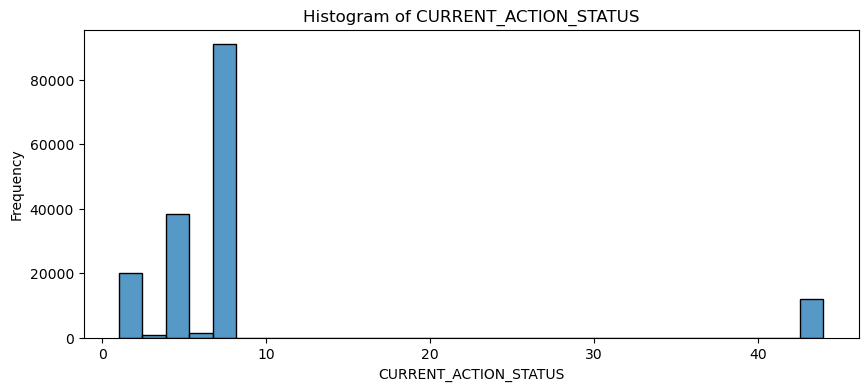

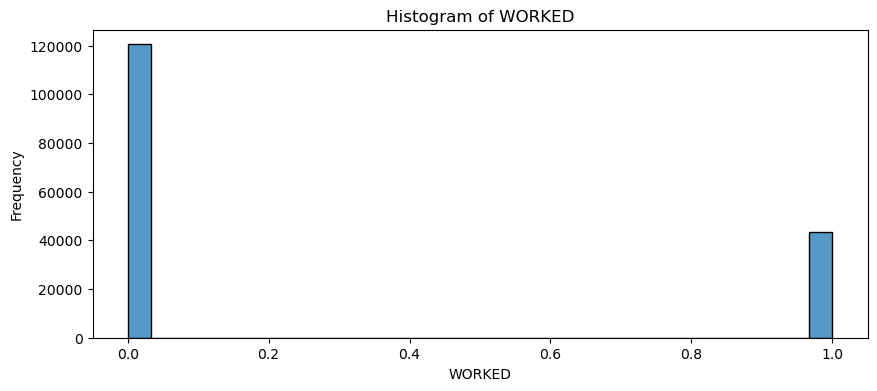

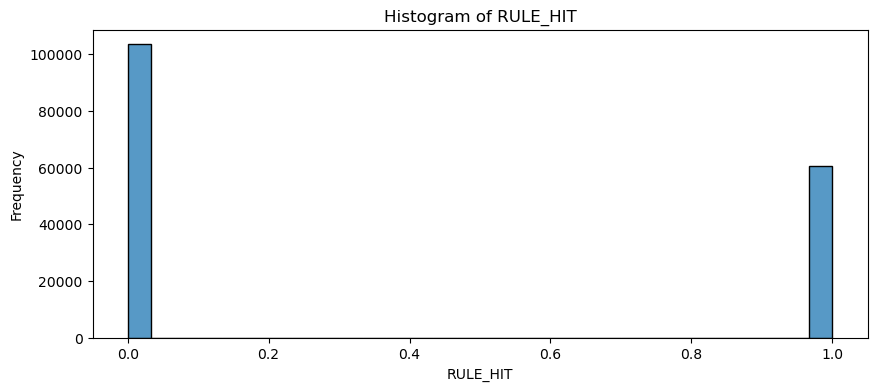

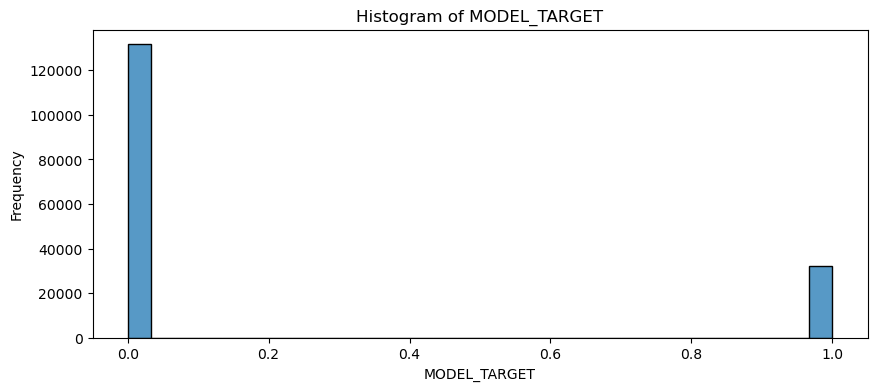

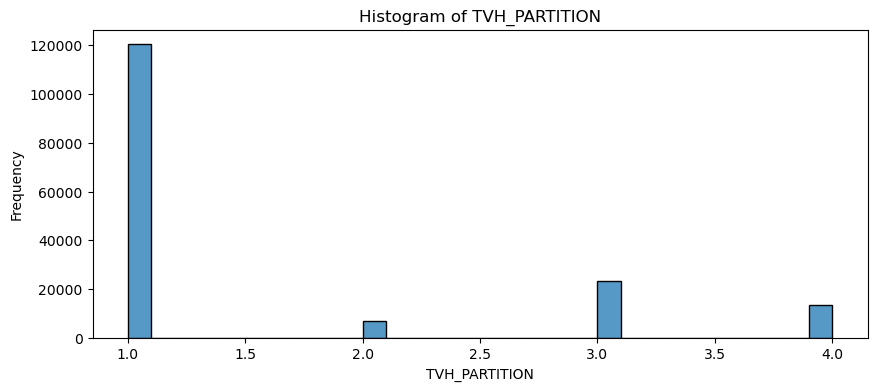

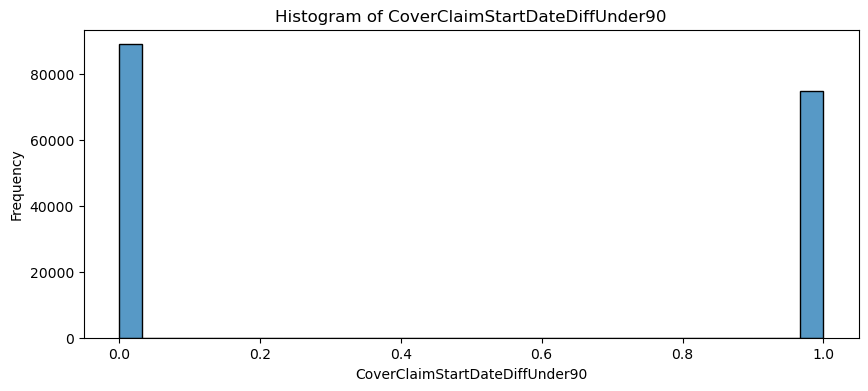

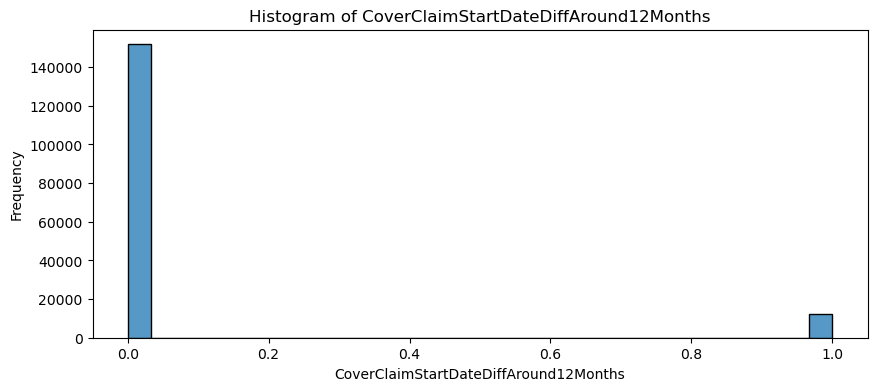

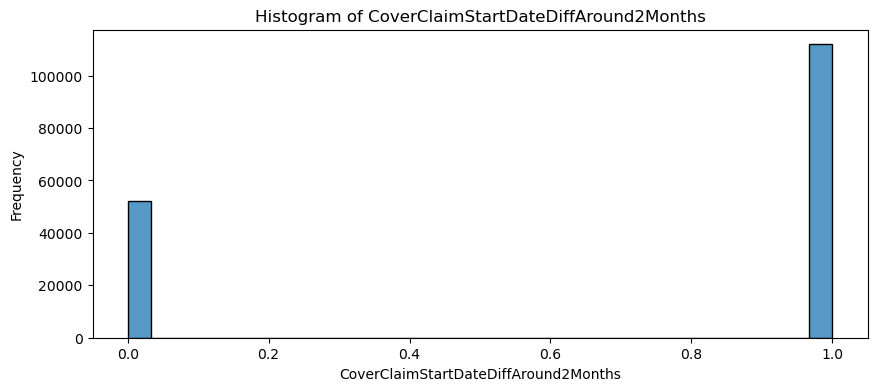

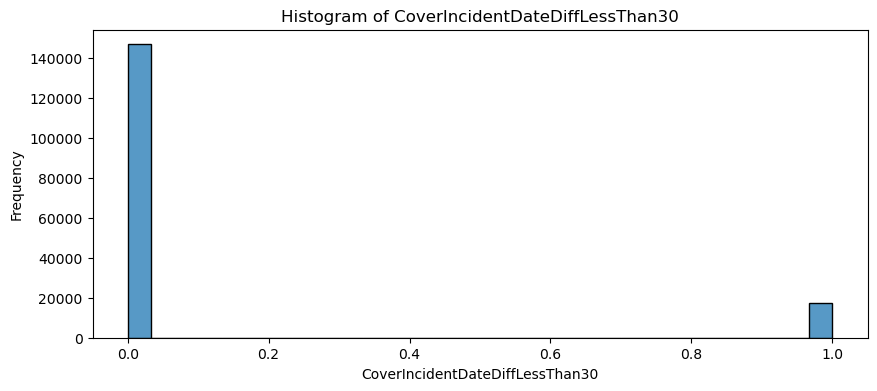

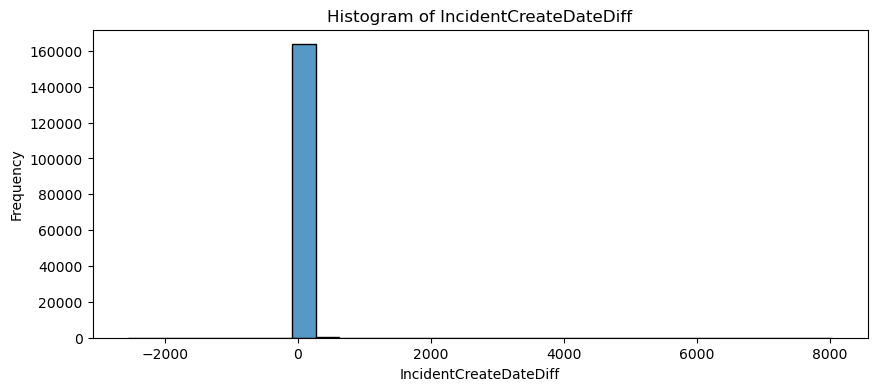

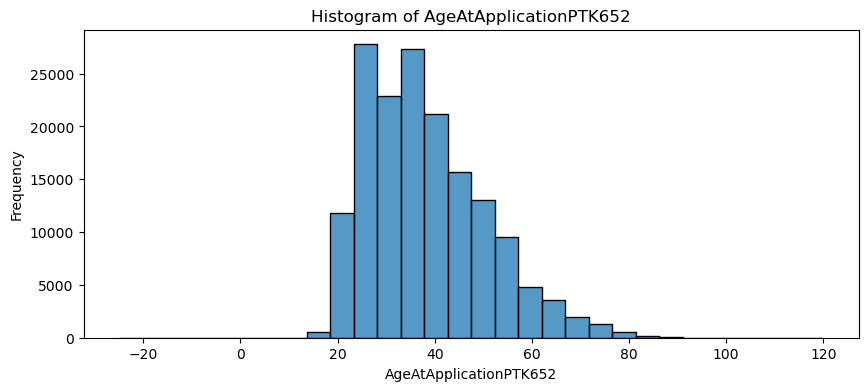

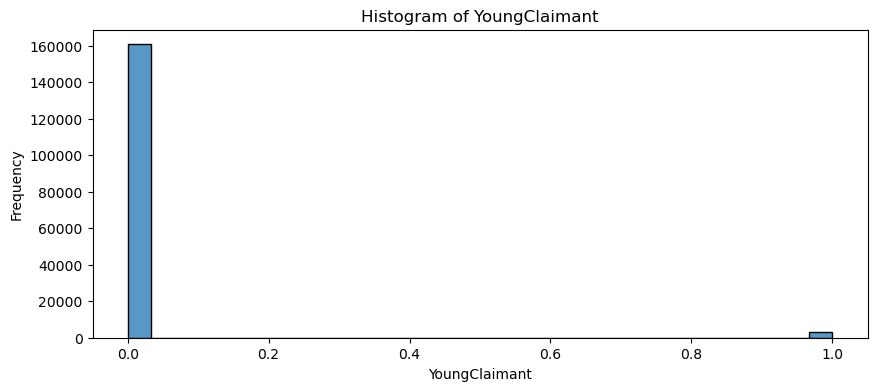

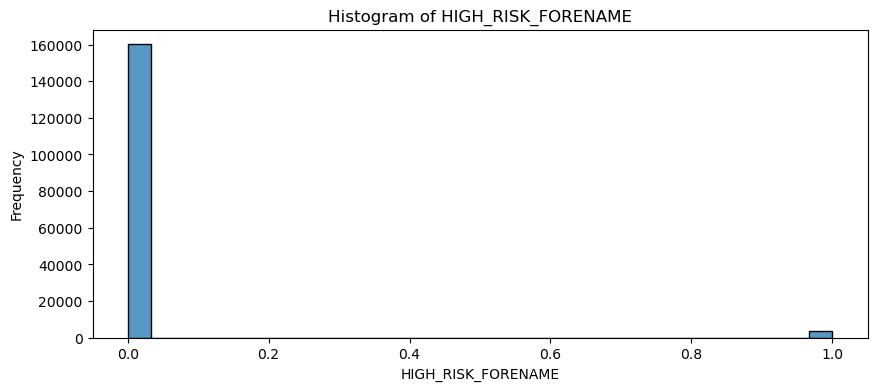

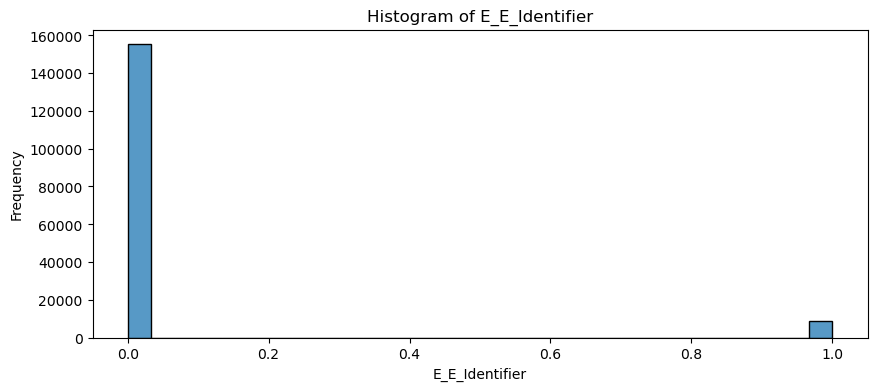

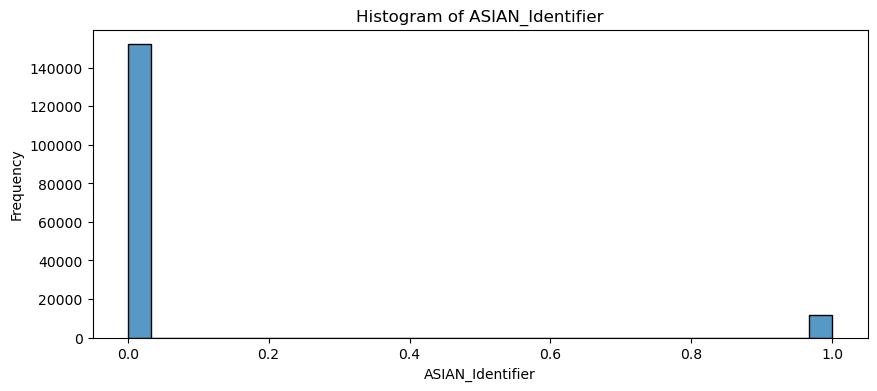

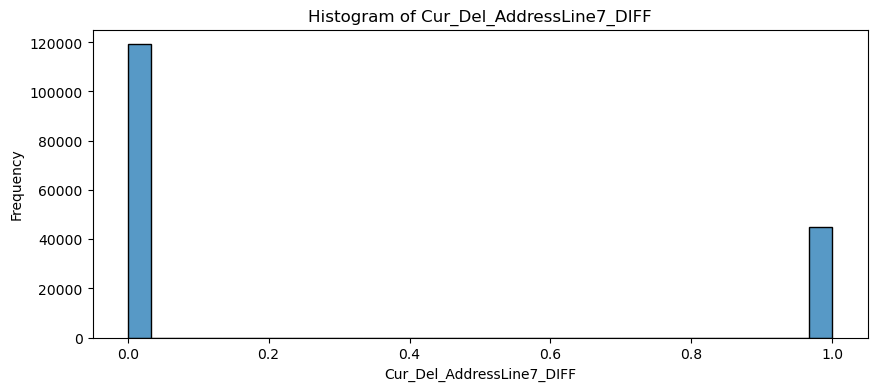

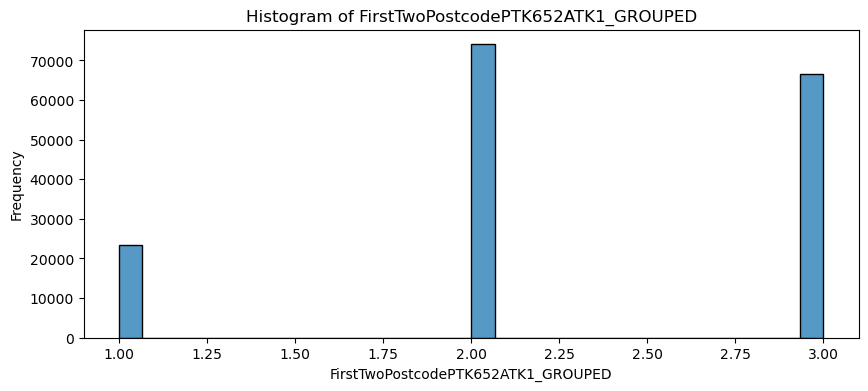

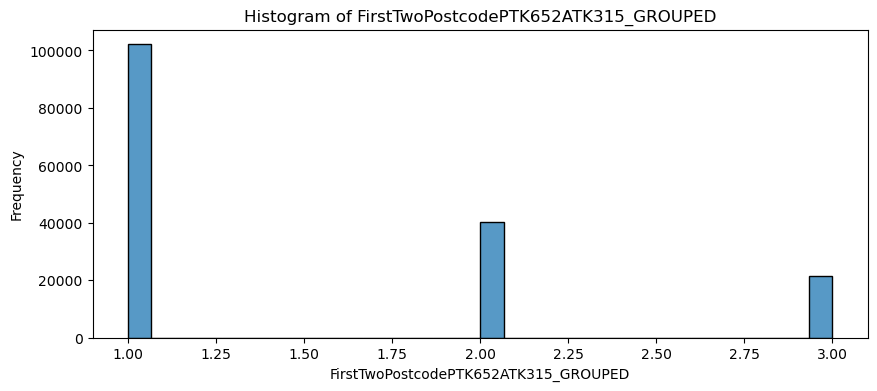

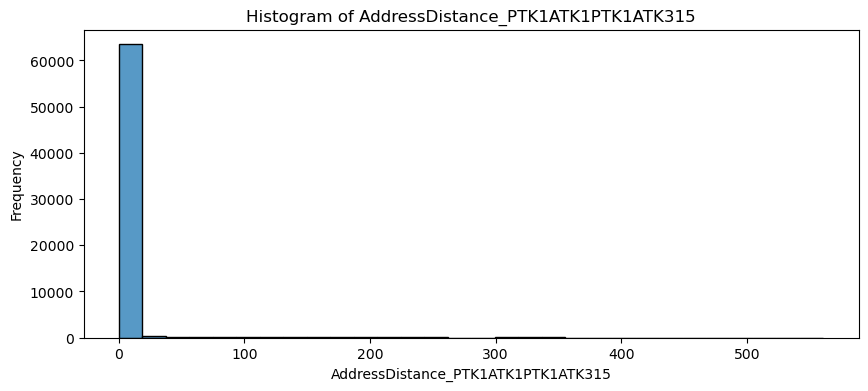

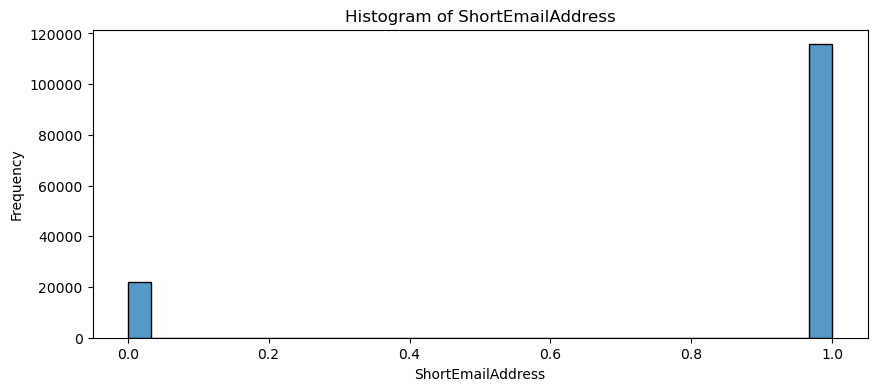

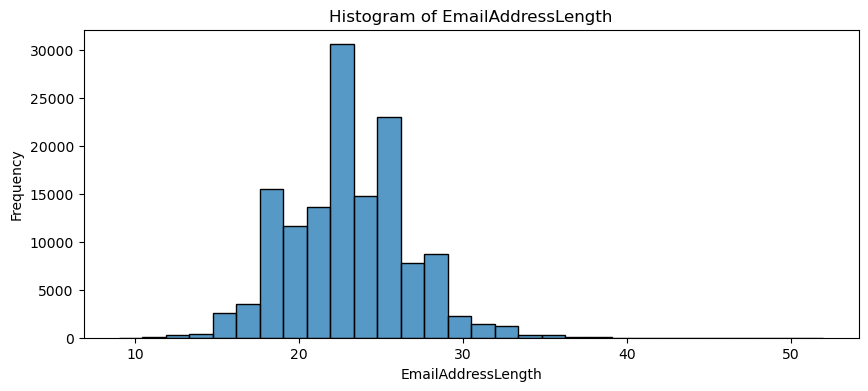

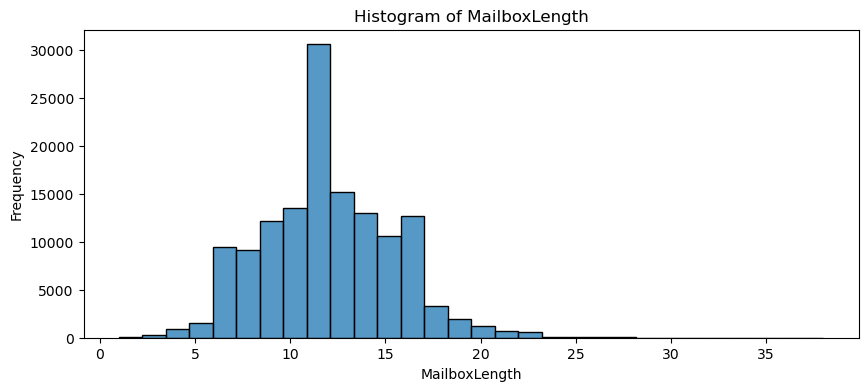

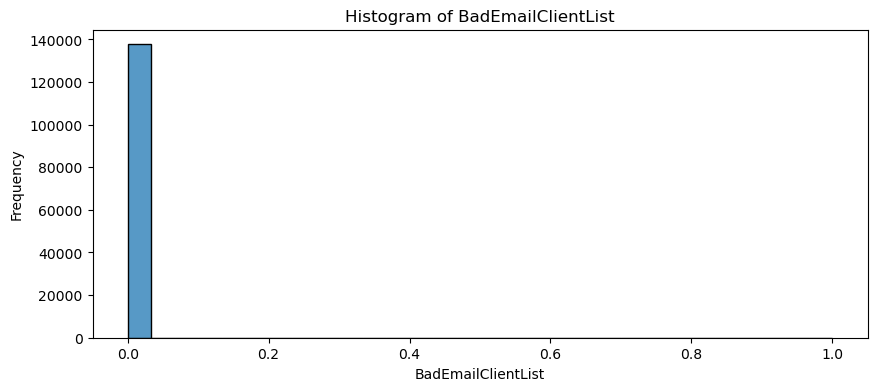

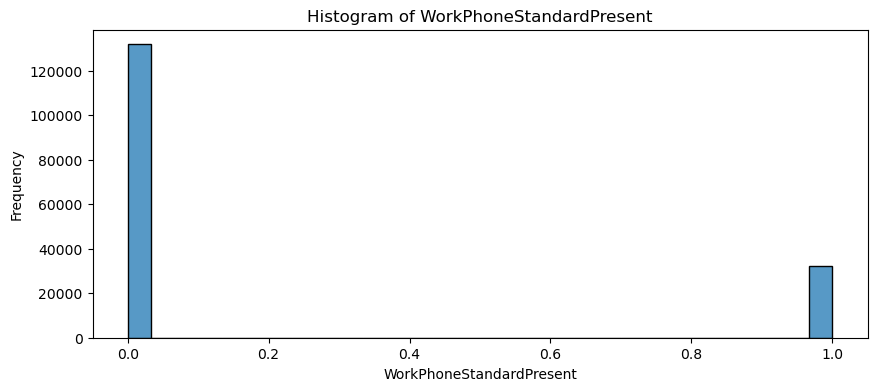

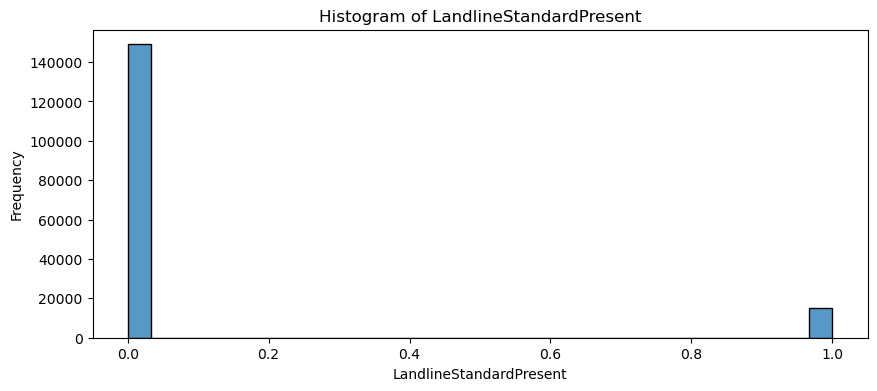

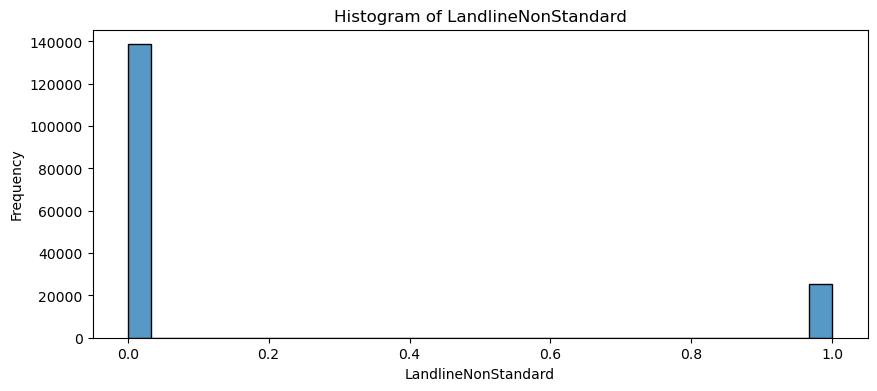

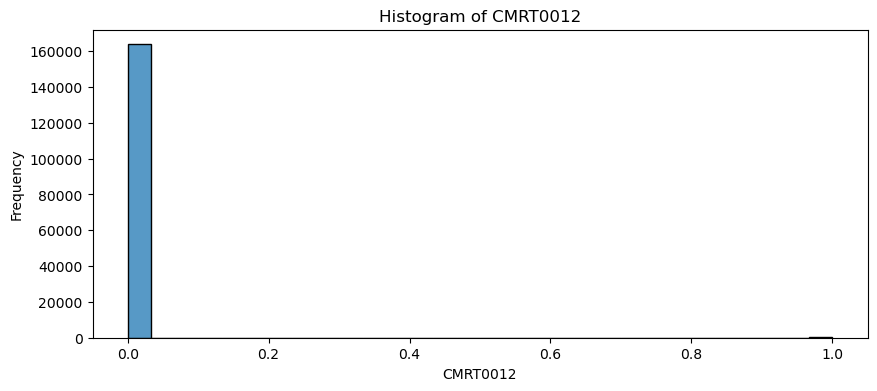

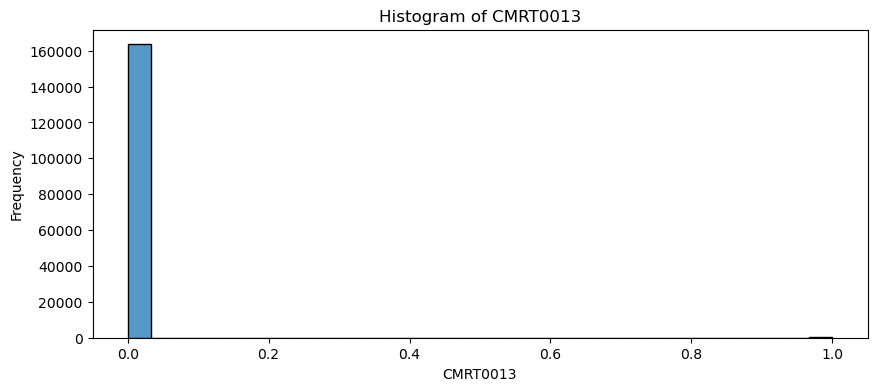

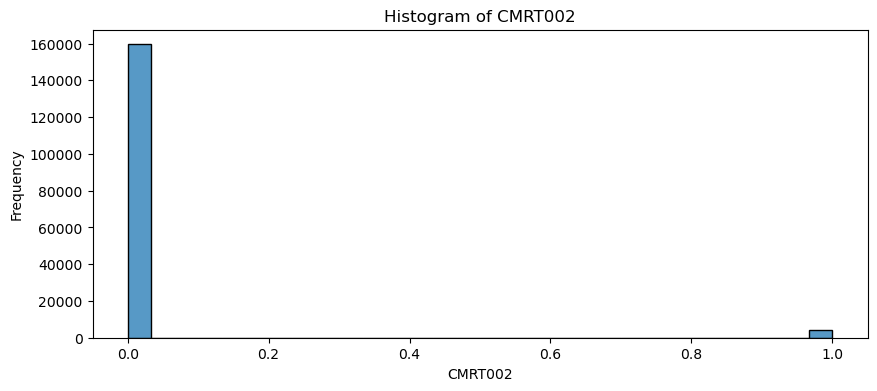

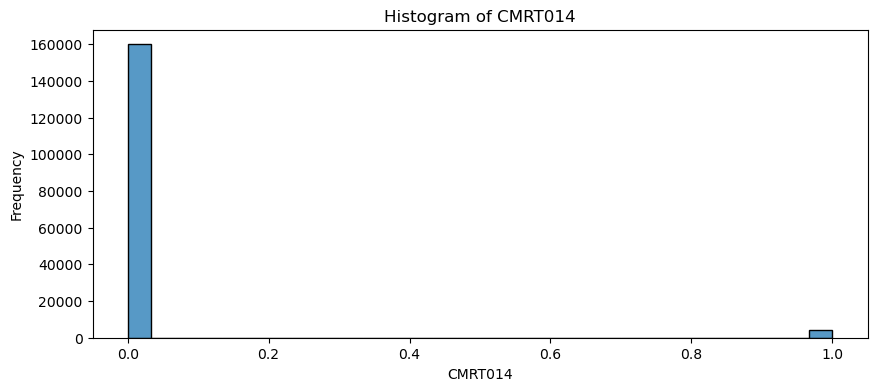

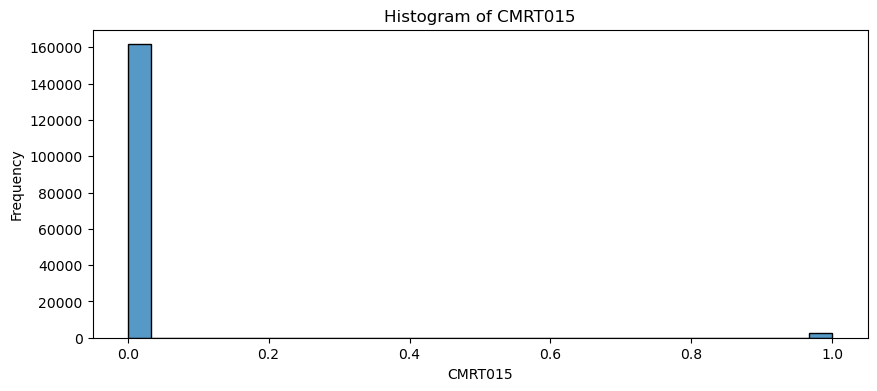

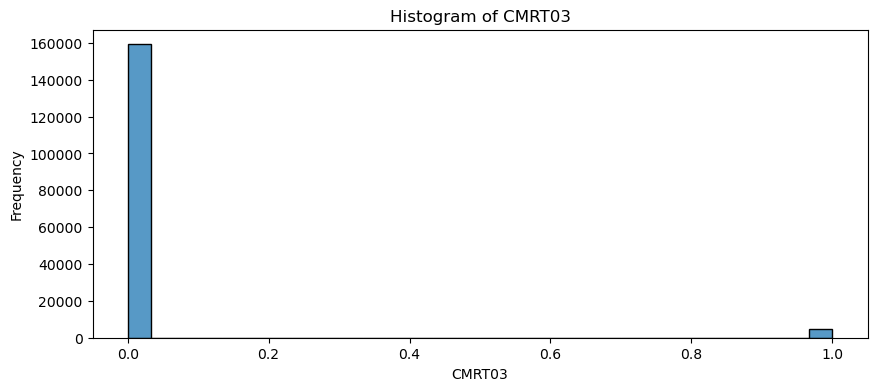

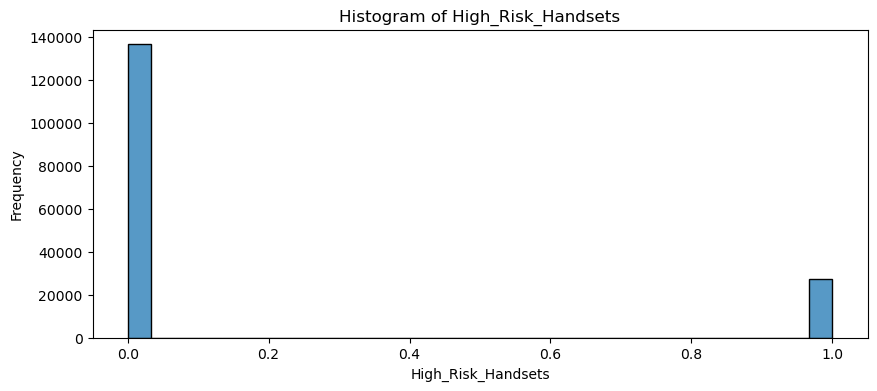

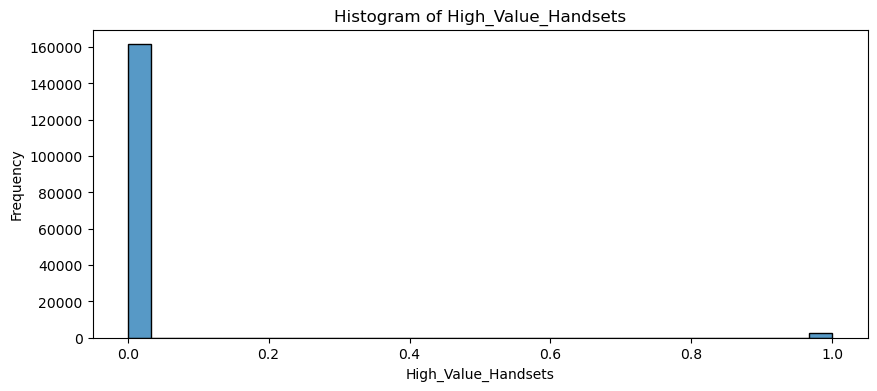

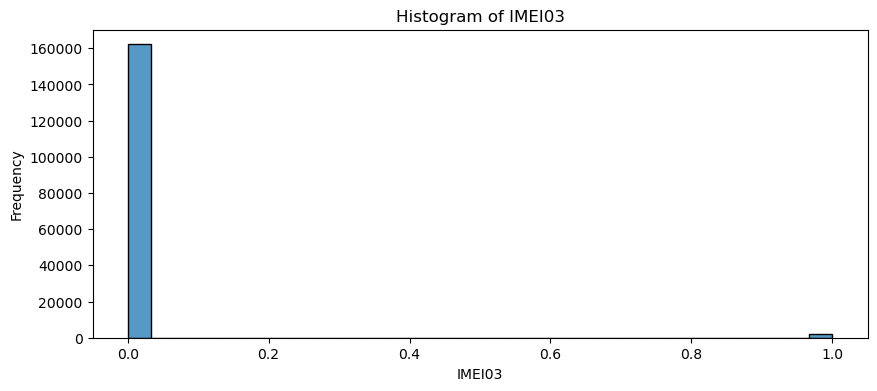

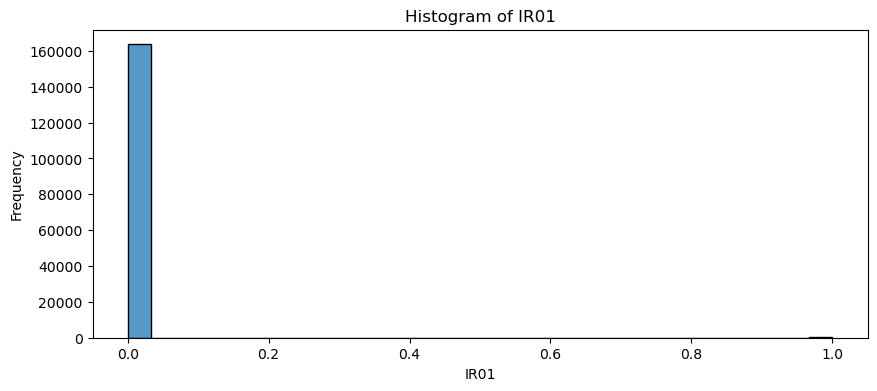

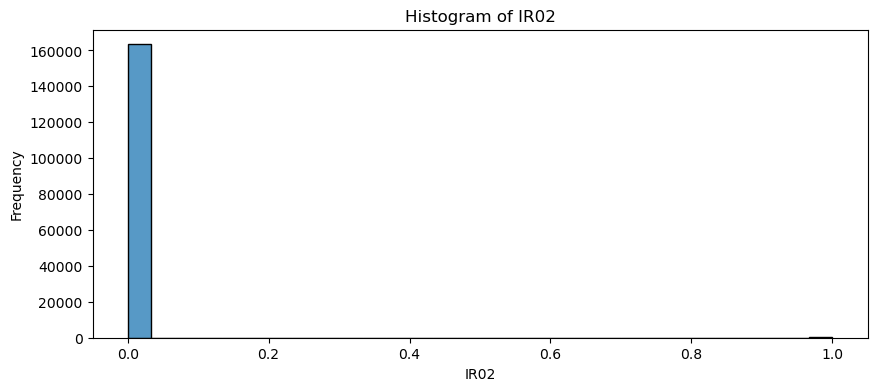

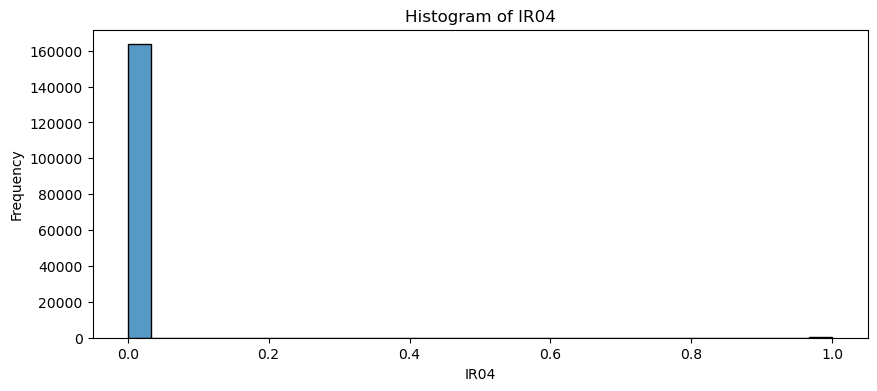

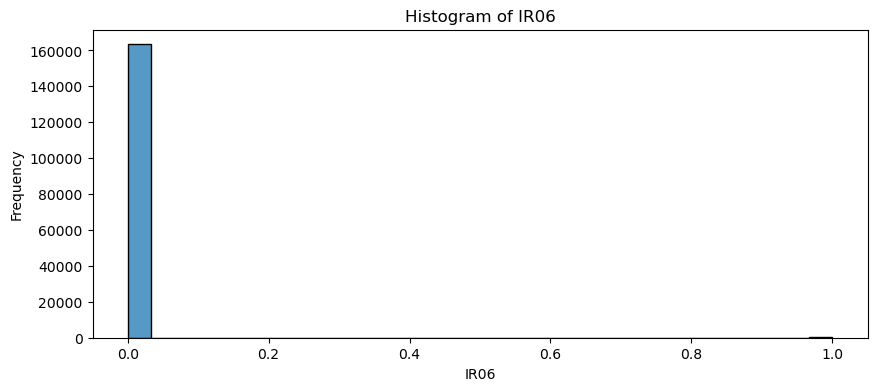

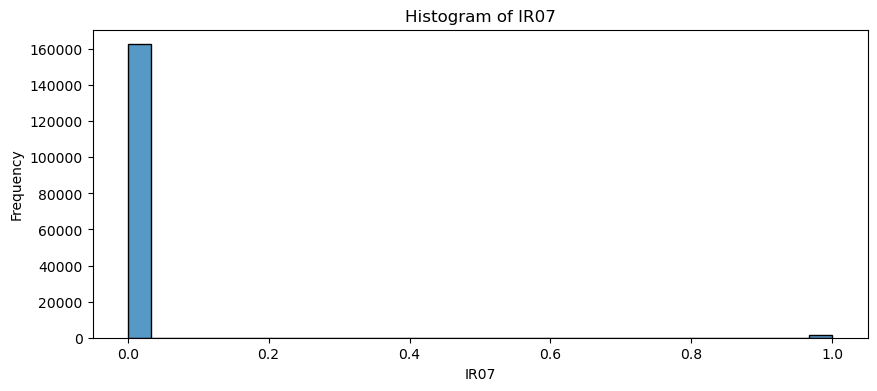

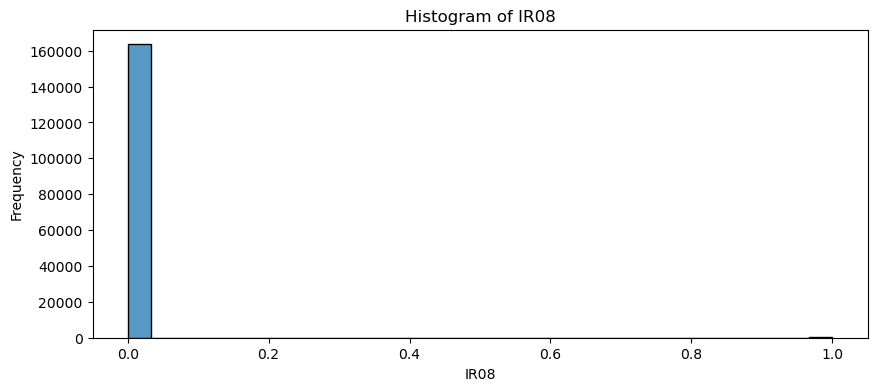

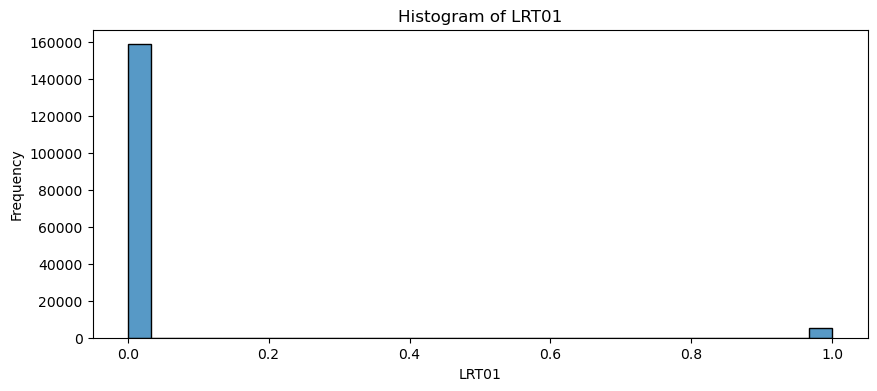

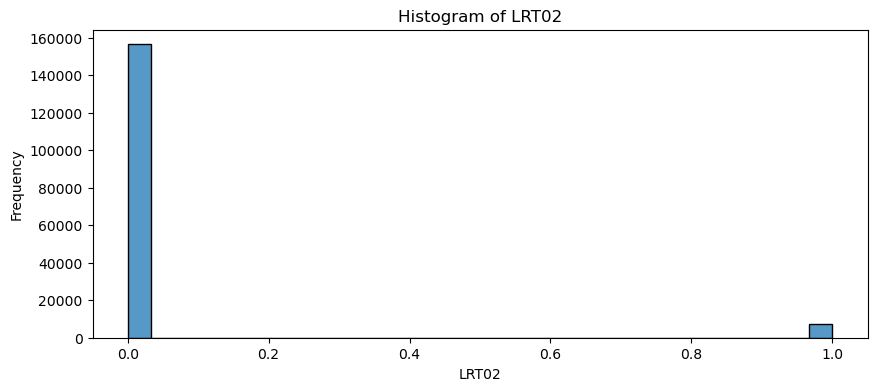

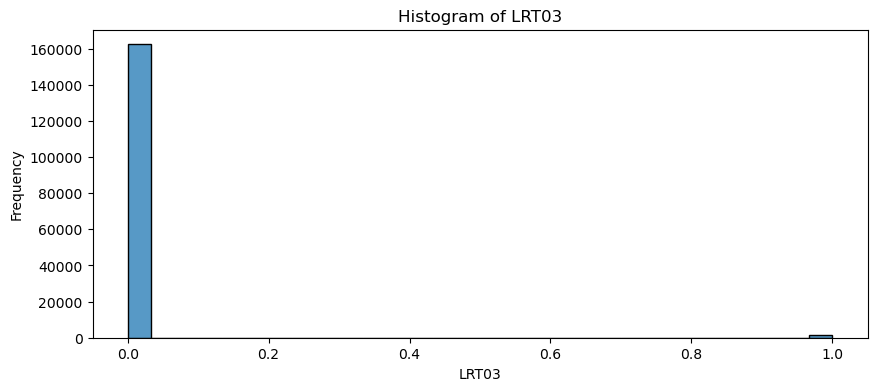

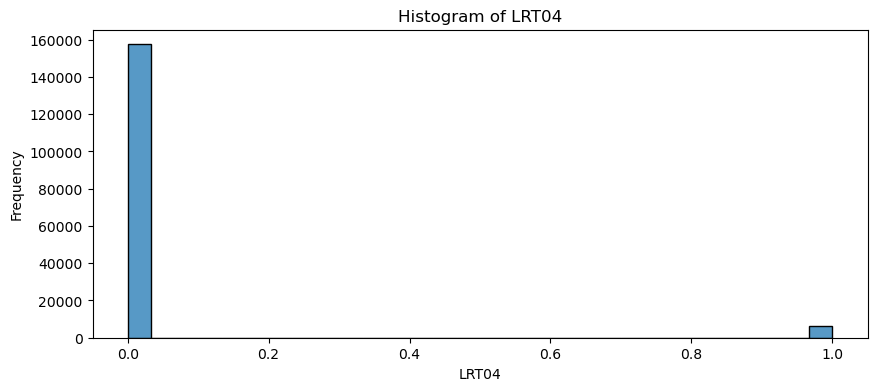

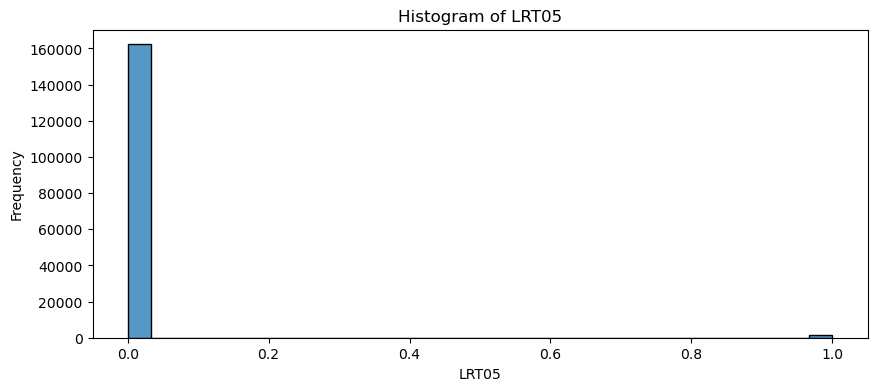

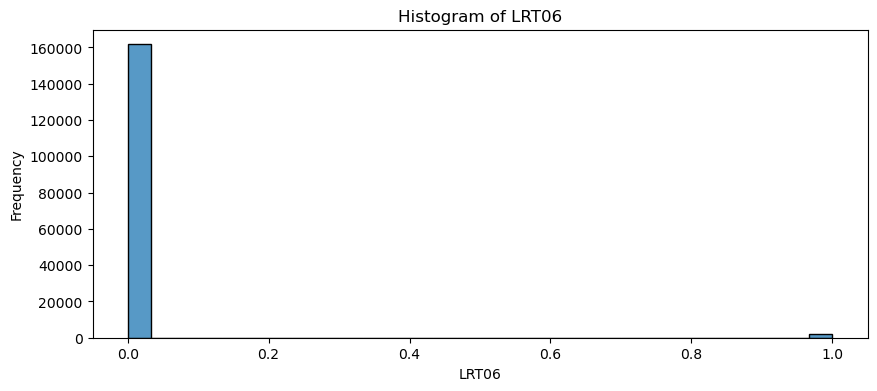

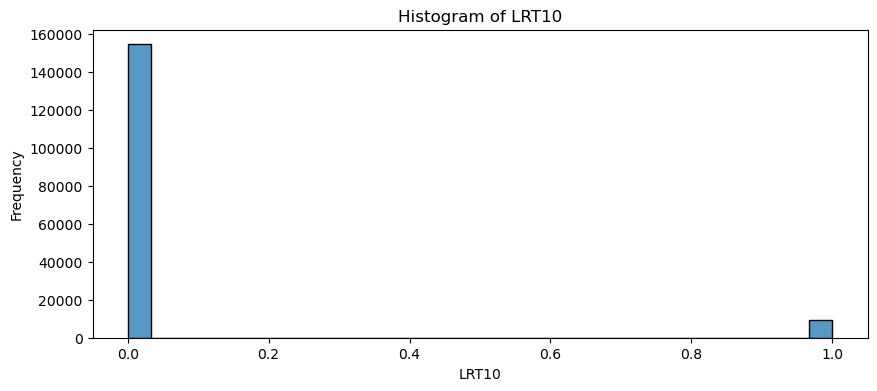

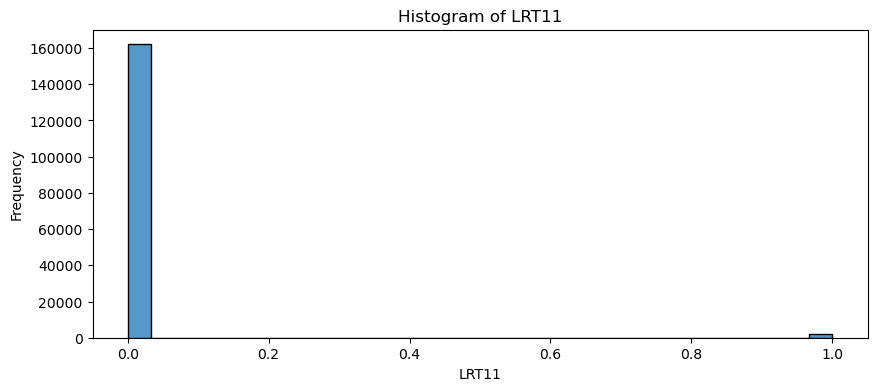

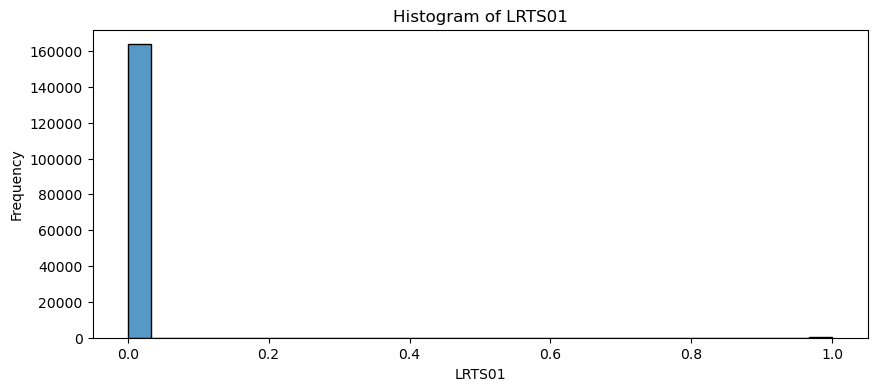

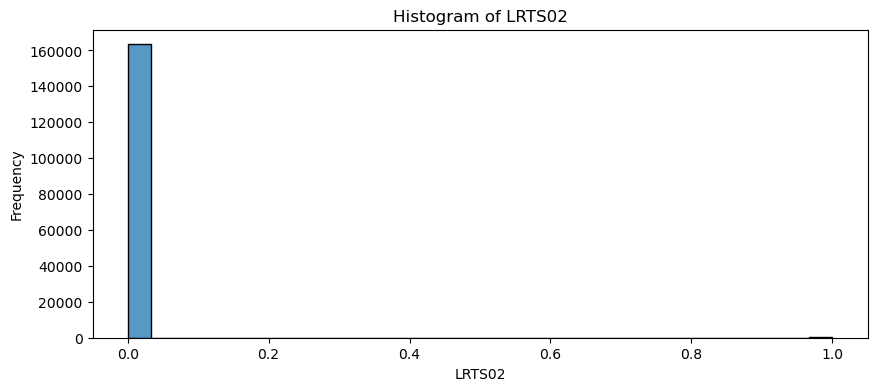

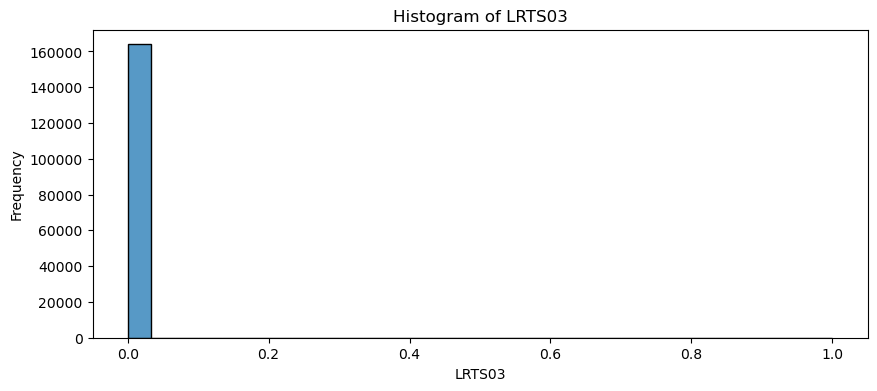

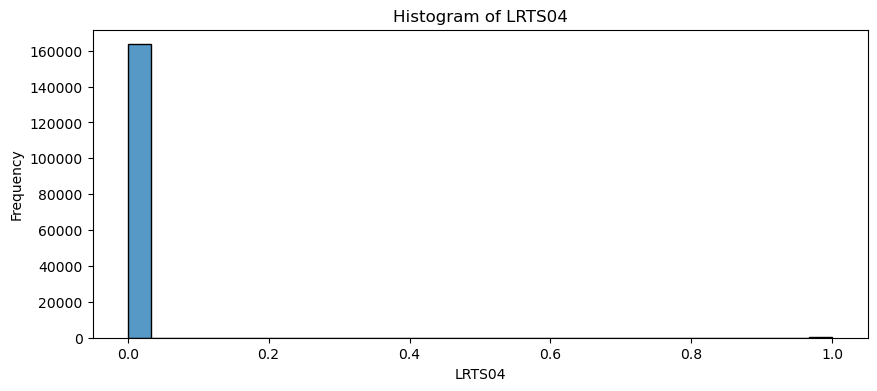

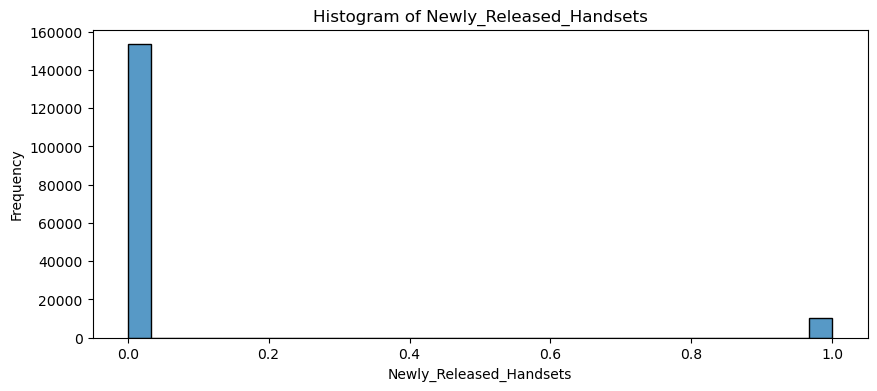

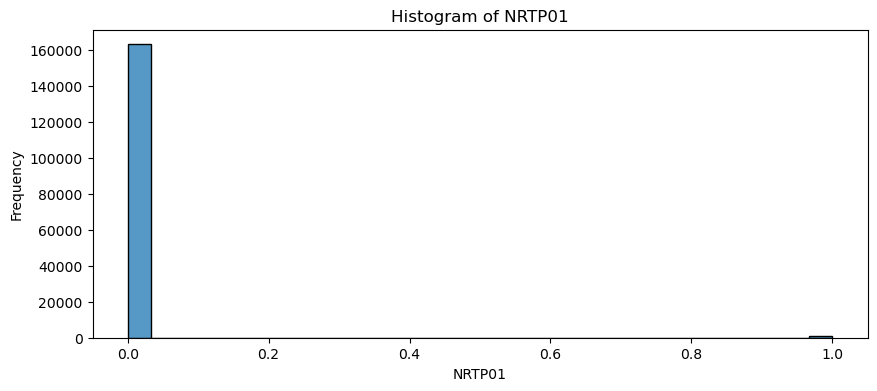

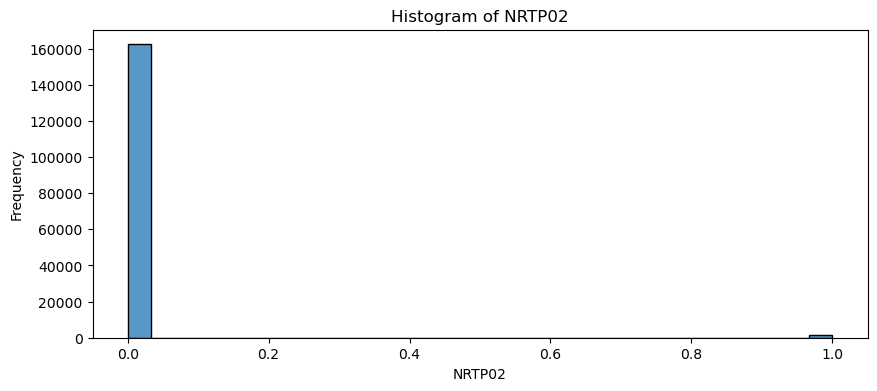

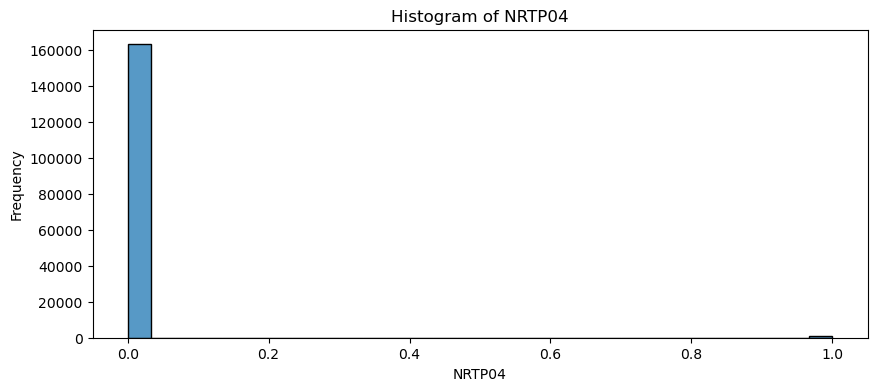

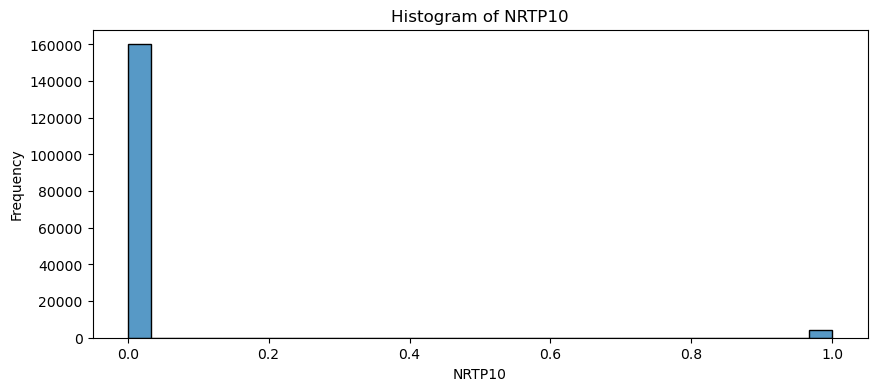

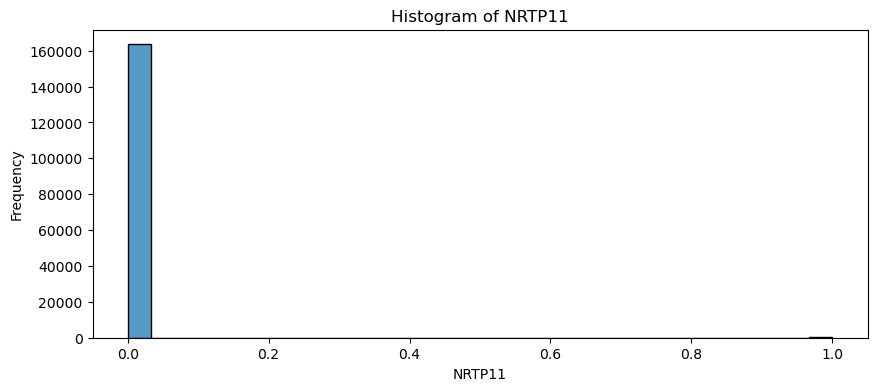

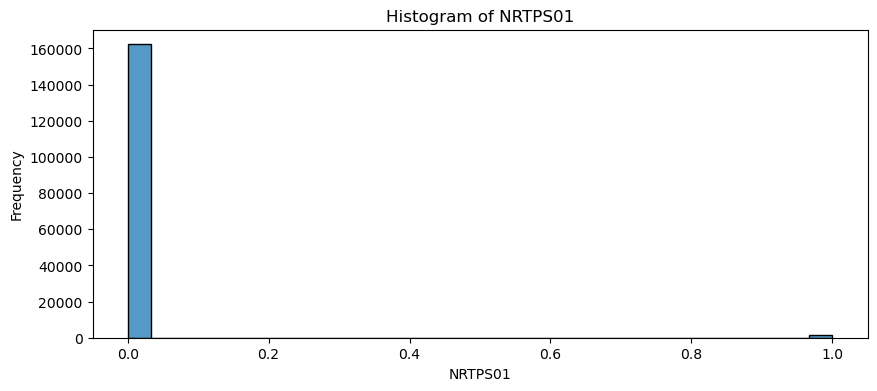

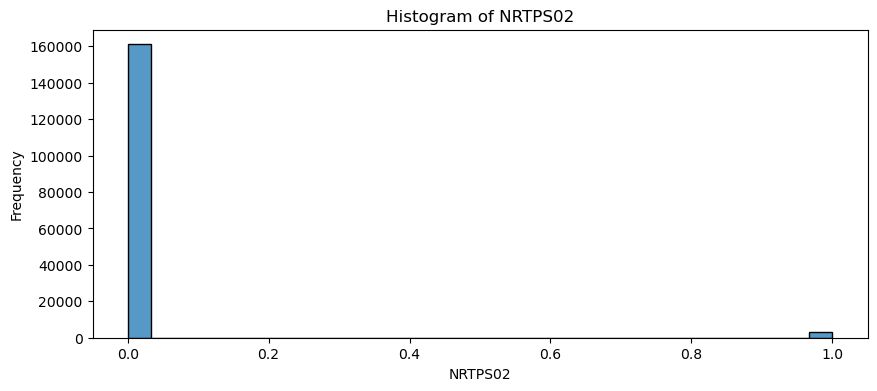

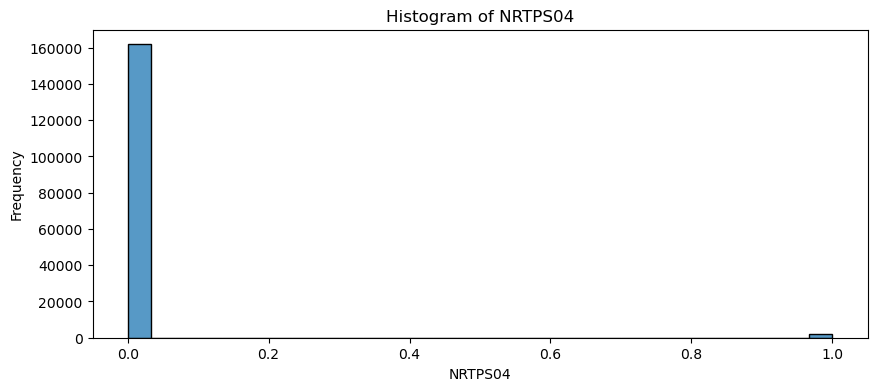

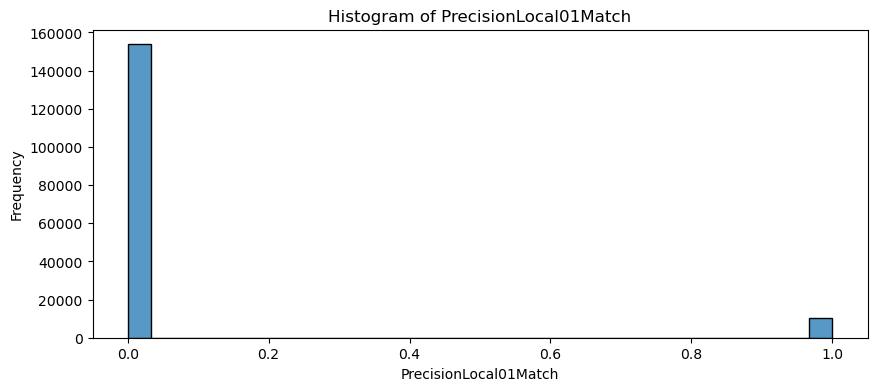

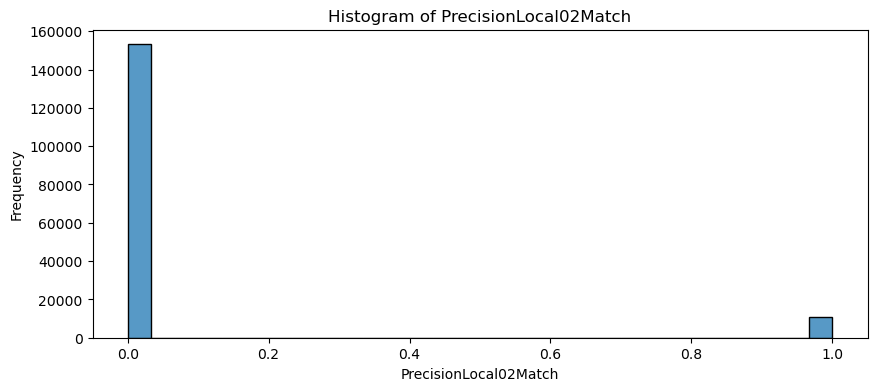

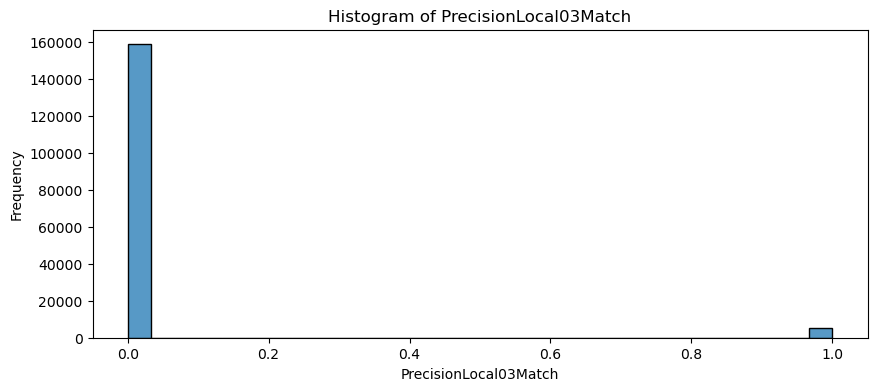

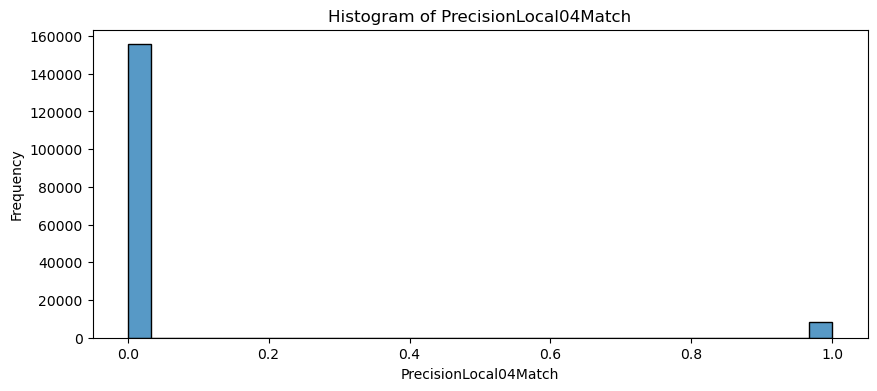

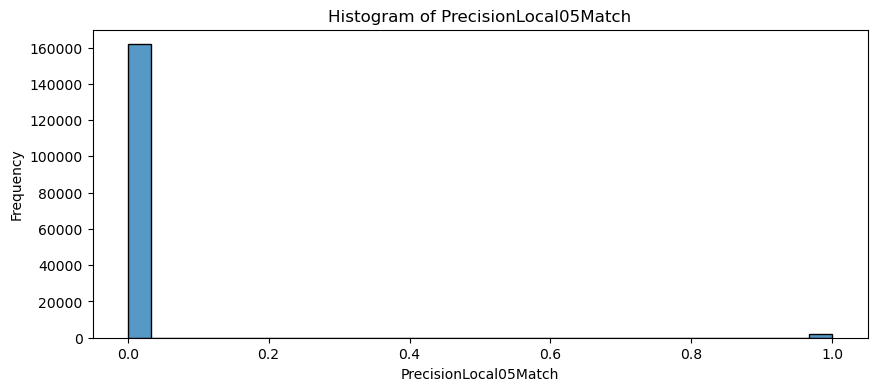

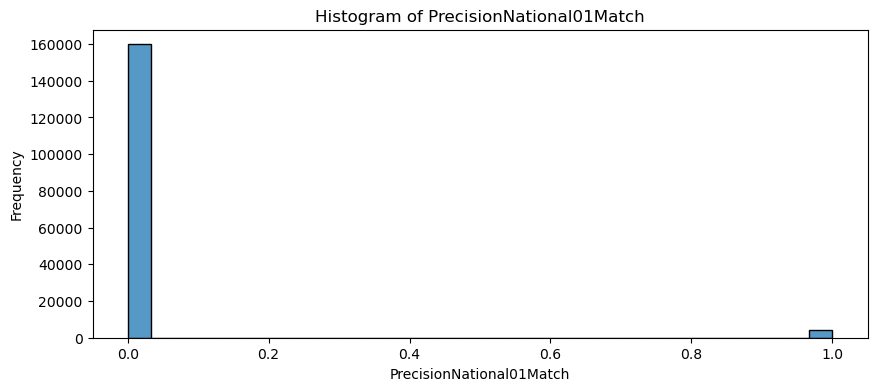

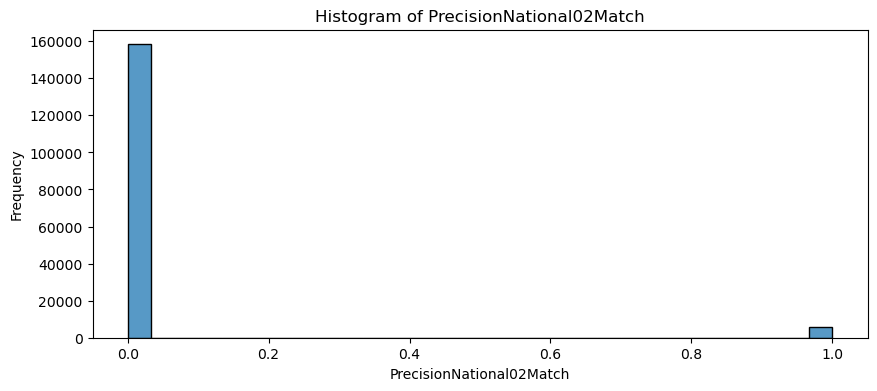

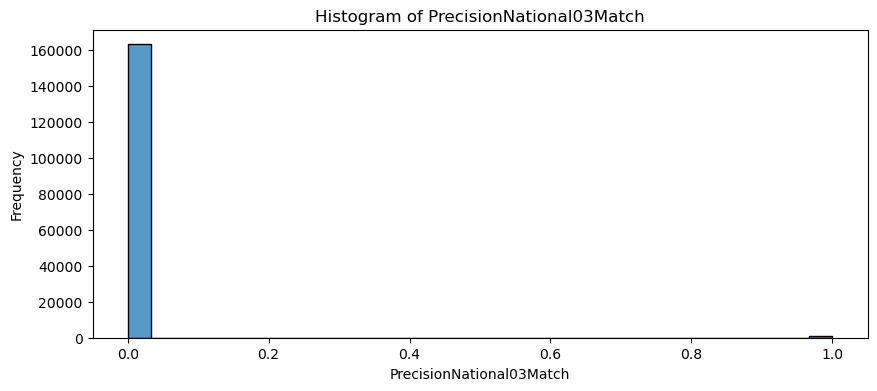

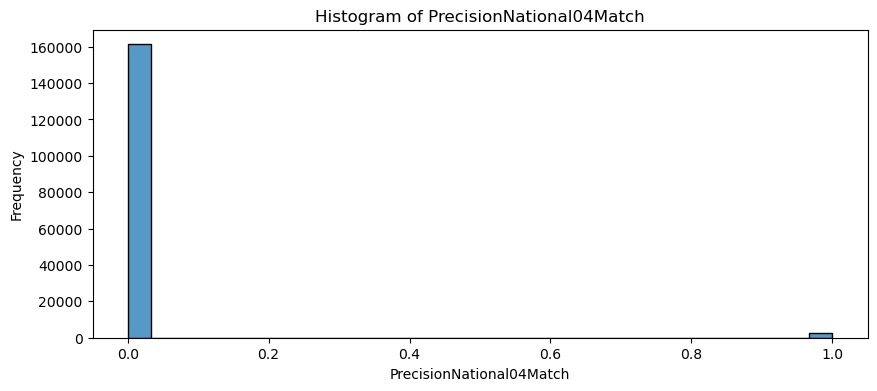

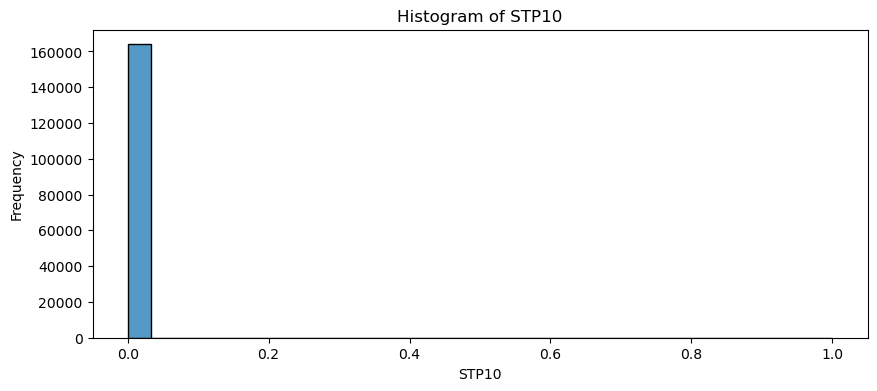

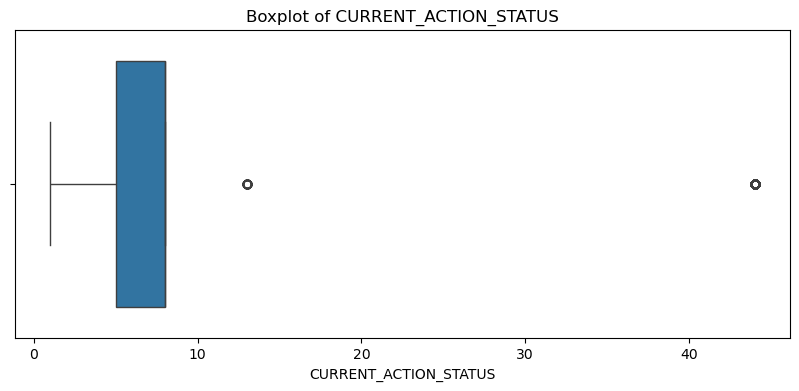

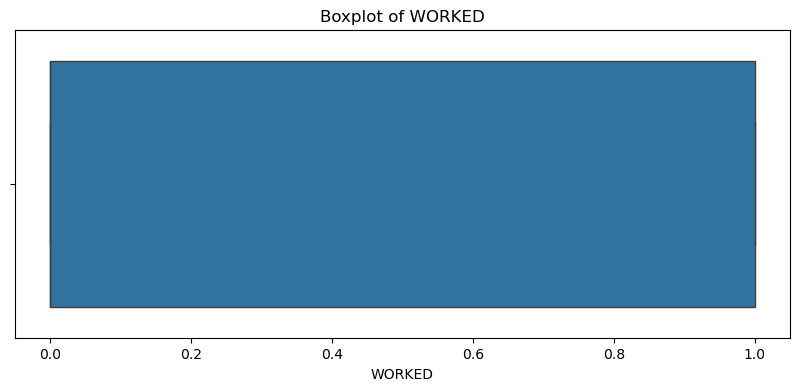

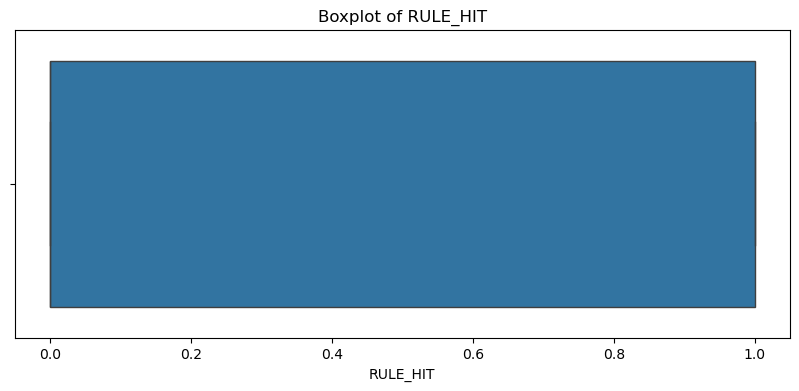

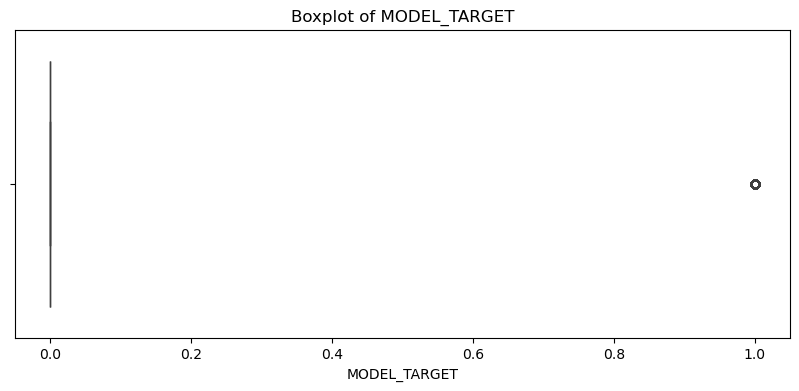

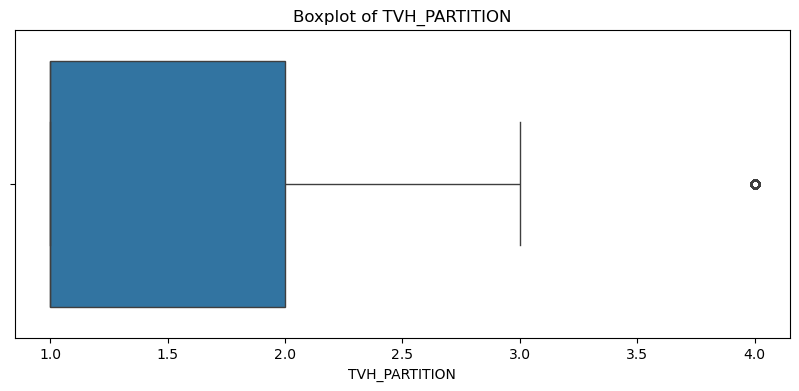

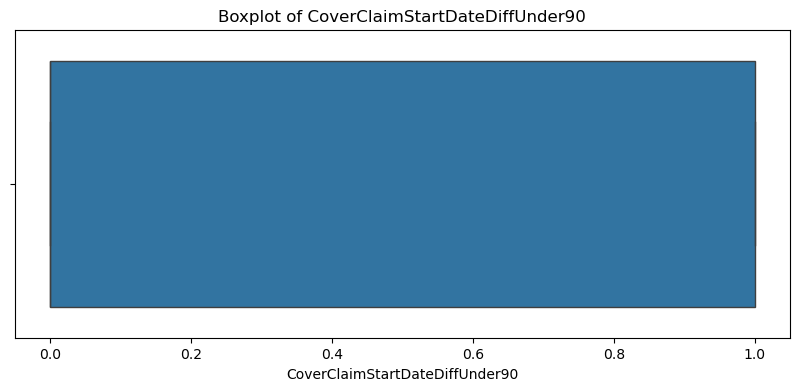

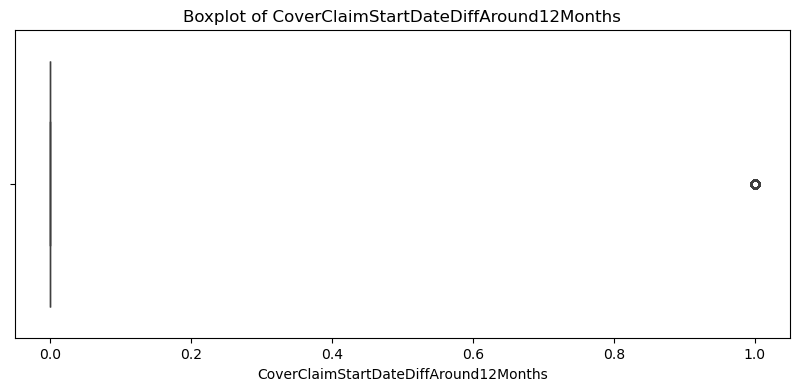

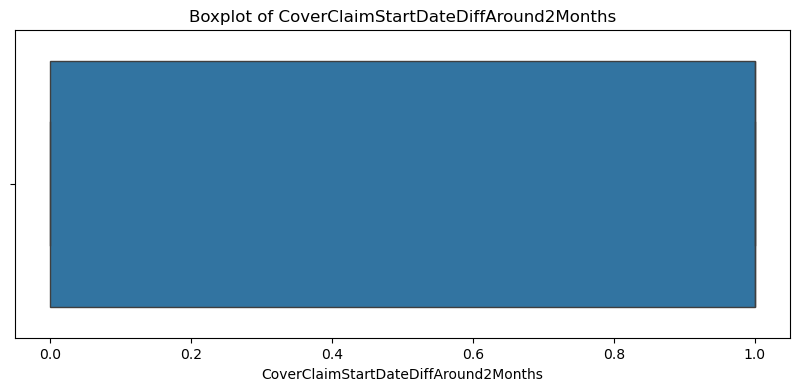

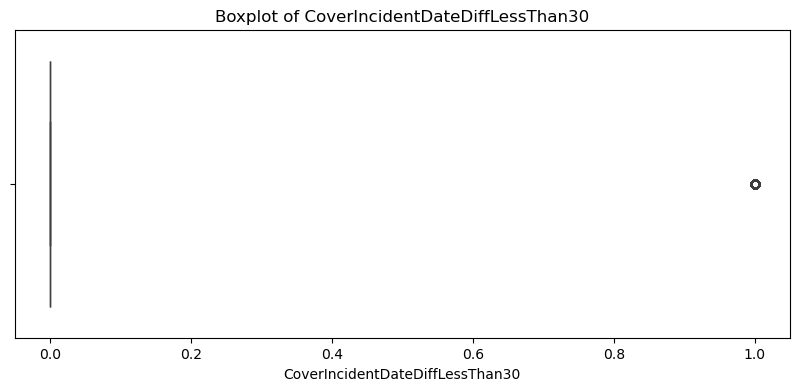

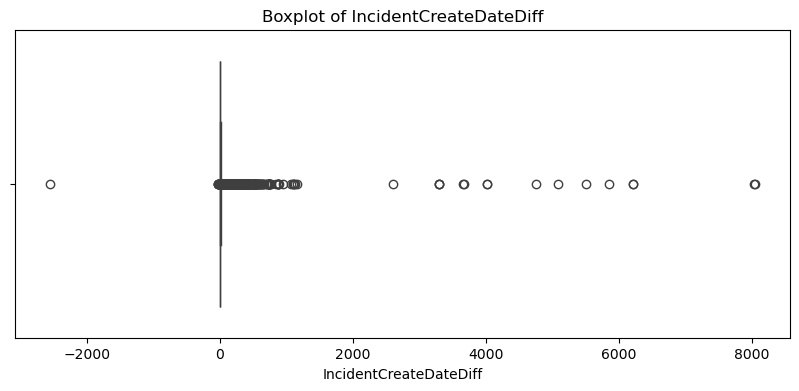

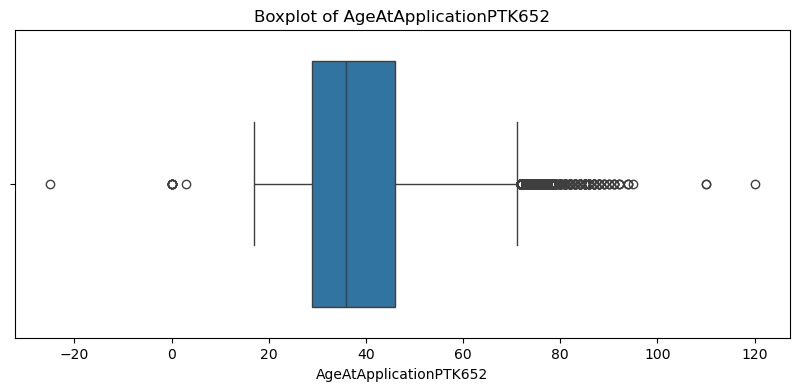

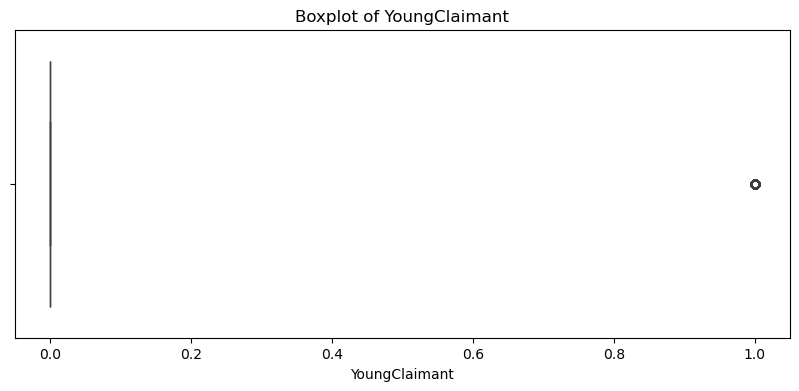

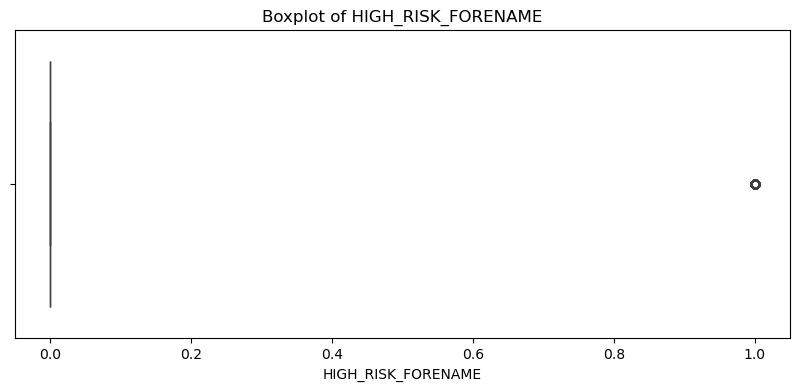

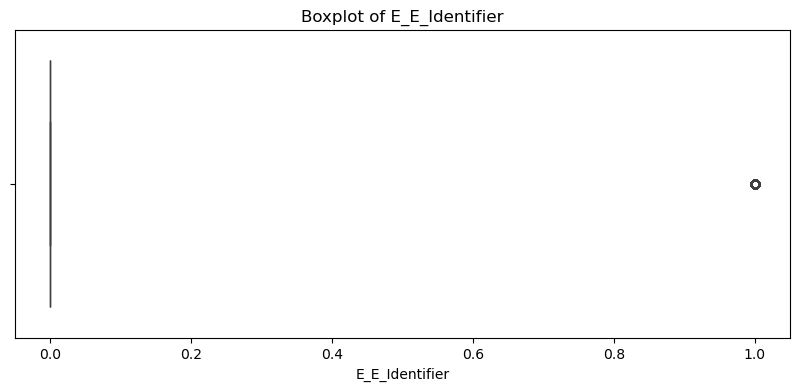

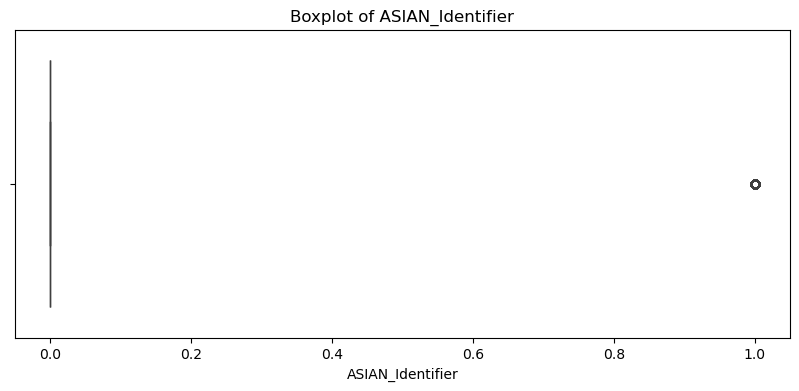

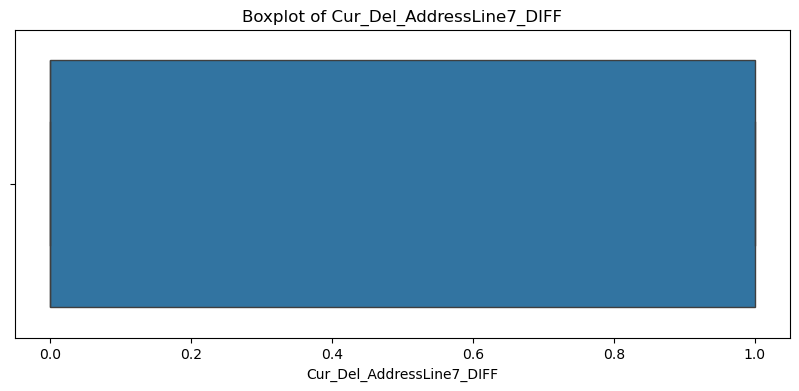

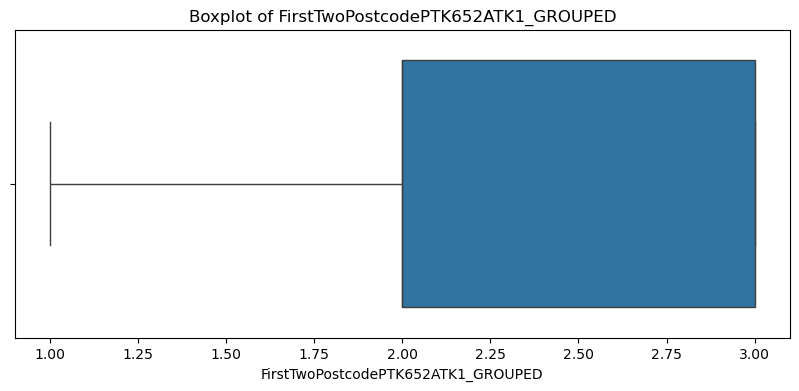

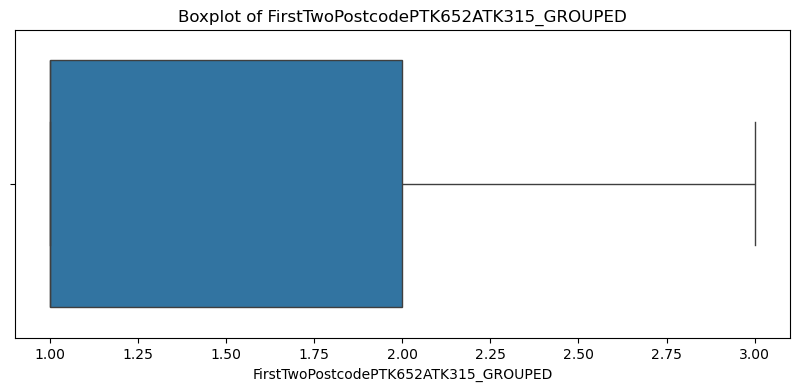

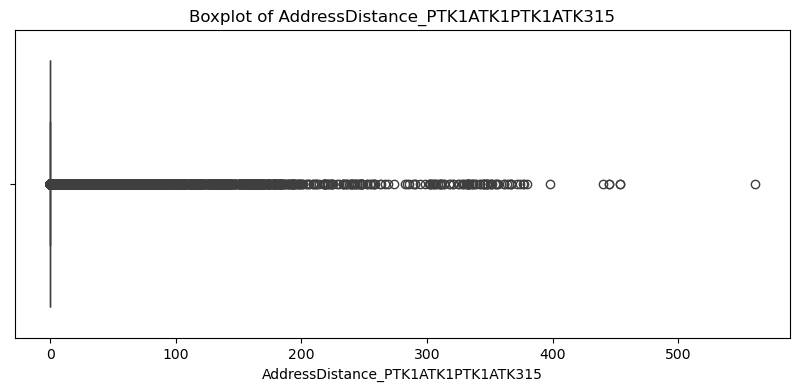

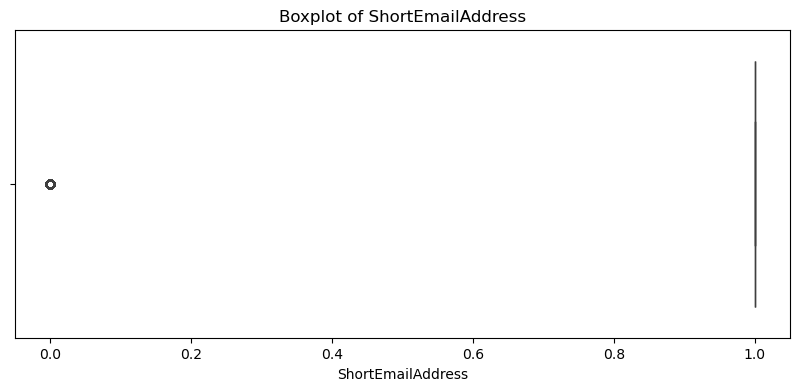

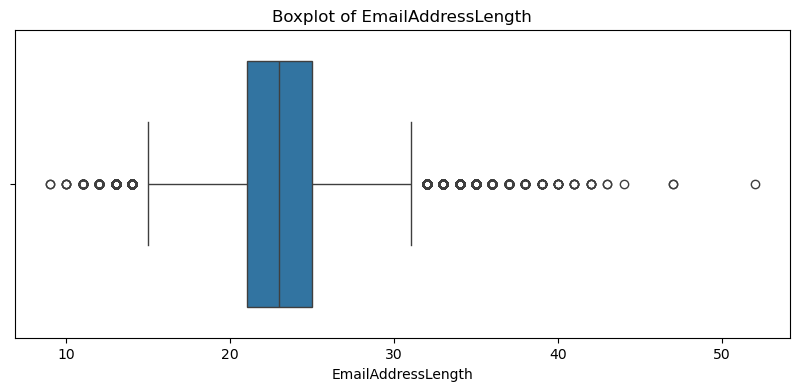

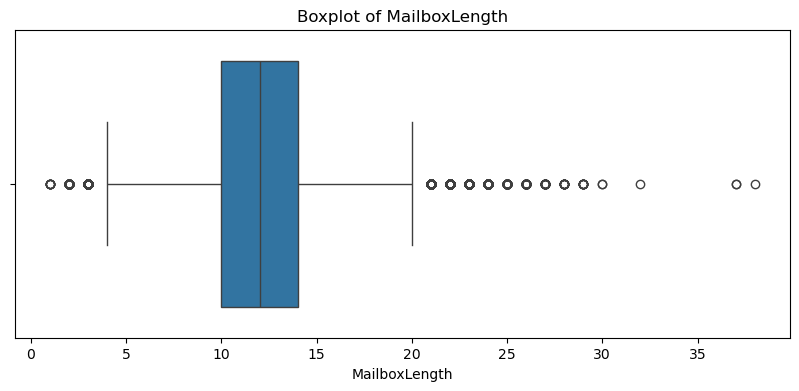

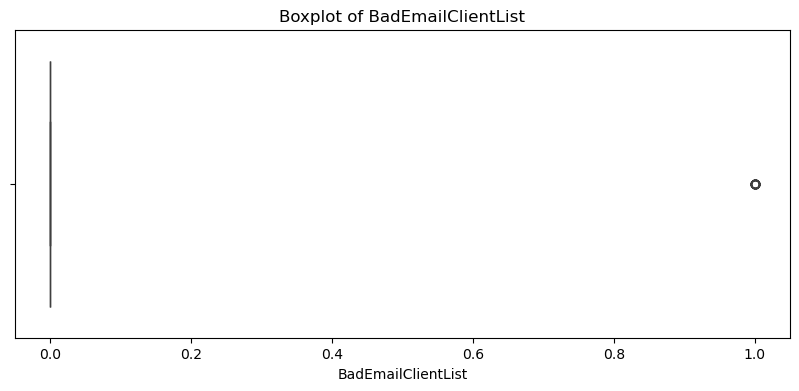

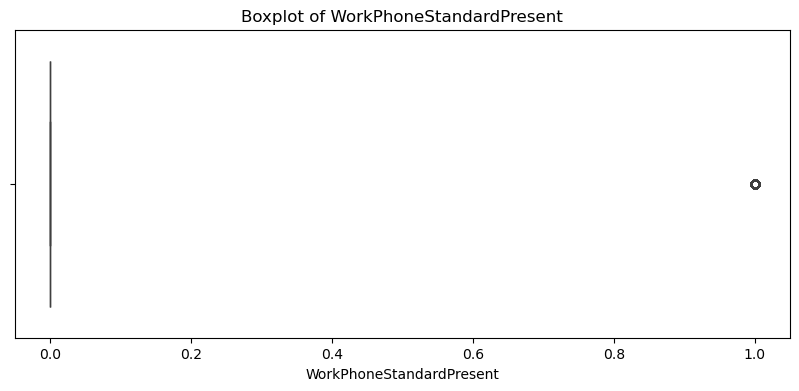

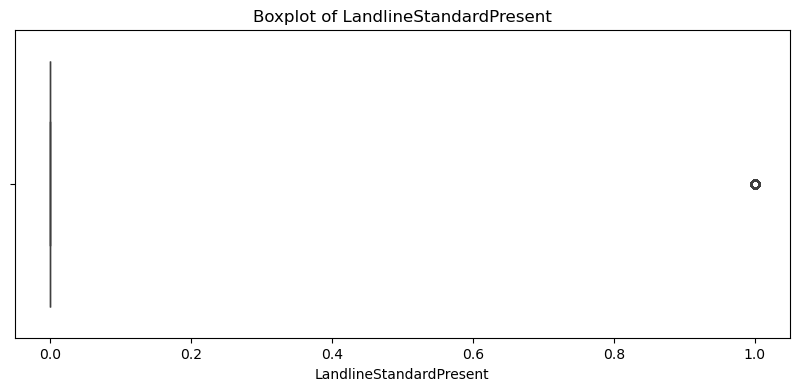

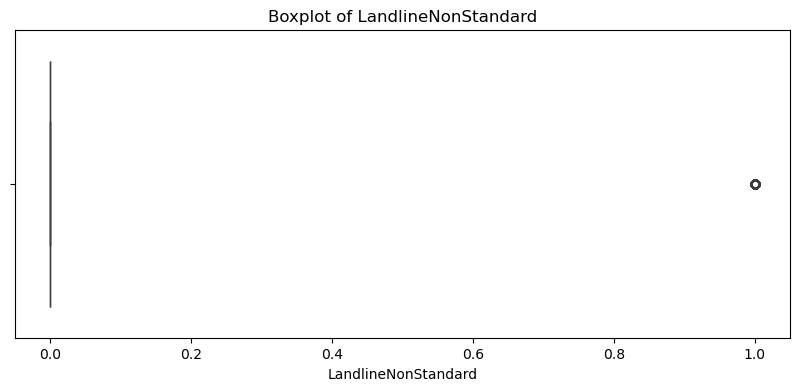

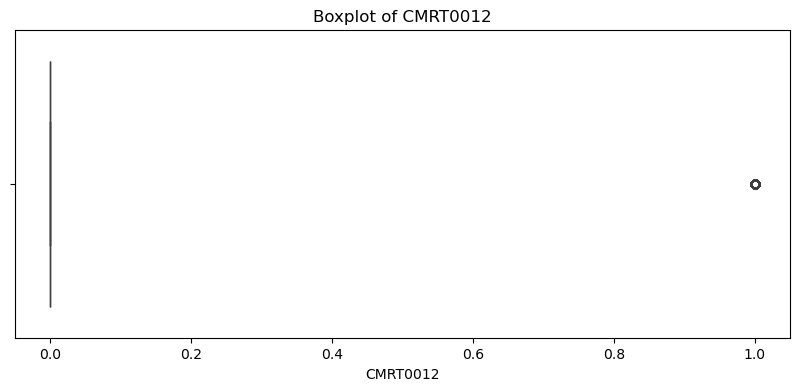

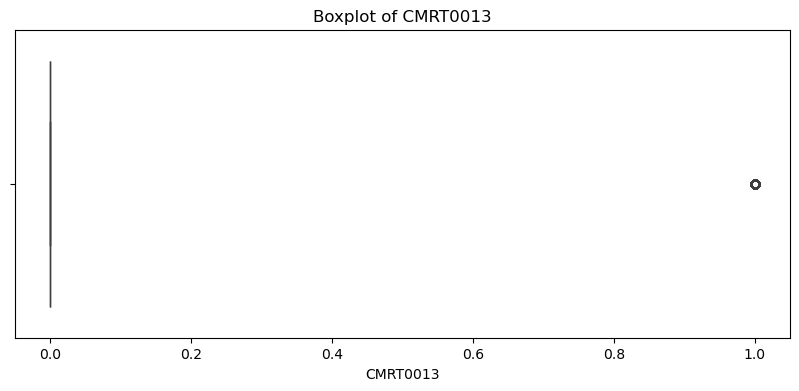

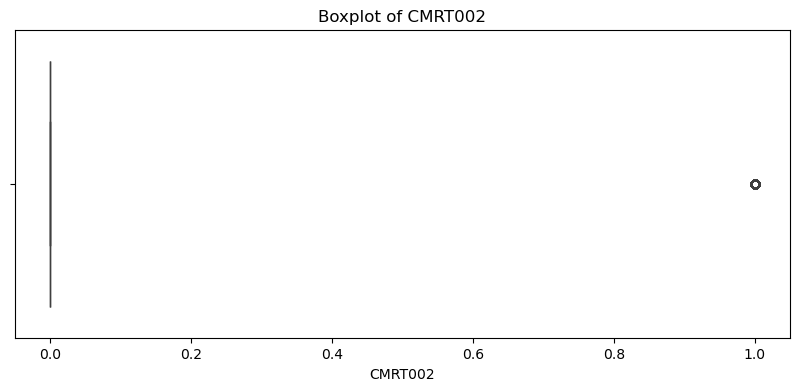

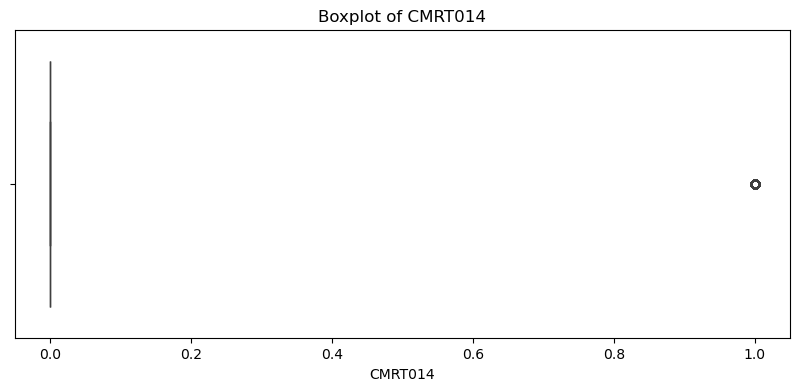

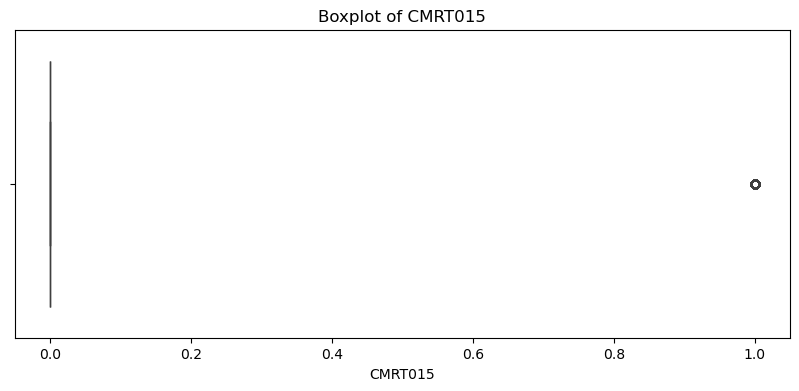

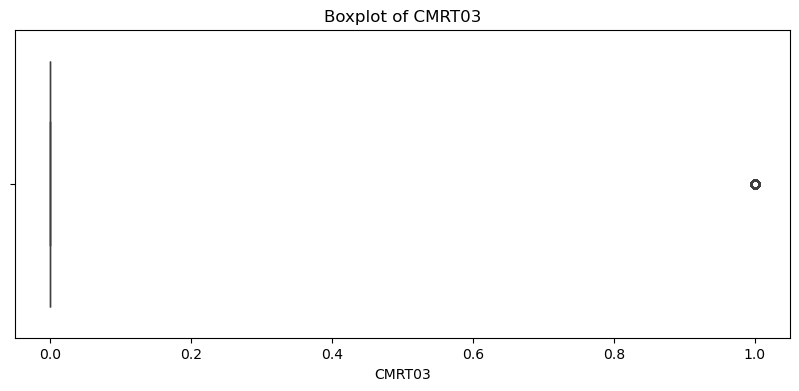

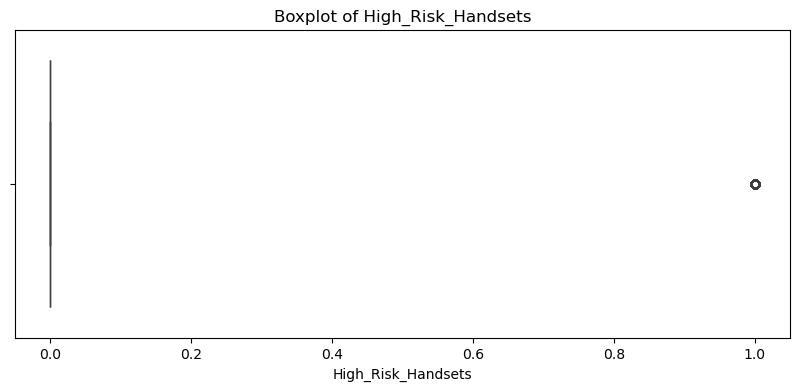

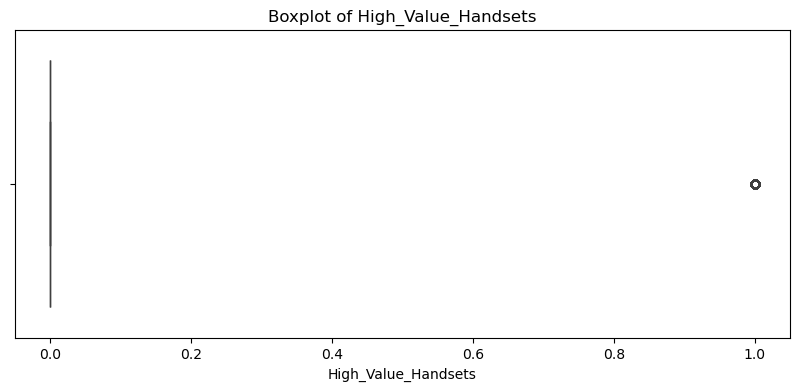

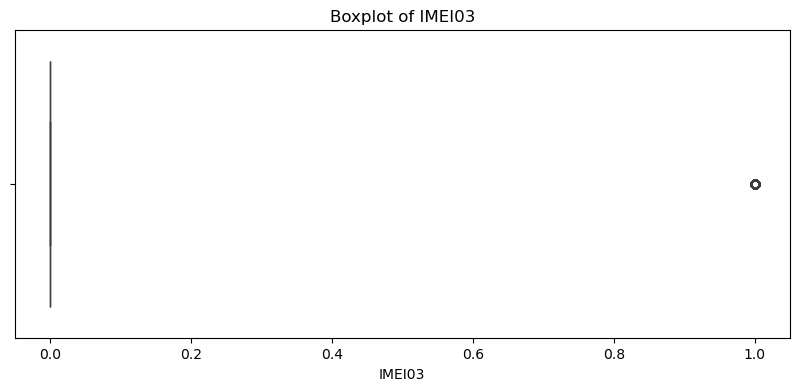

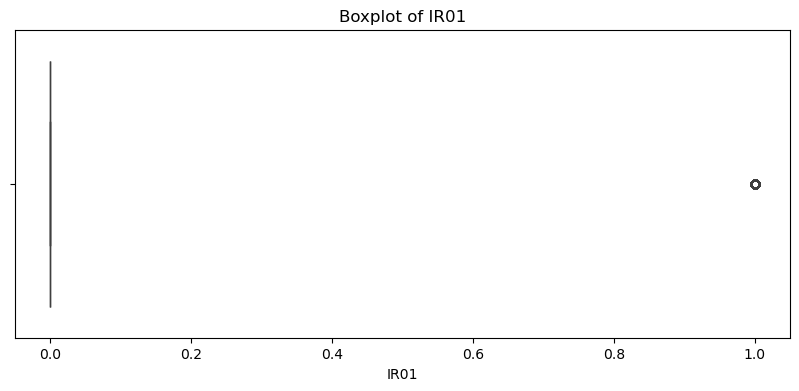

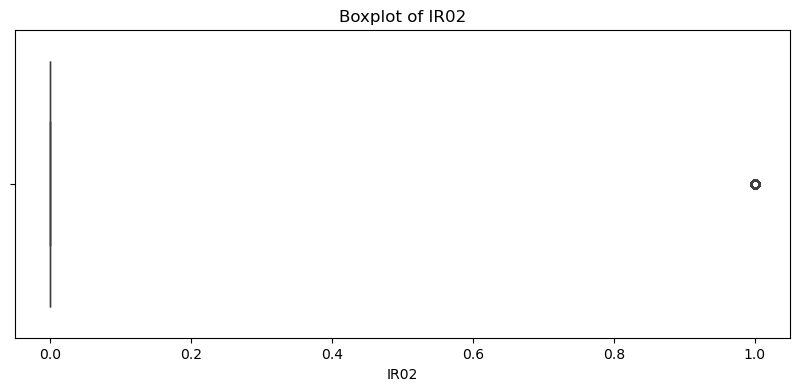

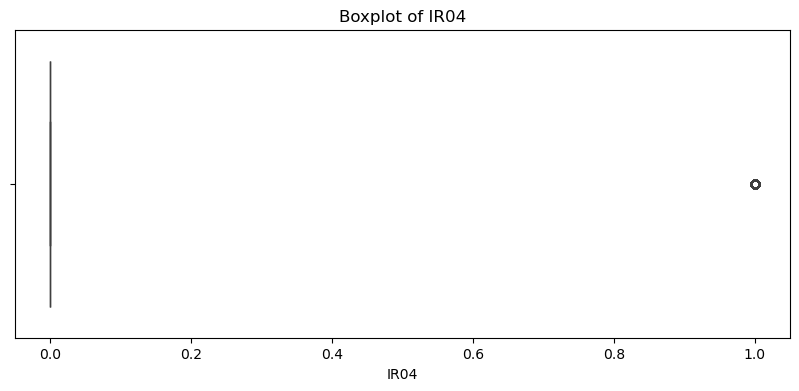

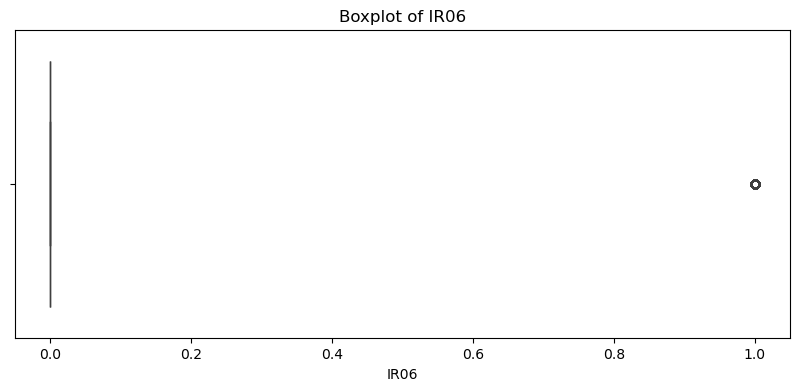

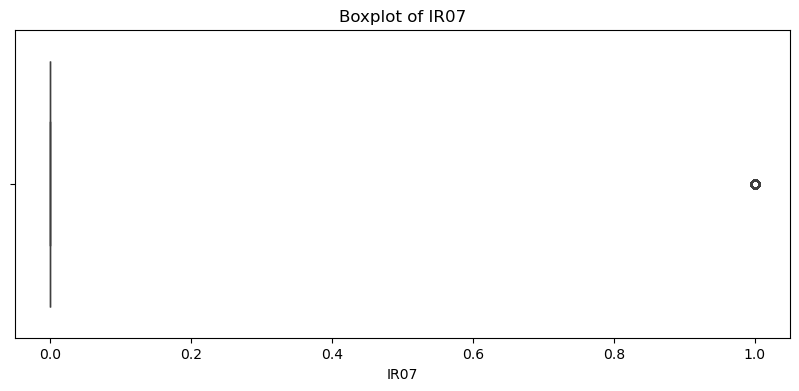

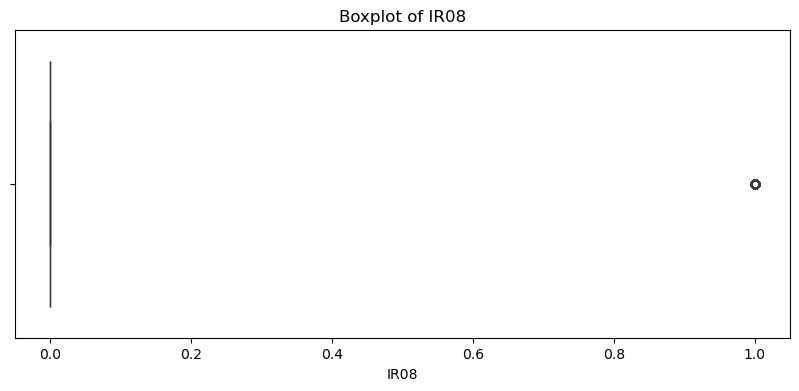

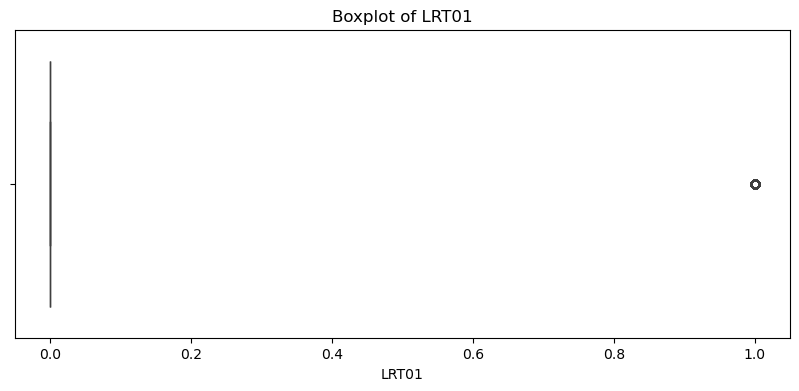

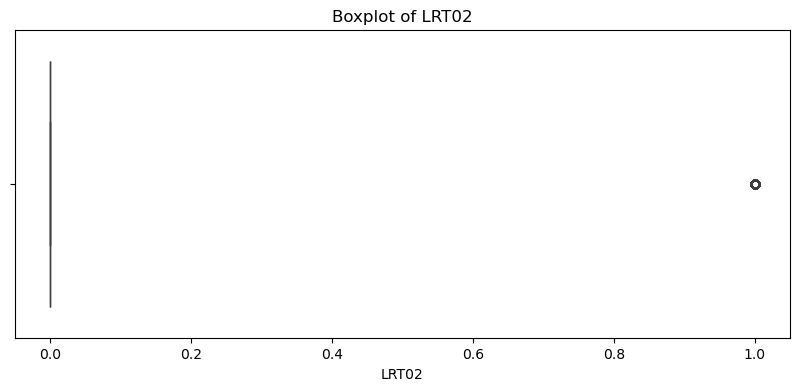

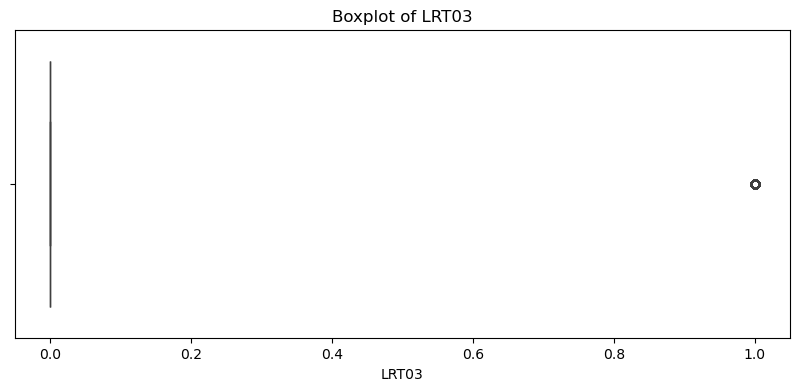

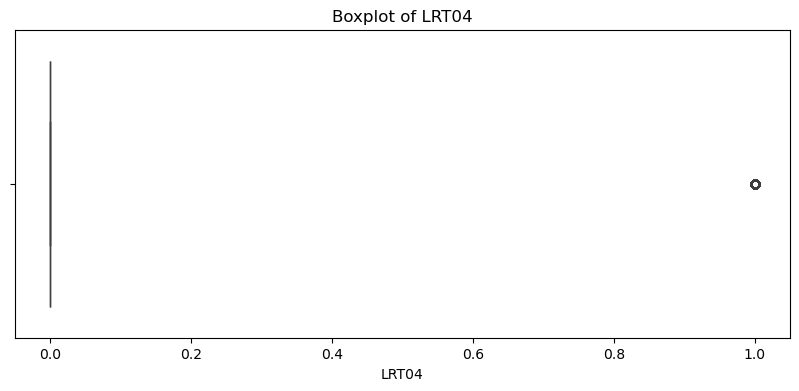

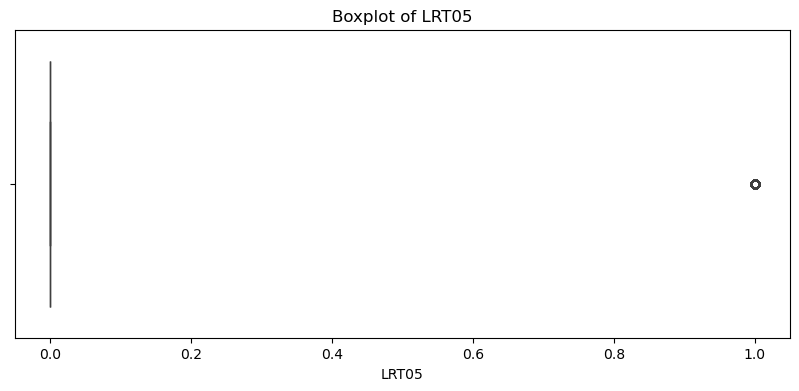

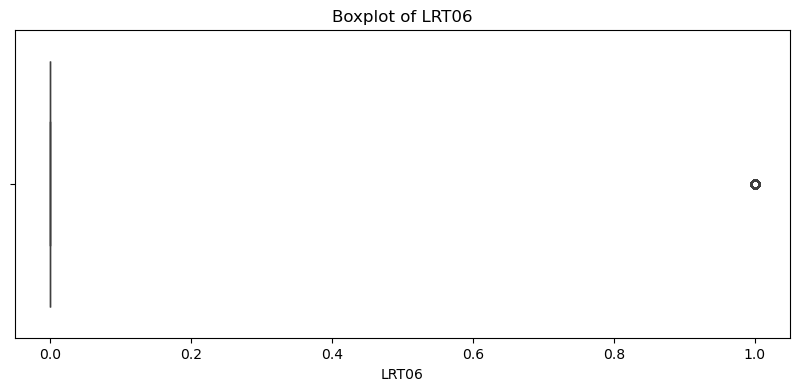

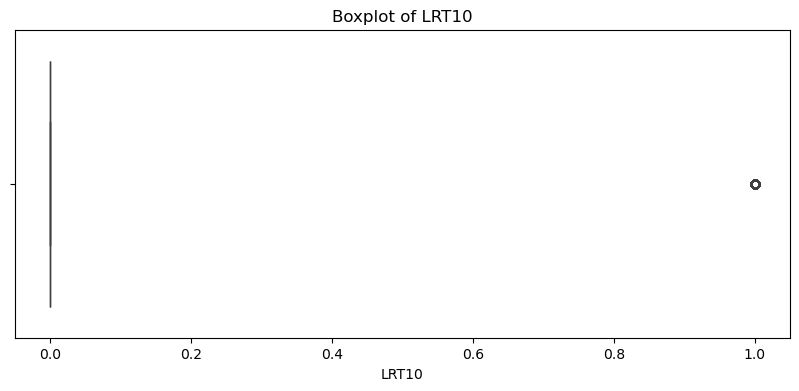

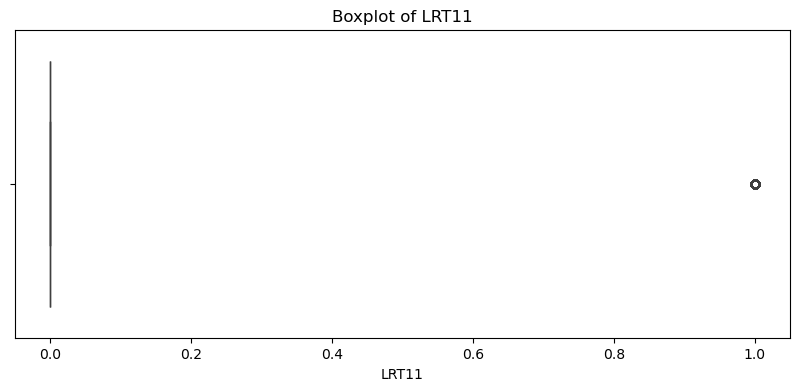

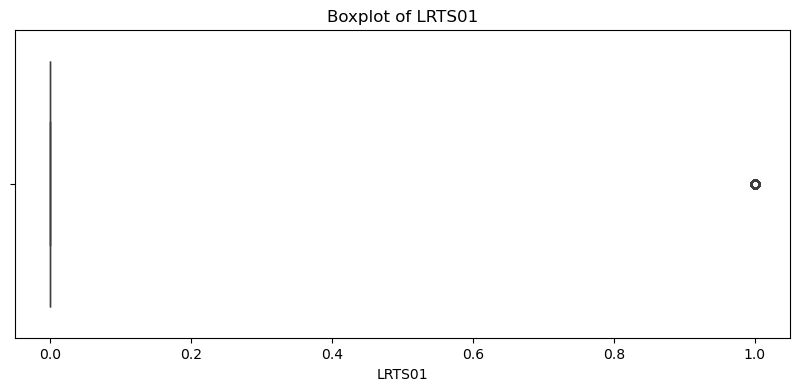

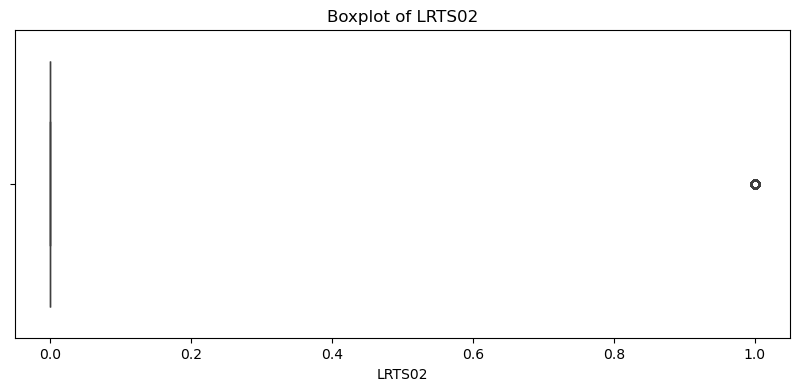

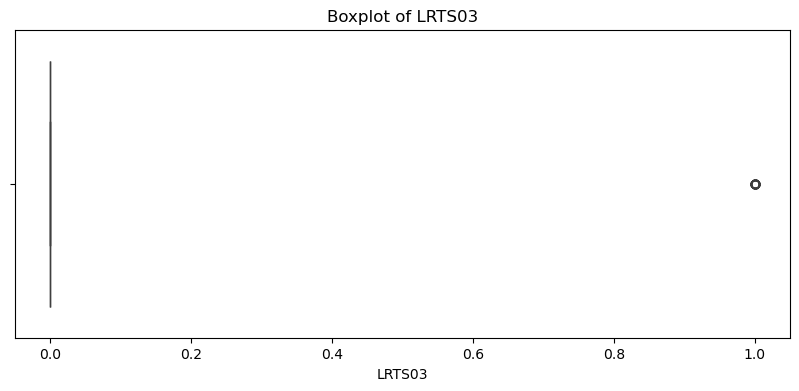

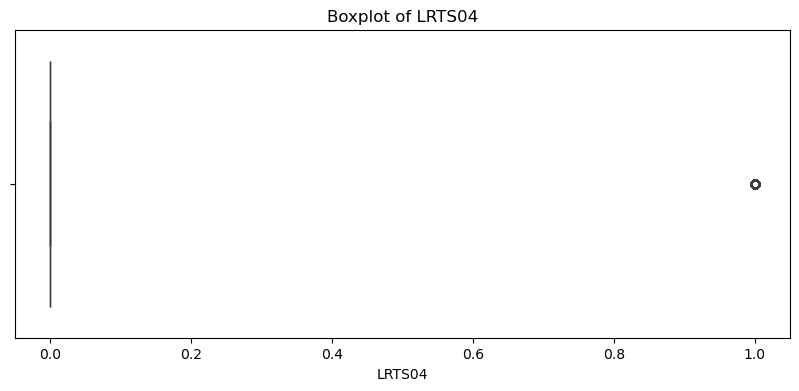

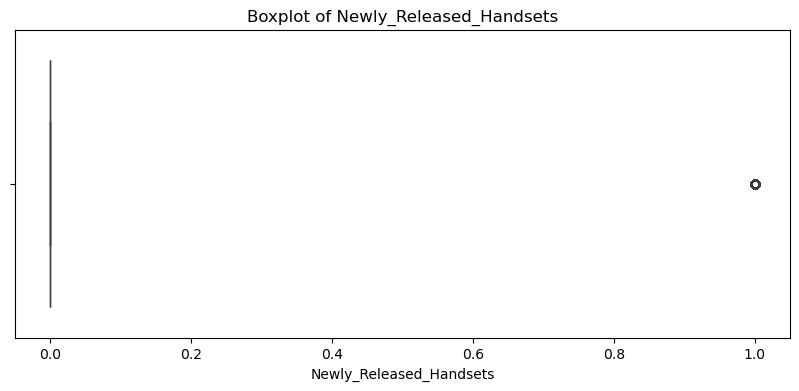

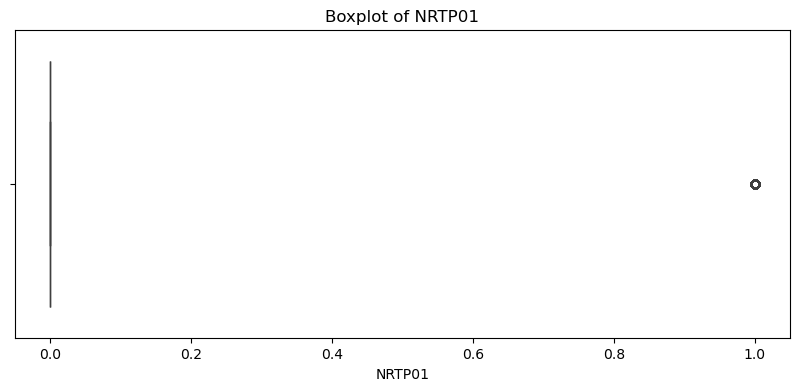

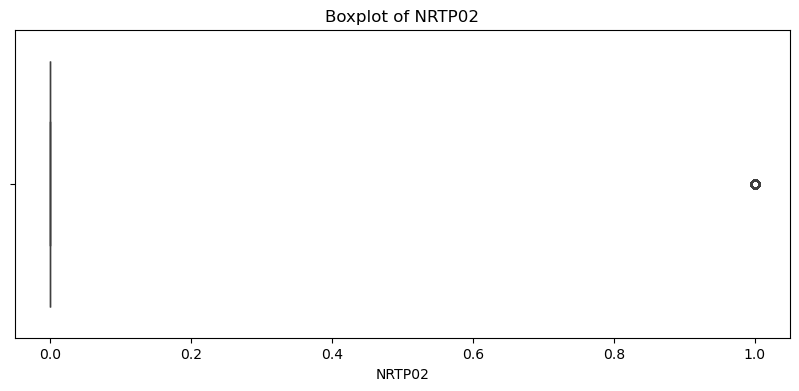

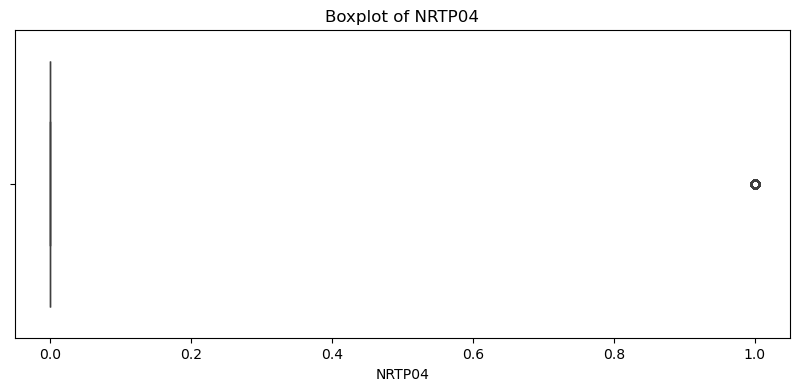

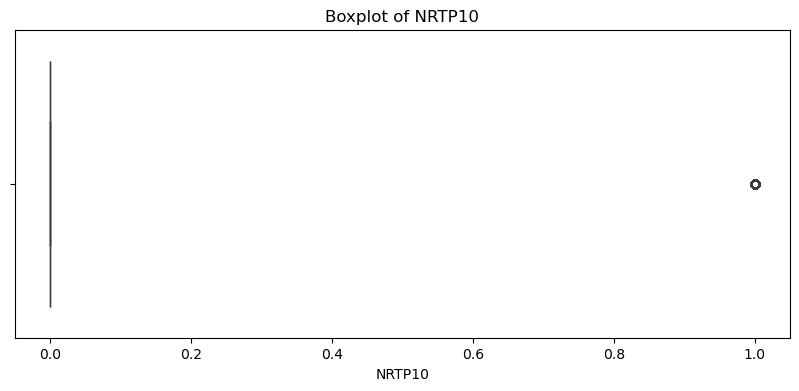

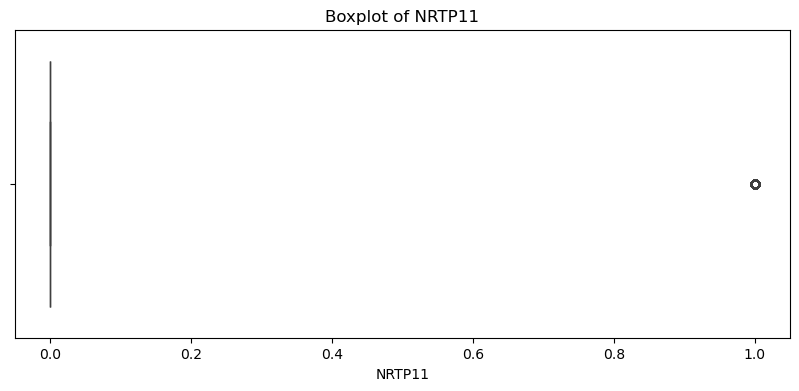

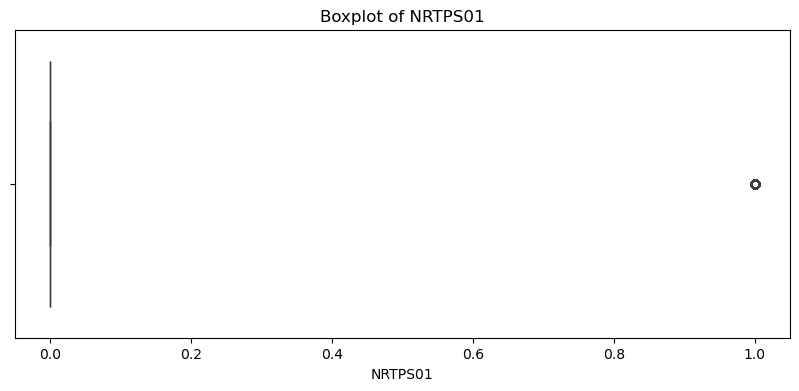

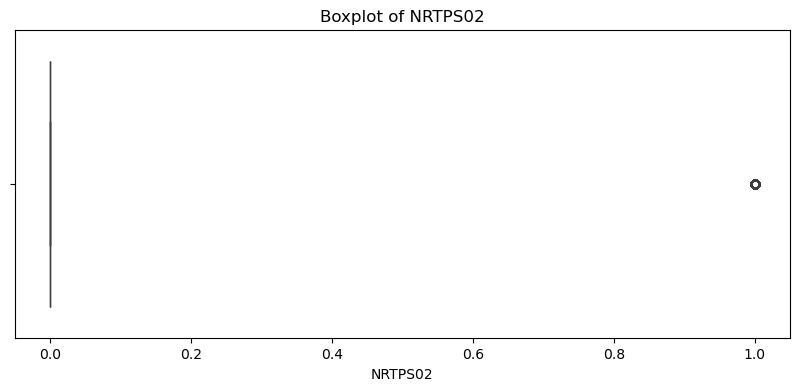

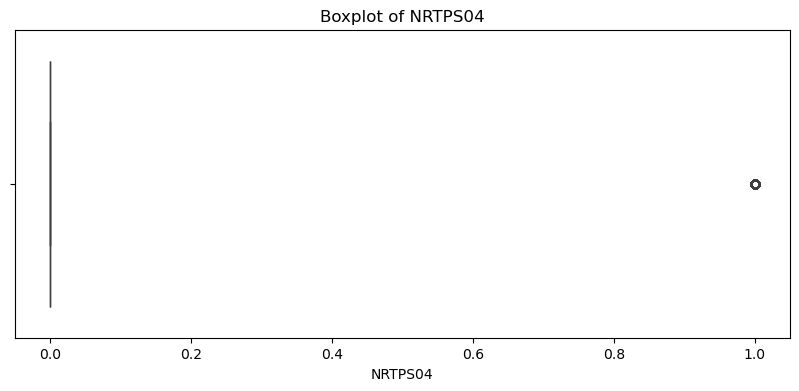

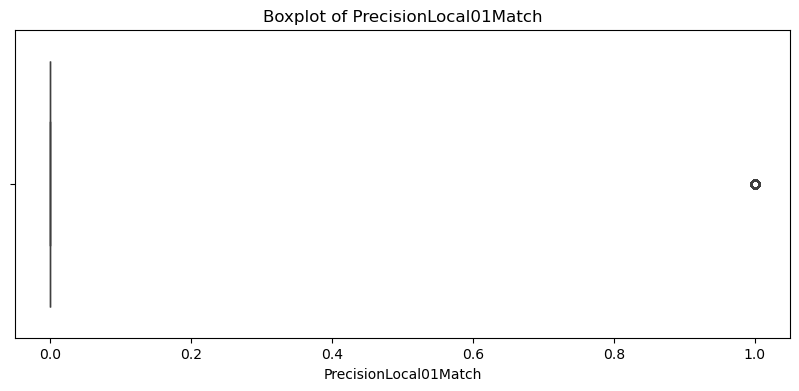

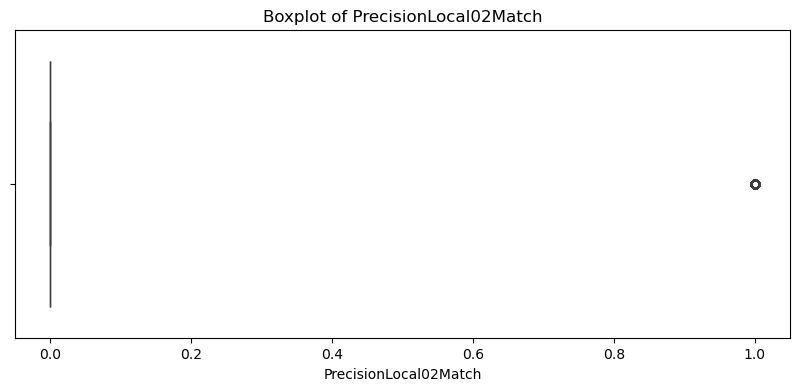

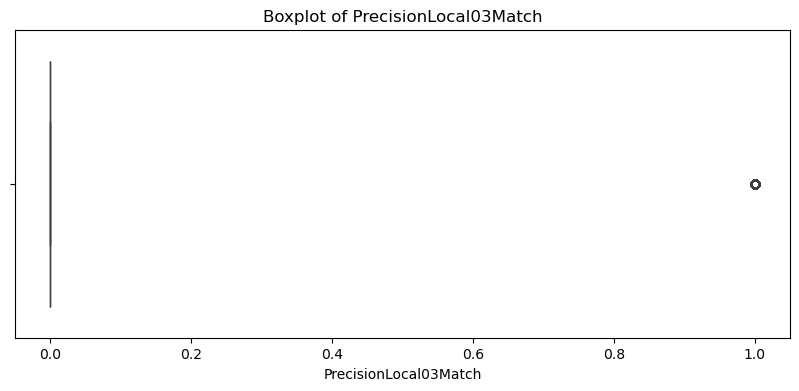

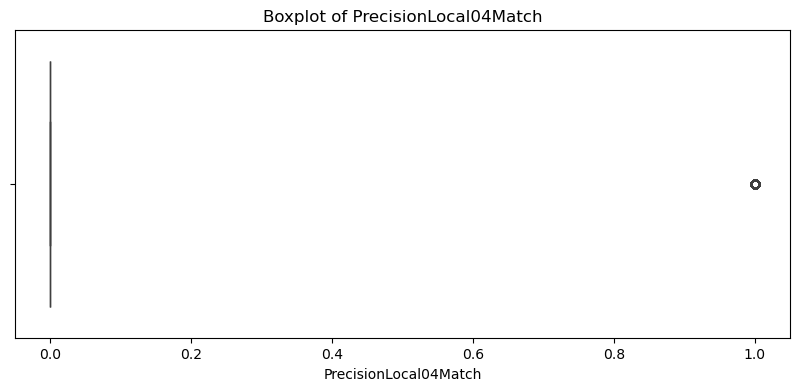

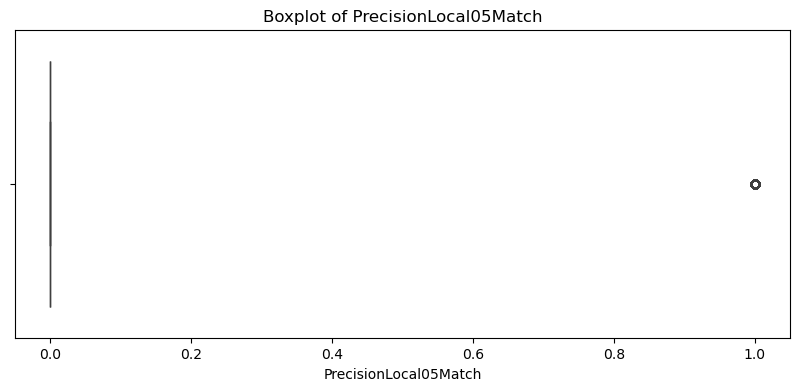

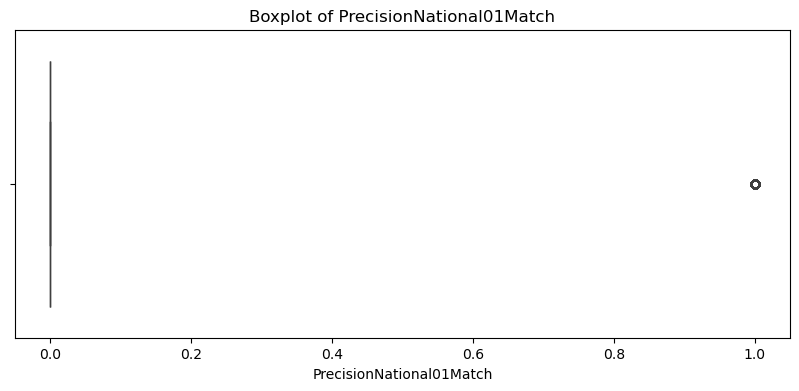

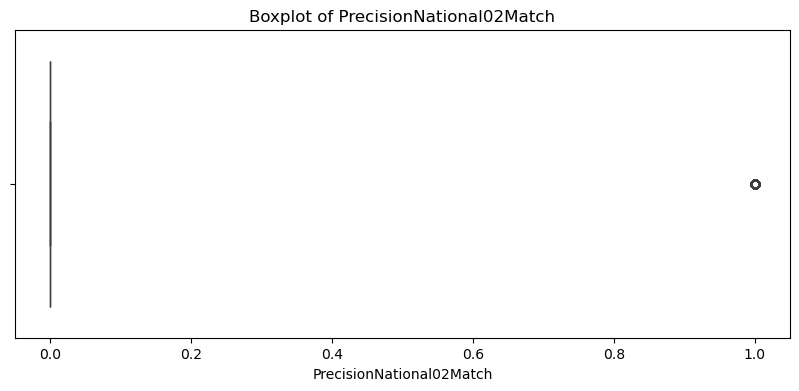

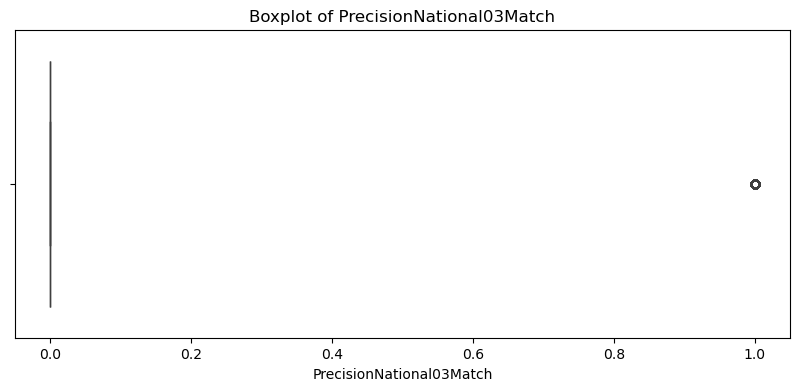

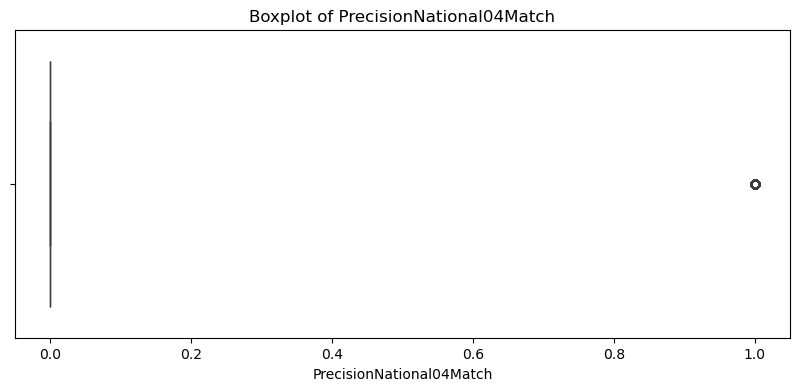

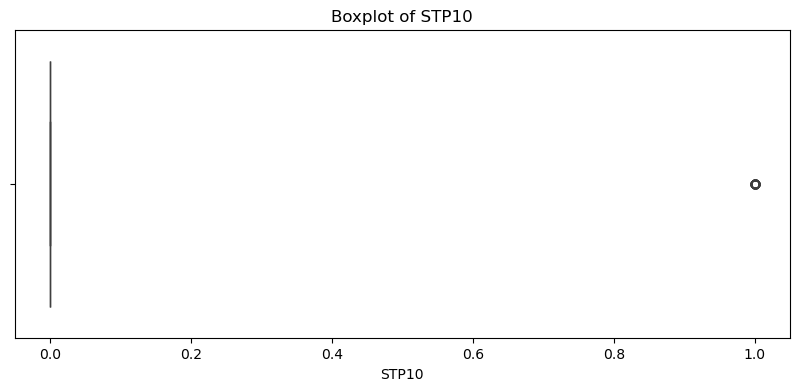

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fa09bc06170> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa074f05000> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [11]:
# Perform a full EDA
# CAREFUL - saves lots of plots (change behaviour?)
pipeline.perform_eda(df, save_plots=True)

# Or, use individual functions for specific analyses
#print(pipeline.summarize_data(data))
#pipeline.plot_histograms(data, save_plots=True)

### Preprocessing

In [11]:
# Remove all columns not to be used for modelling, except for ENQUIRY_KEY and TVH_PARTITION, which will be removed below.
df2 = df.drop(["EXTERNAL_UID", "APPLICATION_DATE", "CURRENT_ACTION_STATUS", "WORKED", "RULE_HIT"], axis=1)

In [12]:
df2.head()

ENQUIRY_KEY  MODEL_TARGET  TVH_PARTITION  \
0  557033E0-A77D-48E9-B75C-AE04010B3B30             0              1   
1  1DE2F5E9-0B7D-4835-9CF5-AE04010B919C             0              1   
2  1EB79CF5-0085-42FA-9E36-AE04010BD1C2             0              1   
3  74A87770-A437-4484-BE82-AE04010C07EA             0              1   
4  8FF2995B-58C8-40FA-97A9-AE04010D27D6             0              1   

   CoverClaimStartDateDiffUnder90  CoverClaimStartDateDiffAround12Months  \
0                               1                                      0   
1                               0                                      0   
2                               0                                      0   
3                               1                                      0   
4                               1                                      0   

   CoverClaimStartDateDiffAround2Months  CoverIncidentDateDiffLessThan30  \
0                                     1                                0   
1                                     1                                0   
2                                     1                                0   
3                                     1                                1   
4                                     1                                0   

   IncidentCreateDateDiff ClaimTypeCode  AgeAtApplicationPTK652  \
0                       0          loss                    37.0   
1                       0          loss                    57.0   
2                       2          loss                    38.0   
3                       2         theft                    38.0   
4                       7          loss                    25.0   

   YoungClaimant  HIGH_RISK_FORENAME  E_E_Identifier  ASIAN_Identifier  \
0              0                   0               0                 0   
1              0                   0               0                 0   
2              0                   0               0                 0   
3              0                   0               0                 0   
4              0                   0               0                 0   

   Cur_Del_AddressLine7_DIFF RegionPTK652ATK1 RegionPTK652ATK315  \
0                          0    EAST MIDLANDS                NaN   
1                          1       NORTH WEST                NaN   
2                          0   GREATER LONDON     GREATER LONDON   
3                          0       SOUTH EAST                NaN   
4                          0    WEST MIDLANDS                NaN   

   FirstTwoPostcodePTK652ATK1_GROUPED  FirstTwoPostcodePTK652ATK315_GROUPED  \
0                                   2                                     1   
1                                   2                                     1   
2                                   2                                     2   
3                                   3                                     1   
4                                   3                                     1   

  FirstTwoPostcodePTK652ATK1_NW_BANDING FirstTwoPostcodePTK1ATK315_NW_BANDING  \
0                              LOW_RISK                          NOT_PROVIDED   
1                           MEDIUM_RISK                          NOT_PROVIDED   
2                           MEDIUM_RISK                           MEDIUM_RISK   
3                              LOW_RISK                          NOT_PROVIDED   
4                              LOW_RISK                          NOT_PROVIDED   

   AddressDistance_PTK1ATK1PTK1ATK315                     COUNTY_PTK1ATK1  \
0                                 NaN                      LEICESTERSHIRE   
1                                 NaN                          LANCASHIRE   
2                                 0.0                      GREATER LONDON   
3                                 NaN             KENT AND GREATER LONDON   
4                                 NaN  WORCESTERSHIRE AND GLOUCESTERSHIRE   


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163984 entries, 0 to 163983
Data columns (total 93 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   ENQUIRY_KEY                                  163984 non-null  object 
 1   MODEL_TARGET                                 163984 non-null  int64  
 2   TVH_PARTITION                                163984 non-null  int64  
 3   CoverClaimStartDateDiffUnder90               163984 non-null  int64  
 4   CoverClaimStartDateDiffAround12Months        163984 non-null  int64  
 5   CoverClaimStartDateDiffAround2Months         163984 non-null  int64  
 6   CoverIncidentDateDiffLessThan30              163984 non-null  int64  
 7   IncidentCreateDateDiff                       163984 non-null  int64  
 8   ClaimTypeCode                                163984 non-null  object 
 9   AgeAtApplicationPTK652                       162161 non-nul

In [14]:
# Remove columns with only one unique value (including nulls)
df2 = df2.loc[:, df.nunique(dropna=False) > 1]
print("Columns with only one unique value:\n", df.columns[df.nunique(dropna=False) == 1].tolist())

Columns with only one unique value:
 ['APPLICATION_DATE']


In [14]:
# ^^^ why does app date contain only one unique value??

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163984 entries, 0 to 163983
Data columns (total 93 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   ENQUIRY_KEY                                  163984 non-null  object 
 1   MODEL_TARGET                                 163984 non-null  int64  
 2   TVH_PARTITION                                163984 non-null  int64  
 3   CoverClaimStartDateDiffUnder90               163984 non-null  int64  
 4   CoverClaimStartDateDiffAround12Months        163984 non-null  int64  
 5   CoverClaimStartDateDiffAround2Months         163984 non-null  int64  
 6   CoverIncidentDateDiffLessThan30              163984 non-null  int64  
 7   IncidentCreateDateDiff                       163984 non-null  int64  
 8   ClaimTypeCode                                163984 non-null  object 
 9   AgeAtApplicationPTK652                       162161 non-nul

In [15]:
# Convert all DataFrame column names to upper case
df2.columns = [col.upper() for col in df2.columns]

# Check for model_target and tvh_partition in df. If absent, raise error
required_columns = ['MODEL_TARGET', 'TVH_PARTITION']

# Check if required columns are in the DataFrame
if not all(col in df2.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in df2.columns]
    raise ValueError(f"Missing required columns: {missing_cols}")

In [16]:
# If MODEL_TARGET contains any values other than 0 or 1, raise an error.
if df2['MODEL_TARGET'].isin([0, 1]).all() == False:
    raise ValueError("MODEL_TARGET contains invalid values (not 0 or 1).")

In [17]:
# Convert 'MODEL_TARGET' and 'TVH_PARTITION' columns to integer
df2['MODEL_TARGET'] = df2['MODEL_TARGET'].astype(int)
df2['TVH_PARTITION'] = df2['TVH_PARTITION'].astype(int)

In [18]:
df_high_card, high_card_cols = pipeline.drop_high_cardinality_columns(df2, max_unique_values=100)
print("High cardinality columns: \n", high_card_cols)

High cardinality columns: 
 []


In [19]:
df_high_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163984 entries, 0 to 163983
Data columns (total 93 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   ENQUIRY_KEY                                  163984 non-null  object 
 1   MODEL_TARGET                                 163984 non-null  int64  
 2   TVH_PARTITION                                163984 non-null  int64  
 3   COVERCLAIMSTARTDATEDIFFUNDER90               163984 non-null  int64  
 4   COVERCLAIMSTARTDATEDIFFAROUND12MONTHS        163984 non-null  int64  
 5   COVERCLAIMSTARTDATEDIFFAROUND2MONTHS         163984 non-null  int64  
 6   COVERINCIDENTDATEDIFFLESSTHAN30              163984 non-null  int64  
 7   INCIDENTCREATEDATEDIFF                       163984 non-null  int64  
 8   CLAIMTYPECODE                                163984 non-null  object 
 9   AGEATAPPLICATIONPTK652                       162161 non-nul

In [26]:
df = pipeline.remove_date_columns(df) # NOT WORKING - when working, ensure correct DataFrame being passed! At the moment, "df", not "df_high_card" is being passed.

/root/Cloud_POC/pipeline.py:123: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  except (ValueError, TypeError):


In [20]:
# Split data into train, validation and test sets
train_df = df_high_card[df_high_card['TVH_PARTITION'] == 1]
validation_df = df_high_card[df_high_card['TVH_PARTITION'] == 2]
test_df = df_high_card[df_high_card['TVH_PARTITION'] == 3] # ADD value of 4 in future update!

print("Training set shape (rows, columns):", train_df.shape)
print("Validation set shape (rows, columns):", validation_df.shape)
print("Test set shape (rows, columns):", test_df.shape)

Training set shape (rows, columns): (120382, 93)
Validation set shape (rows, columns): (6945, 93)
Test set shape (rows, columns): (23342, 93)


In [21]:
df_high_card[df_high_card['TVH_PARTITION'] == 1].head()

ENQUIRY_KEY  MODEL_TARGET  TVH_PARTITION  \
0  557033E0-A77D-48E9-B75C-AE04010B3B30             0              1   
1  1DE2F5E9-0B7D-4835-9CF5-AE04010B919C             0              1   
2  1EB79CF5-0085-42FA-9E36-AE04010BD1C2             0              1   
3  74A87770-A437-4484-BE82-AE04010C07EA             0              1   
4  8FF2995B-58C8-40FA-97A9-AE04010D27D6             0              1   

   COVERCLAIMSTARTDATEDIFFUNDER90  COVERCLAIMSTARTDATEDIFFAROUND12MONTHS  \
0                               1                                      0   
1                               0                                      0   
2                               0                                      0   
3                               1                                      0   
4                               1                                      0   

   COVERCLAIMSTARTDATEDIFFAROUND2MONTHS  COVERINCIDENTDATEDIFFLESSTHAN30  \
0                                     1                                0   
1                                     1                                0   
2                                     1                                0   
3                                     1                                1   
4                                     1                                0   

   INCIDENTCREATEDATEDIFF CLAIMTYPECODE  AGEATAPPLICATIONPTK652  \
0                       0          loss                    37.0   
1                       0          loss                    57.0   
2                       2          loss                    38.0   
3                       2         theft                    38.0   
4                       7          loss                    25.0   

   YOUNGCLAIMANT  HIGH_RISK_FORENAME  E_E_IDENTIFIER  ASIAN_IDENTIFIER  \
0              0                   0               0                 0   
1              0                   0               0                 0   
2              0                   0               0                 0   
3              0                   0               0                 0   
4              0                   0               0                 0   

   CUR_DEL_ADDRESSLINE7_DIFF REGIONPTK652ATK1 REGIONPTK652ATK315  \
0                          0    EAST MIDLANDS                NaN   
1                          1       NORTH WEST                NaN   
2                          0   GREATER LONDON     GREATER LONDON   
3                          0       SOUTH EAST                NaN   
4                          0    WEST MIDLANDS                NaN   

   FIRSTTWOPOSTCODEPTK652ATK1_GROUPED  FIRSTTWOPOSTCODEPTK652ATK315_GROUPED  \
0                                   2                                     1   
1                                   2                                     1   
2                                   2                                     2   
3                                   3                                     1   
4                                   3                                     1   

  FIRSTTWOPOSTCODEPTK652ATK1_NW_BANDING FIRSTTWOPOSTCODEPTK1ATK315_NW_BANDING  \
0                              LOW_RISK                          NOT_PROVIDED   
1                           MEDIUM_RISK                          NOT_PROVIDED   
2                           MEDIUM_RISK                           MEDIUM_RISK   
3                              LOW_RISK                          NOT_PROVIDED   
4                              LOW_RISK                          NOT_PROVIDED   

   ADDRESSDISTANCE_PTK1ATK1PTK1ATK315                     COUNTY_PTK1ATK1  \
0                                 NaN                      LEICESTERSHIRE   
1                                 NaN                          LANCASHIRE   
2                                 0.0                      GREATER LONDON   
3                                 NaN             KENT AND GREATER LONDON   
4                                 NaN  WORCESTERSHIRE AND GLOUCESTERSHIRE   


In [22]:
train_undersampled = pipeline.undersample_classification_task(train_df, ds_ratio)
print("Shape of undersampled training set (rows, columns): ", train_undersampled.shape)

# Number of columns in undersampled training set must be the same as in the original training set
assert train_undersampled.shape[1] == train_df.shape[1], f"Number of columns must be the same: {train_undersampled.shape[1]}, {train_df.shape[1]}"

/root/Cloud_POC/pipeline.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_index'] = df.index


Shape of undersampled training set (rows, columns):  (95764, 93)


/root/Cloud_POC/pipeline.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('original_index', axis=1, inplace=True)


In [24]:
train_undersampled.shape[1]

93

In [25]:
train_df.shape[1]

93

In [26]:
train_undersampled.head()

ENQUIRY_KEY  MODEL_TARGET  TVH_PARTITION  \
1  1DE2F5E9-0B7D-4835-9CF5-AE04010B919C             0              1   
2  1EB79CF5-0085-42FA-9E36-AE04010BD1C2             0              1   
5  34ECD07F-0C8B-4958-AE3B-AE04010D49E9             0              1   
7  10613AB7-A65E-4A49-BCE0-AE04010EADA1             0              1   
8  F488C8CE-5609-4F2A-9A1D-AE04010EBB8B             1              1   

   COVERCLAIMSTARTDATEDIFFUNDER90  COVERCLAIMSTARTDATEDIFFAROUND12MONTHS  \
1                               0                                      0   
2                               0                                      0   
5                               1                                      0   
7                               1                                      0   
8                               0                                      0   

   COVERCLAIMSTARTDATEDIFFAROUND2MONTHS  COVERINCIDENTDATEDIFFLESSTHAN30  \
1                                     1                                0   
2                                     1                                0   
5                                     1                                1   
7                                     1                                0   
8                                     1                                0   

   INCIDENTCREATEDATEDIFF CLAIMTYPECODE  AGEATAPPLICATIONPTK652  \
1                       0          loss                    57.0   
2                       2          loss                    38.0   
5                       0          loss                    48.0   
7                       1          loss                    35.0   
8                       0          loss                    29.0   

   YOUNGCLAIMANT  HIGH_RISK_FORENAME  E_E_IDENTIFIER  ASIAN_IDENTIFIER  \
1              0                   0               0                 0   
2              0                   0               0                 0   
5              0                   0               0                 0   
7              0                   0               0                 0   
8              0                   0               0                 1   

   CUR_DEL_ADDRESSLINE7_DIFF REGIONPTK652ATK1 REGIONPTK652ATK315  \
1                          1       NORTH WEST                NaN   
2                          0   GREATER LONDON     GREATER LONDON   
5                          1       SOUTH EAST                NaN   
7                          0       SOUTH EAST                NaN   
8                          0   GREATER LONDON     GREATER LONDON   

   FIRSTTWOPOSTCODEPTK652ATK1_GROUPED  FIRSTTWOPOSTCODEPTK652ATK315_GROUPED  \
1                                   2                                     1   
2                                   2                                     2   
5                                   2                                     1   
7                                   3                                     1   
8                                   1                                     1   

  FIRSTTWOPOSTCODEPTK652ATK1_NW_BANDING FIRSTTWOPOSTCODEPTK1ATK315_NW_BANDING  \
1                           MEDIUM_RISK                          NOT_PROVIDED   
2                           MEDIUM_RISK                           MEDIUM_RISK   
5                              LOW_RISK                          NOT_PROVIDED   
7                              LOW_RISK                          NOT_PROVIDED   
8                        VERY_HIGH_RISK                        VERY_HIGH_RISK   

   ADDRESSDISTANCE_PTK1ATK1PTK1ATK315 COUNTY_PTK1ATK1 COUNTY_PTK1ATK315  \
1                                 NaN      LANCASHIRE               NaN   
2                                 0.0  GREATER LONDON    GREATER LONDON   
5                                 NaN  GREATER LONDON               NaN   
7                                 NaN       BERKSHIRE               NaN   
8                                 0.0  GREATER LONDON    GREATER LONDON   

   SHORTEMA

In [27]:
train_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95764 entries, 1 to 161940
Data columns (total 93 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ENQUIRY_KEY                                  95764 non-null  object 
 1   MODEL_TARGET                                 95764 non-null  int64  
 2   TVH_PARTITION                                95764 non-null  int64  
 3   COVERCLAIMSTARTDATEDIFFUNDER90               95764 non-null  int64  
 4   COVERCLAIMSTARTDATEDIFFAROUND12MONTHS        95764 non-null  int64  
 5   COVERCLAIMSTARTDATEDIFFAROUND2MONTHS         95764 non-null  int64  
 6   COVERINCIDENTDATEDIFFLESSTHAN30              95764 non-null  int64  
 7   INCIDENTCREATEDATEDIFF                       95764 non-null  int64  
 8   CLAIMTYPECODE                                95764 non-null  object 
 9   AGEATAPPLICATIONPTK652                       94465 non-null  float64
 10  YO

In [50]:
# Define local file paths
train_path = f'/home/sagemaker-user/Precision 3.0/train_Assurant_DS_{ds_ratio}.csv'
validation_path = f'/home/sagemaker-user/Precision 3.0/validation_Assurant_DS_{ds_ratio}.csv'
test_path = f'/home/sagemaker-user/Precision 3.0/test_Assurant_DS_{ds_ratio}.csv'

train_identifiers_path = f'/home/sagemaker-user/Precision 3.0/train_identifiers_Assurant_DS_{ds_ratio}.csv'
validation_identifiers_path = f'/home/sagemaker-user/Precision 3.0/validation_identifiers_Assurant_DS_{ds_ratio}.csv'
test_identifiers_path = f'/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant_DS_{ds_ratio}.csv'

In [24]:
# Save feature data for modelling (excluding ENQUIRY_KEY and TVH_PARTITION)
# Shuffle training - randomly sample all rows in the undersampled training set, then reset the index, then drop the original index, 
# otherwise it will be a separate column in each dataset.
train_undersampled_shuffled = train_undersampled.sample(frac=1).reset_index(drop=True)

train_undersampled_shuffled.drop(['ENQUIRY_KEY', 'TVH_PARTITION'], axis=1).to_csv(train_path, index=False)
validation_df.drop(['ENQUIRY_KEY', 'TVH_PARTITION'], axis=1).to_csv(validation_path, index=False)
test_df.drop(['ENQUIRY_KEY', 'TVH_PARTITION'], axis=1).to_csv(test_path, index=False)

# Save only the identifiers and target variable for later use
train_identifiers = train_undersampled_shuffled[['ENQUIRY_KEY', 'TVH_PARTITION', 'MODEL_TARGET']]
validation_identifiers = validation_df[['ENQUIRY_KEY', 'TVH_PARTITION', 'MODEL_TARGET']]
test_identifiers = test_df[['ENQUIRY_KEY', 'TVH_PARTITION', 'MODEL_TARGET']]

# Choose appropriate paths for saving the identifiers
train_identifiers.to_csv(train_identifiers_path, index=False)
validation_identifiers.to_csv(validation_identifiers_path, index=False)
test_identifiers.to_csv(test_identifiers_path, index=False)

#### OPTIONAL (run if you want to load train, val and test without first running all previous steps, except for installs, imports and instantiation of global variables.)

##### Run if you want to load downsampled data

In [8]:
# Define local file paths
train_path = f'/home/sagemaker-user/Precision 3.0/train_Assurant_DS_{ds_ratio}.csv'
validation_path = f'/home/sagemaker-user/Precision 3.0/validation_Assurant_DS_{ds_ratio}.csv'
test_path = f'/home/sagemaker-user/Precision 3.0/test_Assurant_DS_{ds_ratio}.csv'

##### Run if you want to load original data

In [10]:
# Define local file paths
train_path = f'/home/sagemaker-user/Precision 3.0/train_Assurant.csv'
validation_path = f'/home/sagemaker-user/Precision 3.0/validation_Assurant.csv'
test_path = f'/home/sagemaker-user/Precision 3.0/test_Assurant.csv'

In [9]:
# Load the datasets
train_undersampled = pd.read_csv(train_path)
validation_df = pd.read_csv(validation_path)
test_df = pd.read_csv(test_path)

In [12]:
test_df

MODEL_TARGET  COVERCLAIMSTARTDATEDIFFUNDER90  \
0                 0                               0   
1                 0                               1   
2                 0                               0   
3                 0                               0   
4                 1                               0   
...             ...                             ...   
23337             0                               0   
23338             0                               0   
23339             0                               0   
23340             1                               1   
23341             1                               1   

       COVERCLAIMSTARTDATEDIFFAROUND12MONTHS  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          1   
...                                      ...   
23337                                      1   
23338                                      1   
23339                                      0   
23340                                      0   
23341                                      0   

       COVERCLAIMSTARTDATEDIFFAROUND2MONTHS  COVERINCIDENTDATEDIFFLESSTHAN30  \
0                                         0                                0   
1                                         1                                0   
2                                         0                                0   
3                                         0                                0   
4                                         0                                0   
...                                     ...                              ...   
23337                                     0                                0   
23338                                     0                                0   
23339                                     1                                0   
23340                                     1                                1   
23341                                     1                                0   

       INCIDENTCREATEDATEDIFF CLAIMTYPECODE  AGEATAPPLICATIONPTK652  \
0                           1          loss                    24.0   
1                           0          loss                    35.0   
2                           5          loss                    56.0   
3                           1          loss                    57.0   
4                           1          loss                    32.0   
...                       ...           ...                     ...   
23337                      28         theft                    33.0   
23338                      27          loss                    41.0   
23339                      82         theft                    22.0   
23340                      51         theft                    37.0   
23341                      92         theft                    25.0   

       YOUNGCLAIMANT  HIGH_RISK_FORENAME  E_E_IDENTIFIER  ASIAN_IDENTIFIER  \
0                  0                   0               0                 0   
1                  0                   0               0                 0   
2                  0                   0               1                 0   
3                  0                   0               0                 0   
4                  0                   0               0                 1   
...              ...                 ...             ...               ...   
23337              0                   0               0                 0   
23338              0                   0               0                 0   
23339              0                   0               0                 1   
23340              0                   0               0                 0   
23341              0                   0               0                 0   

       CUR_DEL_ADD

In [23]:
# Save DataFrames as csv files in local directory
#train_undersampled.to_csv(train_path, index=False)
#validation_df.to_csv(validation_path, index=False)
#test_df.to_csv(test_path, index=False)

In [24]:
# Define file names
train_file = f'{client_name}/train_Assurant_DS_{ds_ratio}.csv'
validation_file = f'{client_name}/validation_Assurant_DS_{ds_ratio}.csv'
test_file = f'{client_name}/test_Assurant_DS_{ds_ratio}.csv'

In [25]:
# Upload files
pipeline.upload_to_s3(train_path, bucket, train_file)
pipeline.upload_to_s3(validation_path, bucket, validation_file)
pipeline.upload_to_s3(test_path, bucket, test_file)


KeyboardInterrupt



In [10]:
# Delete df to save memory
del df

# Manually call garbage collector
gc.collect()

NameError: name 'df' is not defined

### Manual Hyperparameter Tuning

#### Preprocessing

In [10]:
# Define local file paths
train_path = f'/home/sagemaker-user/Precision 3.0/train_Assurant_DS_{ds_ratio}.csv'
validation_path = f'/home/sagemaker-user/Precision 3.0/validation_Assurant_DS_{ds_ratio}.csv'
test_path = f'/home/sagemaker-user/Precision 3.0/test_Assurant_DS_{ds_ratio}.csv'

train_identifiers_path = f'/home/sagemaker-user/Precision 3.0/train_identifiers_Assurant_DS_{ds_ratio}.csv'
validation_identifiers_path = f'/home/sagemaker-user/Precision 3.0/validation_identifiers_Assurant_DS_{ds_ratio}.csv'
test_identifiers_path = f'/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant_DS_{ds_ratio}.csv'

In [11]:
print("Loading training, validation and test data...")
train_data = pd.read_csv(train_path)
validation_data = pd.read_csv(validation_path)
test_data = pd.read_csv(test_path)
print("Data loaded.")

Loading training, validation and test data...
Data loaded.


In [12]:
print("Defining column types...")
numeric_columns = train_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist()
print("Column types defined.")
print(f'Number of numeric columns: {len(numeric_columns)} \n Numeric columns: {numeric_columns})')
print(f'Number of categorical columns: {len(categorical_columns)} \n categorical columns: {categorical_columns})')

Defining column types...
Column types defined.
Number of numeric columns: 67 
 Numeric columns: ['COVERCLAIMSTARTDATEDIFFUNDER90', 'COVERCLAIMSTARTDATEDIFFAROUND12MONTHS', 'COVERCLAIMSTARTDATEDIFFAROUND2MONTHS', 'COVERINCIDENTDATEDIFFLESSTHAN30', 'INCIDENTCREATEDATEDIFF', 'AGEATAPPLICATIONPTK652', 'YOUNGCLAIMANT', 'HIGH_RISK_FORENAME', 'E_E_IDENTIFIER', 'ASIAN_IDENTIFIER', 'CUR_DEL_ADDRESSLINE7_DIFF', 'FIRSTTWOPOSTCODEPTK652ATK1_GROUPED', 'FIRSTTWOPOSTCODEPTK652ATK315_GROUPED', 'ADDRESSDISTANCE_PTK1ATK1PTK1ATK315', 'SHORTEMAILADDRESS', 'EMAILADDRESSLENGTH', 'MAILBOXLENGTH', 'BADEMAILCLIENTLIST', 'WORKPHONESTANDARDPRESENT', 'LANDLINESTANDARDPRESENT', 'LANDLINENONSTANDARD', 'CMRT0012', 'CMRT0013', 'CMRT002', 'CMRT014', 'CMRT015', 'CMRT03', 'HIGH_RISK_HANDSETS', 'HIGH_VALUE_HANDSETS', 'IMEI03', 'IR01', 'IR02', 'IR04', 'IR06', 'IR07', 'IR08', 'LRT01', 'LRT02', 'LRT03', 'LRT04', 'LRT05', 'LRT06', 'LRT10', 'LRT11', 'LRTS01', 'LRTS02', 'LRTS03', 'LRTS04', 'NEWLY_RELEASED_HANDSETS', 'NRTP01', 

In [13]:
# Debugging step 2: Ensure 'MODEL_TARGET' is not dropped
if 'MODEL_TARGET' not in train_data.columns:
    raise ValueError("'MODEL_TARGET' column not found in training data")
if 'MODEL_TARGET' not in validation_data.columns:
    raise ValueError("'MODEL_TARGET' column not found in validation data")

In [14]:
print("Preparing training data...")
X_train = train_data.drop('MODEL_TARGET', axis=1)
y_train = train_data['MODEL_TARGET']
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")

Preparing training data...
Shape of X_train: (95764, 90), Shape of y_train: (95764,)


In [15]:
print("Preparing validation data...")
X_validation = validation_data.drop('MODEL_TARGET', axis=1)
y_validation = validation_data['MODEL_TARGET']
print(f"Shape of X_validation: {X_validation.shape}, Shape of y_validation: {y_validation.shape}")

Preparing validation data...
Shape of X_validation: (6945, 90), Shape of y_validation: (6945,)


In [16]:
print("Preparing test data...")
X_test = test_data.drop('MODEL_TARGET', axis=1)
y_test = test_data['MODEL_TARGET']
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Preparing test data...
Shape of X_test: (23342, 90), Shape of y_test: (23342,)


### Pipeline from model_pipeline.py

In [17]:
# Transform X_train using the preprocessor
def preprocess_multi_model(algorithm: str, data: pd.DataFrame, preprocessor: sklearn.compose._column_transformer.ColumnTransformer, partition: str):
    if partition == 'train': # then fit the preprocessor to the data before transforming it
        logger.info(f'Preprocessing training data for {algorithm}.')   
        if algorithm == 'catboost':
            # Separate X_train into numerical and categorical data
            data_numeric = data[numeric_columns]
            data_categorical = data[categorical_columns]

            # Access numeric transformer from preprocessor
            numeric_transformer = preprocessor.named_transformers_['num']
            # Apply preprocessing to numerical data
            data_numeric_preprocessed = numeric_transformer.fit_transform(data_numeric)

            # Convert categorical data to strings if they are not already
            data_categorical = data_categorical.astype(str)

            # Combine preprocessed numerical and categorical data
            data_combined = np.hstack([data_numeric_preprocessed, data_categorical])

            # The categorical features are now the last columns in X_train_combined
            # So, return the indices of the features occuring after the numeric features in ascending order 
            cat_features_indices = list(range(data_numeric_preprocessed.shape[1], data_combined.shape[1]))
            logger.info('Data preprocessed.')
            return data_combined, cat_features_indices 
        else:
            data_preprocessed = preprocessor.fit_transform(data)
            logger.info('Data preprocessed.')
            return data_preprocessed, None # Return two variables to ensure consistency with CatBoost option
    else: # for validation and test sets, just transform the data
        logger.info(f'Preprocessing {partition} data for {algorithm}.') 
        if algorithm == 'catboost':
            # Separate X_train into numerical and categorical data
            data_numeric = data[numeric_columns]
            data_categorical = data[categorical_columns]

            # Access numeric transformer from preprocessor
            numeric_transformer = preprocessor.named_transformers_['num']
            # Apply preprocessing to numerical data
            data_numeric_preprocessed = numeric_transformer.transform(data_numeric)

            # Convert categorical data to strings if they are not already
            data_categorical = data_categorical.astype(str)

            # Combine preprocessed numerical and categorical data
            data_combined = np.hstack([data_numeric_preprocessed, data_categorical])

            # The categorical features are now the last columns in X_train_combined
            # So, return the indices of the features occuring after the numeric features in ascending order 
            cat_features_indices = list(range(data_numeric_preprocessed.shape[1], data_combined.shape[1]))
            logger.info('Data preprocessed.')
            return data_combined, cat_features_indices 
        else:
            data_preprocessed = preprocessor.transform(data)
            logger.info('Data preprocessed.')
            return data_preprocessed, None # Return two variables to ensure consistency with CatBoost option
        
#print(f"Shape of X_train_preprocessed: {X_train_preprocessed.shape}")

In [18]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [19]:
print("Defining column types...")
numeric_columns = train_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist()
print("Column types defined.")
print(f'Number of numeric columns: {len(numeric_columns)} \n Numeric columns: {numeric_columns})')
print(f'Number of categorical columns: {len(categorical_columns)} \n categorical columns: {categorical_columns})')

Defining column types...
Column types defined.
Number of numeric columns: 67 
 Numeric columns: ['COVERCLAIMSTARTDATEDIFFUNDER90', 'COVERCLAIMSTARTDATEDIFFAROUND12MONTHS', 'COVERCLAIMSTARTDATEDIFFAROUND2MONTHS', 'COVERINCIDENTDATEDIFFLESSTHAN30', 'INCIDENTCREATEDATEDIFF', 'AGEATAPPLICATIONPTK652', 'YOUNGCLAIMANT', 'HIGH_RISK_FORENAME', 'E_E_IDENTIFIER', 'ASIAN_IDENTIFIER', 'CUR_DEL_ADDRESSLINE7_DIFF', 'FIRSTTWOPOSTCODEPTK652ATK1_GROUPED', 'FIRSTTWOPOSTCODEPTK652ATK315_GROUPED', 'ADDRESSDISTANCE_PTK1ATK1PTK1ATK315', 'SHORTEMAILADDRESS', 'EMAILADDRESSLENGTH', 'MAILBOXLENGTH', 'BADEMAILCLIENTLIST', 'WORKPHONESTANDARDPRESENT', 'LANDLINESTANDARDPRESENT', 'LANDLINENONSTANDARD', 'CMRT0012', 'CMRT0013', 'CMRT002', 'CMRT014', 'CMRT015', 'CMRT03', 'HIGH_RISK_HANDSETS', 'HIGH_VALUE_HANDSETS', 'IMEI03', 'IR01', 'IR02', 'IR04', 'IR06', 'IR07', 'IR08', 'LRT01', 'LRT02', 'LRT03', 'LRT04', 'LRT05', 'LRT06', 'LRT10', 'LRT11', 'LRTS01', 'LRTS02', 'LRTS03', 'LRTS04', 'NEWLY_RELEASED_HANDSETS', 'NRTP01', 

In [20]:
# Create model pipeline
algorithm = 'logistic_regression'  # Change this to try different algorithms
use_grid_search = False  # Set True to use GridSearchCV, False for standard pipeline

# Generate training pipeline
training_pipeline = model_pipeline.create_pipeline(numeric_columns, categorical_columns, algorithm, use_grid_search=use_grid_search)

# Extract the preprocessor from the pipeline
preprocessor = training_pipeline.named_steps['preprocessor']

# Preprocess training data
X_train_preprocessed, cat_features_indices = preprocess_multi_model(algorithm, X_train, preprocessor, 'train')

# Preprocess validation data
X_val_preprocessed, _ = preprocess_multi_model(algorithm, X_validation, preprocessor, 'validation')

# Preprocess validation data
X_test_preprocessed, _ = preprocess_multi_model(algorithm, X_test, preprocessor, 'test')

# Extract the classifier from the pipeline
classifier = training_pipeline.named_steps['classifier']
#classifier = training_pipeline # for GridSearchCV

2025-04-23 08:51:12,195 - INFO - Creating optimized pipeline for algorithm: logistic_regression
2025-04-23 08:51:12,197 - INFO - Instantiated logistic_regression classifier
2025-04-23 08:51:12,198 - INFO - Creating transformers.
2025-04-23 08:51:12,198 - INFO - Creating preprocessor.
2025-04-23 08:51:12,199 - INFO - Creating pipeline.
2025-04-23 08:51:12,199 - INFO - Pipeline created successfully
2025-04-23 08:51:12,200 - INFO - Preprocessing training data for logistic_regression.
2025-04-23 08:51:14,446 - INFO - Data preprocessed.
2025-04-23 08:51:14,447 - INFO - Preprocessing validation data for logistic_regression.
2025-04-23 08:51:14,548 - INFO - Data preprocessed.
2025-04-23 08:51:14,549 - INFO - Preprocessing test data for logistic_regression.
2025-04-23 08:51:14,856 - INFO - Data preprocessed.


#### Training and Validation

2025-04-16 11:15:51,531 - INFO - Fitting the model...
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 23941, number of negative: 71823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 95764, number of used features: 618
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2025-04-16 11:15:54,896 - INFO - Making predictions on validation data...
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-16 11:15:54,991 - INFO - Accuracy: 0.8364290856731461
2025-04-16 11:15:54,992 - INFO - ROC AUC: 0.8213953277095049
2025-04-16 11:15:54,993 - INFO - Precision: 0.6501149425287356
2025-04-16 11:15:54,993 - INFO - Recall: 0.7903856903297932
2025-04-16 11:15:54,994 - INFO - F1 Score: 0.7134207870837538 



Model saved to /home/sagemaker-user/Precision 3.0/model_light_gbm_1_2025-04-16 11:15:54.pkl
Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      5156
           1       0.65      0.79      0.71      1789

    accuracy                           0.84      6945
   macro avg       0.79      0.82      0.80      6945
weighted avg       0.85      0.84      0.84      6945

Confusion Matrix:
[[4395  761]
 [ 375 1414]]


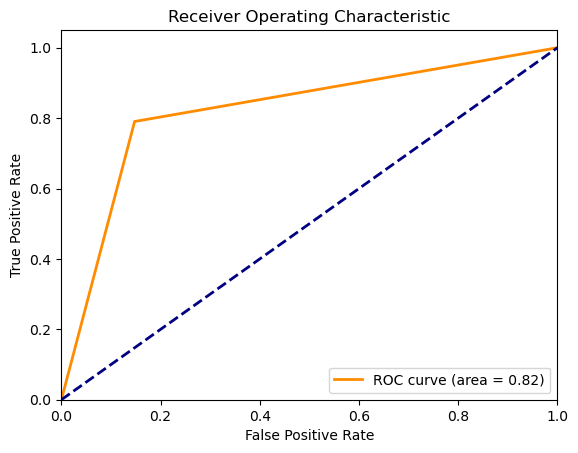

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


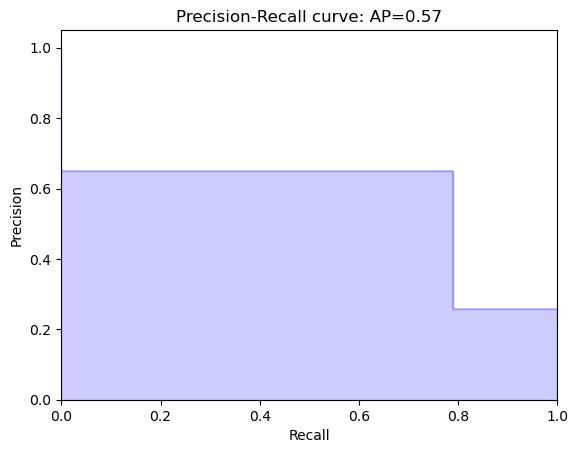

2025-04-16 11:15:55,405 - INFO - Average Precision: 0.57
2025-04-16 11:15:55,406 - INFO - Model training and evaluation completed successfully.


--------------------


In [27]:
# Fit the model
logger.info("Fitting the model...")
if algorithm == 'catboost':
    classifier.fit(X_train_preprocessed, y_train, cat_features=cat_features_indices)
    model_pipeline.save_model(classifier, algorithm=algorithm, run=1)
else:
    classifier.fit(X_train_preprocessed, y_train)
    model_pipeline.save_model(classifier, algorithm=algorithm, run=1)
    
# Evaluate the model on the validation set
logger.info("Making predictions on validation data...")
y_pred_validation = classifier.predict(X_val_preprocessed)

# Compute and display metrics
accuracy = accuracy_score(y_validation, y_pred_validation)
roc_auc = roc_auc_score(y_validation, y_pred_validation)
precision = sk_precision_score(y_validation, y_pred_validation)
recall = recall_score(y_validation, y_pred_validation)
f1 = f1_score(y_validation, y_pred_validation)

logger.info(f"Accuracy: {accuracy}")
logger.info(f"ROC AUC: {roc_auc}")
logger.info(f"Precision: {precision}")
logger.info(f"Recall: {recall}")
logger.info(f"F1 Score: {f1} \n")

# Detailed classification report
report = classification_report(y_validation, y_pred_validation)
print("Classification Report for Validation Data:")
print(report)

# Generate the confusion matrix
# sklearn confusion matrix layout:
# TN  FP
# FN  TP
cm = confusion_matrix(y_validation, y_pred_validation)
# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_validation, y_pred_validation)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve and average precision
# Precision-Recall curve robust with imbalanced datasets!
precision, recall, _ = precision_recall_curve(y_validation, classifier.predict(X_val_preprocessed))
average_precision = average_precision_score(y_validation, classifier.predict(X_val_preprocessed))

# Plot the Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.show()

logger.info(f"Average Precision: {average_precision:.2f}")
# Create a subdirectory "models" if it doesn't exist
#models_dir = "models"
#os.makedirs(models_dir, exist_ok=True)

# Commenting out below, since different models have different hyperparameters. At the moment, not model-agnostic
''' 
print(f"Max Depth: {max_depth}")
print(f"Min Child Weight: {min_child_weight}")
print(f"Gamma: {gamma}")
print(f"Subsample: {subsample}")
print(f"Column Sample by Tree: {colsample_bytree}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Estimators: {n_estimators}")
# Print any other relevant performance metrics
'''
print("-" * 20)
# Evaluate the model (you can add your evaluation metrics here)
logger.info("Model training and evaluation completed successfully.")


### Training and Validation (Hyperparameter Tuning)

2025-04-22 08:51:42,695 - INFO - Training with parameters: {'C': 0.01, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 200}
2025-04-22 08:51:42,696 - INFO - Fitting the model...
2025-04-22 08:51:44,578 - INFO - Making predictions on validation data...
2025-04-22 08:51:44,608 - INFO - Results for {'C': 0.01, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 200} - Accuracy: 0.8210223182145429, ROC AUC: 0.8889707639262607, Precision: 0.6224215246636772, Recall: 0.7758524315259921, F1 Score: 0.6907190843493406
2025-04-22 08:51:44,609 - INFO - Training with parameters: {'C': 0.01, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 500}
2025-04-22 08:51:44,609 - INFO - Fitting the model...
2025-04-22 08:51:46,548 - INFO - Making predictions on validation data...
2025-04-22 08:51:46,577 - INFO - Results for {'C': 0.01, 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 500}

Model saved to /home/sagemaker-user/Precision 3.0/model_logistic_regression_1_2025-04-22 09:58:38.pkl
Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      5156
           1       0.63      0.78      0.70      1789

    accuracy                           0.82      6945
   macro avg       0.77      0.81      0.79      6945
weighted avg       0.84      0.82      0.83      6945

Confusion Matrix:
[[4338  818]
 [ 398 1391]]


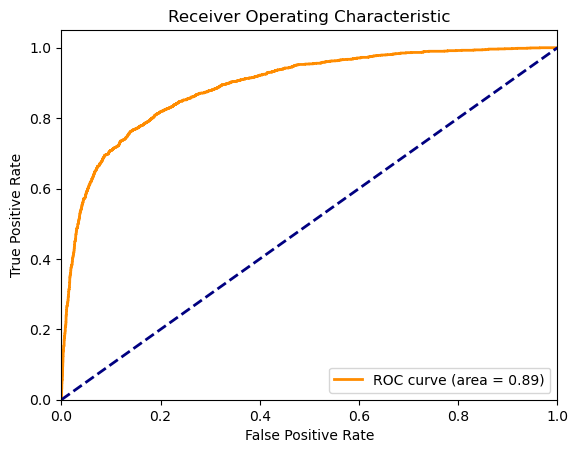

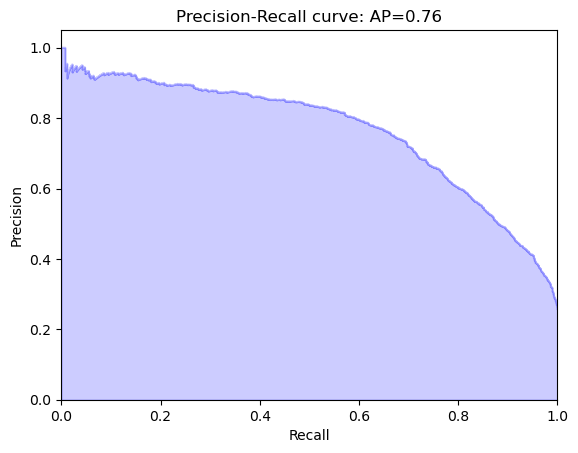

2025-04-22 09:58:38,938 - INFO - Average Precision: 0.76
2025-04-22 09:58:38,939 - INFO - Model training and evaluation completed successfully.


In [28]:
# Define hyperparameter grid for each model
algorithm = 'logistic_regression'

# For classifiers with "scale_pos_weight" argument, compute "scale_pos_weight".
# This argument helps the model handle class imbalances by giving more weight to fraud cases.
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

hyperparameter_grid = {
    "random_forest": {
        "n_estimators": [1500],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "xgb": {
        "max_depth": [6, 10],
        "learning_rate": [0.01, 0.05],
        "n_estimators": [1500],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [scale_pos_weight]
    },
    "catboost": {
        "depth": [6, 10],
        "learning_rate": [0.01, 0.1],
        "iterations": [1000, 1200]
    },
    "logistic_regression": {
        "C": [0.01, 0.1, 0.5, 1.0, 5.0],
        "solver": ["liblinear", "lbfgs", "saga"],
        "penalty": ["l2"],
        "class_weight": ["balanced"],
        "max_iter": [200, 500]
    },
    "svm": {
        "C": [0.1, 1.0],
        "kernel": ["rbf"],
        "gamma": ["scale"],
        "max_iter": [1000, 2000]
    },
    "neural_network": {
        "hidden_layer_sizes": [(256, 128), (128, 64)],
        "alpha": [0.0001, 0.001],
        "max_iter": [500, 1000]
    },
    "light_gbm": {
        "objective": ["binary"],
        "num_leaves": [31],               # Controls complexity
        "max_depth": [10, 20],            # -1 means no limit
        "learning_rate": [0.01, 0.05],   # Typical values
        "n_estimators": [1500],          # # of boosting rounds
        "min_child_samples": [20, 40],        # Minimum data in a leaf
        "subsample": [0.8, 1.0],              # Row sampling (bagging)
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [scale_pos_weight]
        #"reg_alpha": [0.0, 0.1],              # L1 regularization
        #"reg_lambda": [0.0, 0.1]              # L2 regularization
    }
}

# Get hyperparameter combinations for selected model
if algorithm in hyperparameter_grid:
    param_combinations = list(product(*hyperparameter_grid[algorithm].values()))
    param_names = list(hyperparameter_grid[algorithm].keys())
else:
    raise ValueError(f"No hyperparameter grid found for {algorithm}")

# Track best model performance
best_model = None
best_score = -np.inf
best_params = None

# Iterate over all hyperparameter combinations
for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    logger.info(f"Training with parameters: {params}")

    # Instantiate model with current hyperparameters
    if algorithm == 'random_forest':
        classifier = model_pipeline.CustomRandomForest(**params)
    elif algorithm == 'xgb':
        classifier = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    elif algorithm == 'catboost':
        classifier = cb.CatBoostClassifier(**params, verbose=False, random_state=42)
    elif algorithm == 'logistic_regression':
        classifier = model_pipeline.CustomLogisticRegression(**params)
    elif algorithm == 'svm':
        classifier = model_pipeline.CustomSVM(**params)
    elif algorithm == 'neural_network':
        classifier = model_pipeline.CustomNeuralNetwork(**params)
    elif algorithm == 'light_gbm':
        classifier = LGBMClassifier(**params)
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")

    # Fit the model
    logger.info("Fitting the model...")
    if algorithm == 'catboost':
        classifier.fit(X_train_preprocessed, y_train, cat_features=cat_features_indices)
    else:
        classifier.fit(X_train_preprocessed, y_train)

    # Evaluate on validation set
    logger.info("Making predictions on validation data...")
    y_pred_validation = classifier.predict(X_val_preprocessed)
    y_pred_proba = classifier.predict_proba(X_val_preprocessed)[:, 1]  # Use probabilities for AUC-ROC

    # Compute metrics
    accuracy = accuracy_score(y_validation, y_pred_validation)
    roc_auc = roc_auc_score(y_validation, y_pred_proba)
    precision = sk_precision_score(y_validation, y_pred_validation)
    recall = recall_score(y_validation, y_pred_validation)
    f1 = f1_score(y_validation, y_pred_validation)

    logger.info(f"Results for {params} - Accuracy: {accuracy}, ROC AUC: {roc_auc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

    # Track best model using ROC-AUC
    if roc_auc > best_score:
        best_score = roc_auc
        best_model = classifier
        best_params = params

# Save best model
logger.info(f"Best parameters found: {best_params}")
model_pipeline.save_model(best_model, algorithm=algorithm, run=1)

# Evaluate best model on validation set
logger.info("Evaluating best model on validation set...")
y_pred_validation = best_model.predict(X_val_preprocessed)
y_pred_proba = best_model.predict_proba(X_val_preprocessed)[:, 1]

# Compute and display metrics for best model
accuracy = accuracy_score(y_validation, y_pred_validation)
roc_auc = roc_auc_score(y_validation, y_pred_proba)
precision = sk_precision_score(y_validation, y_pred_validation)
recall = recall_score(y_validation, y_pred_validation)
f1 = f1_score(y_validation, y_pred_validation)

logger.info(f"Best Model - Accuracy: {accuracy}, ROC AUC: {roc_auc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1} \n")

# Print classification report
report = classification_report(y_validation, y_pred_validation)
print("Classification Report for Validation Data:")
print(report)

# Display confusion matrix
cm = confusion_matrix(y_validation, y_pred_validation)
print("Confusion Matrix:")
print(cm)

# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_validation, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_validation, y_pred_proba)
average_precision = average_precision_score(y_validation, y_pred_proba)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
plt.show()

logger.info(f"Average Precision: {average_precision:.2f}")
logger.info("Model training and evaluation completed successfully.")

### Test

In [21]:
# Path to the 'models' folder
models_folder = '/home/sagemaker-user/Precision 3.0'

Model: model_logistic_regression_1_2025-04-22 09:58:38.pkl
Accuracy: 0.8236226544426356
ROC AUC: 0.8088653224391964
Precision: 0.5499853843905291
Recall: 0.7837950426994377
F1 Score: 0.6463969767242119
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     18541
           1       0.55      0.78      0.65      4801

    accuracy                           0.82     23342
   macro avg       0.74      0.81      0.76     23342
weighted avg       0.86      0.82      0.83     23342

Confusion Matrix:
[[15462  3079]
 [ 1038  3763]]


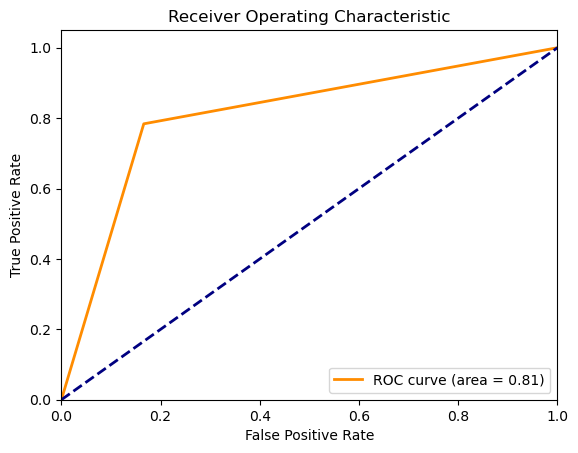

----------------------------------------


In [22]:
# Loop through the model files in the 'models' folder
for model_file in os.listdir(models_folder):
    if model_file.endswith('model_logistic_regression_1_2025-04-22 09:58:38.pkl'):
        model_path = os.path.join(models_folder, model_file)
        if algorithm == 'catboost':
            # Load the CatBoost model
            catboost_model = cb.CatBoostClassifier()
            catboost_model.load_model(model_path)
            # Make predictions on the test data
            y_pred_prob_test = catboost_model.predict_proba(X_test_preprocessed)
            # y_pred_prob_test will have two columns: one for the probability of class 0, and the other for class 1
            # To get the probability of class 1, select the second column
            y_pred_test = y_pred_prob_test[:, 1]
        
        if algorithm == 'xgb':
            # Load the model
            bst = xgb.Booster(model_file=model_path)
            # Make predictions on the test data
            y_pred_test = bst.predict(xgb.DMatrix(X_test_preprocessed))
            
        else: # has to be an sklearn model, saved using pickle
            model = model_pipeline.load_model(model_path, algorithm)
            # Make predictions
            y_pred_test = model_pipeline.make_predictions(model, algorithm, X_test_preprocessed)

        # Convert the predictions to binary values (0 or 1)
        y_pred_rounded = np.round(y_pred_test)

        print(f"Model: {model_file}")
        
        # Compute and display metrics
        accuracy = accuracy_score(y_test, y_pred_rounded)
        roc_auc = roc_auc_score(y_test, y_pred_rounded)
        precision = sk_precision_score(y_test, y_pred_rounded)
        recall = recall_score(y_test, y_pred_rounded)
        f1 = f1_score(y_test, y_pred_rounded)

        print(f"Accuracy: {accuracy}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        
        # Get the classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred_rounded))
        
        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred_rounded)

        # Display the confusion matrix
        print("Confusion Matrix:")
        print(cm)
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_pred_rounded)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        # Convert the predictions array into a DataFrame
        df_preds = pd.DataFrame(y_pred_test, columns=['Prediction'])
        
        # Join predictions to enquiry keys
        # Enquiry keys, model target and tvh partition contained in test_identifiers_df
        test_identifiers_path = f'/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant_DS_{ds_ratio}.csv'
        test_identifiers_df = pd.read_csv(test_identifiers_path)

        # Concatenate the identifiers and predictions
        results_df = pd.concat([test_identifiers_df, df_preds], axis=1)
        
        # Create precision scores.
        raw_prob_average_value = 0.043000000000000003
        precision_scores = []
        for pred in results_df['Prediction']:
            precision_score = pipeline.precision_score(pred, raw_prob_average_value)
            precision_scores.append(precision_score)
    
        # Create the 'Precision_Score' column in the DataFrame
        results_df['Precision_Score'] = precision_scores

        # Saving the combined DataFrame
        results_df.to_csv(f'/home/sagemaker-user/Precision 3.0/Assurant_Output_{model_file}.csv', index=False)
        print("-" * 40)

### Logistic Regression Coefficients

In [24]:
# Get feature names for preprocessed features
feature_names = get_transformed_feature_names(preprocessor)

In [25]:
# Get coefficients from best logistic regression model
coefficients = model.model.coef_[0]  # shape: (n_features,)

In [26]:
coefficients

array([ 3.64288460e-01,  8.12524406e-02,  1.90910037e-01,  1.24222339e+00,
        2.09709022e-03, -1.71843426e-01,  3.20998570e-01, -9.26389392e-02,
        5.83795362e-01,  8.77489026e-02, -4.34973173e-02,  1.41150222e-02,
       -6.52600723e-02, -8.98679611e-04,  4.79933619e-02, -2.38352917e-01,
        3.07959008e-01, -2.52971969e-02, -7.81653978e-01, -6.05497740e-01,
       -2.85507170e-01,  0.00000000e+00,  9.34315104e-03,  1.38495132e+00,
        2.36842836e-03,  1.33680762e-02,  1.39825928e+00,  2.70569148e-01,
        3.10462426e+00,  1.85760460e-02,  9.37133987e-02,  1.29476426e-01,
        4.45156225e-02,  3.63544179e-01,  1.07100412e+00,  5.53454642e-01,
        3.39106323e-01, -1.75115907e-01,  7.78114162e-02, -4.69673482e-01,
        5.30266316e-01,  2.21412756e-01, -2.19270807e-01,  1.10333707e+00,
       -5.52795891e-02, -1.62789822e-01, -2.49218380e-02, -1.08058187e-01,
        1.25722241e+00, -2.01007433e-01, -1.19686825e-01, -1.61081247e-01,
        2.76254530e-01,  

In [27]:
# Create DataFrame of feature importance
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "AbsCoefficient": np.abs(coefficients)
})

In [29]:
# Sort by absolute value
coef_df_sorted = coef_df.sort_values(by="AbsCoefficient", ascending=False)
coef_df_sorted

Feature  Coefficient  \
28                                                x28     3.104624   
58                                                x58     1.747188   
26                                                x26     1.398259   
23                                                x23     1.384951   
48                                                x48     1.257222   
..                                                ...          ...   
403                       MAKE_ENQADD04_GROUPED_NOKIA    -0.001109   
488  FIRSTTWOPOSTCODEPTK652ATK1_BANDING_VERY_LOW_RISK     0.000994   
377                EMAILDOMAINSUFFIXPTK652_GROUPED_lt     0.000966   
13                                                x13    -0.000899   
21                                                x21     0.000000   

     AbsCoefficient  
28         3.104624  
58         1.747188  
26         1.398259  
23         1.384951  
48         1.257222  
..              ...  
403        0.001109  
488        0.000994  
377        0.000966  
13         0.000899  
21         0.000000  

[726 rows x 3 columns]

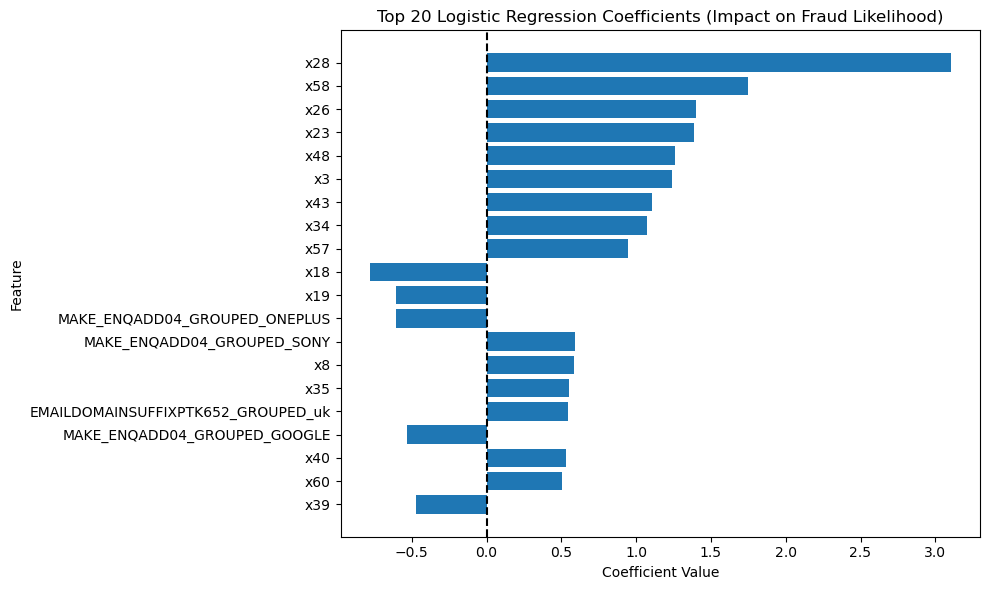

In [30]:
top_n = 20  # Show top 20 features
top_features = coef_df_sorted.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_features["Feature"], top_features["Coefficient"])
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Top 20 Logistic Regression Coefficients (Impact on Fraud Likelihood)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### SHAP

In [23]:
def get_transformed_feature_names(column_transformer):
    """
    Extract transformed feature names from a fitted ColumnTransformer.
    Handles pipelines and transformers with get_feature_names_out.

    Args:
        column_transformer (ColumnTransformer): Fitted ColumnTransformer.

    Returns:
        List[str]: List of transformed feature names.
    """
    feature_names = []

    for name, transformer, original_features in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'passthrough':
            feature_names.extend(original_features)
            continue

        # Check if it's a pipeline
        if isinstance(transformer, Pipeline):
            # Iterate steps in reverse to find the first with get_feature_names_out
            for step_name, step_transformer in reversed(transformer.steps):
                if hasattr(step_transformer, 'get_feature_names_out'):
                    if isinstance(step_transformer, OneHotEncoder):
                        names = step_transformer.get_feature_names_out(original_features)
                    else:
                        names = step_transformer.get_feature_names_out()
                    feature_names.extend(names)
                    break
            else:
                # No transformer in pipeline supports get_feature_names_out
                feature_names.extend(original_features)
        elif hasattr(transformer, 'get_feature_names_out'):
            # Transformer supports get_feature_names_out directly
            feature_names.extend(transformer.get_feature_names_out(original_features))
        else:
            # Fallback to original feature names
            feature_names.extend(original_features)

    return feature_names

In [58]:
# Get feature names for preprocessed features
feature_names = get_transformed_feature_names(preprocessor)

In [59]:
# --- SHAP works best on raw, unscaled features ---
# Use X_train_preprocessed *only if* preprocessing is minimal
# Otherwise use original features: X_train, X_validation

# As X_val_preprocessed is numpy array, construct a DataFrame with correct column names and index
X_explain = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_validation.index)

In [60]:
X_explain.head()

x0   x1   x2   x3        x4        x5   x6   x7   x8   x9  x10  x11  x12  \
0 -1.0  1.0 -1.0  0.0  0.333333  0.000000  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1 -1.0  0.0  0.0  0.0 -0.333333 -0.764706  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2 -1.0  0.0  0.0  0.0 -0.333333 -0.117647  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3 -1.0  0.0  0.0  0.0  0.000000  0.176471  0.0  0.0  0.0  0.0  0.0  1.0  2.0   
4 -1.0  1.0 -1.0  0.0  5.666667  1.529412  0.0  0.0  0.0  0.0  1.0  1.0  0.0   

   x13  x14   x15   x16  x17  x18  x19  x20  x21  x22  x23  x24  x25  x26  \
0  0.0 -1.0  1.25  1.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0 -1.0  1.00  1.25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.25  0.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0 -0.75 -0.50  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0 -1.25 -1.00  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

   x27  x28  x29  x30  x31  x32  x33  x34  x35  x36  x37  x38  x39  x40  x41  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   x42  x43  x44  x45  x46  x47  x48  x49  x50  x51  x52  x53  x54  x55  x56  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   x57  x58  x59  x60  x61  x62  x63  x64  x65  x66  CLAIMTYPECODE_loss  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 1.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 1.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                 1.0   

   CLAIMTYPECODE_theft  REGIONPTK652ATK1_EAST ANGLIA  \
0                  0.0                           0.0   
1                  0.0                           0.0   
2                  0.0                           0.0   
3                  0.0                           0.0   
4                  0.0                           0.0   

   REGIONPTK652ATK1_EAST MIDLANDS  REGIONPTK652ATK1_GREATER LONDON  \
0                             0.0                              0.0   
1                             0.0                              1.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   

   REGIONPTK652ATK1_GUERNSEY  REGIONPTK652ATK1_ISLE OF MAN  \
0                        0.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        0.0                           0.0   
4                        0.0                           0.0   

   REGIONPTK652ATK1_JERSEY  REGIONPTK652ATK1_NORTH  \
0                      0.0                     0.0   
1                      0.0                     0.0   
2                      0.0                     0.0   
3                      0.0                     0.0   
4                      0.0                     0.0   

   REGIONPTK652ATK1_NORTH WEST  REGIONPTK652ATK1_NORTHERN IRELAND  \
0                          0.0                                0.0   
1                          0.0                       

In [61]:
explainer = shap.Explainer(bst, X_explain) # change 'bst' to be model agnostic
# Compute SHAP values
shap_values = explainer(X_explain)

100%|===================| 6930/6945 [04:56<00:00]        

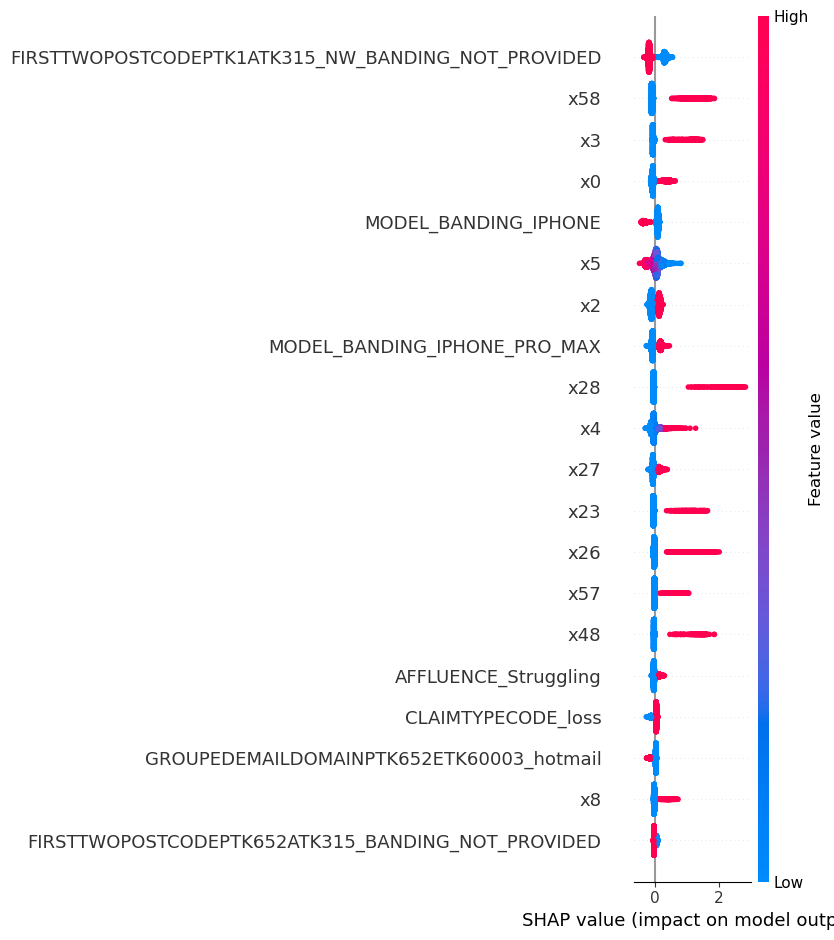

In [62]:
# --- Global Summary Plot ---
shap.summary_plot(shap_values, X_explain, show=True)

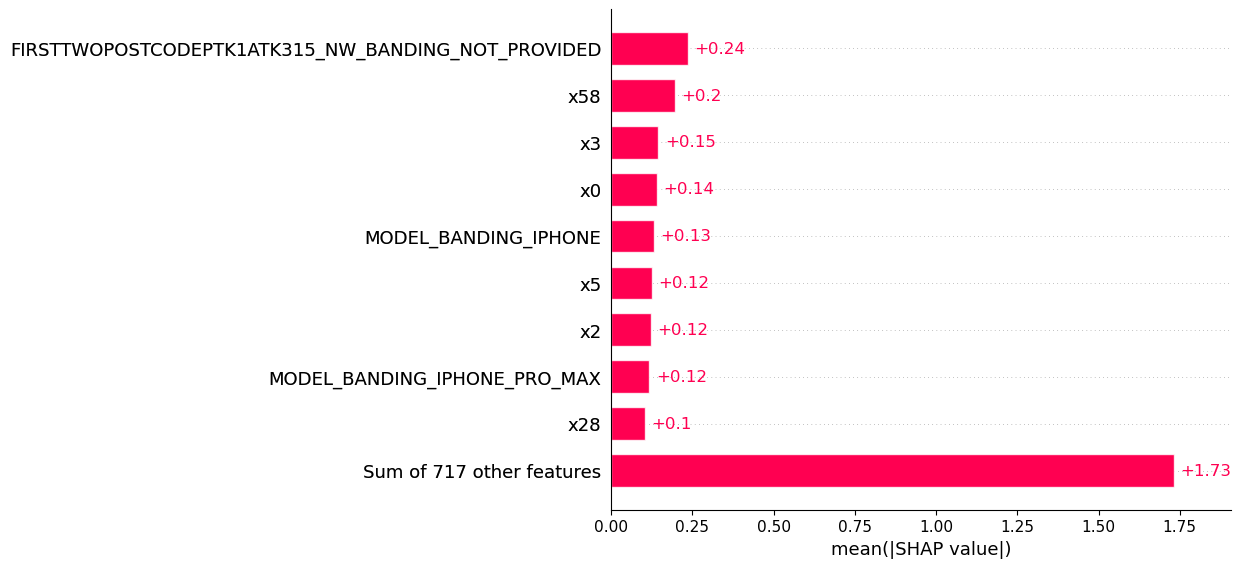

In [63]:
# Use this when you want to rank features by importance (average impact)
shap.plots.bar(shap_values)

#### Explain One Fraud Case

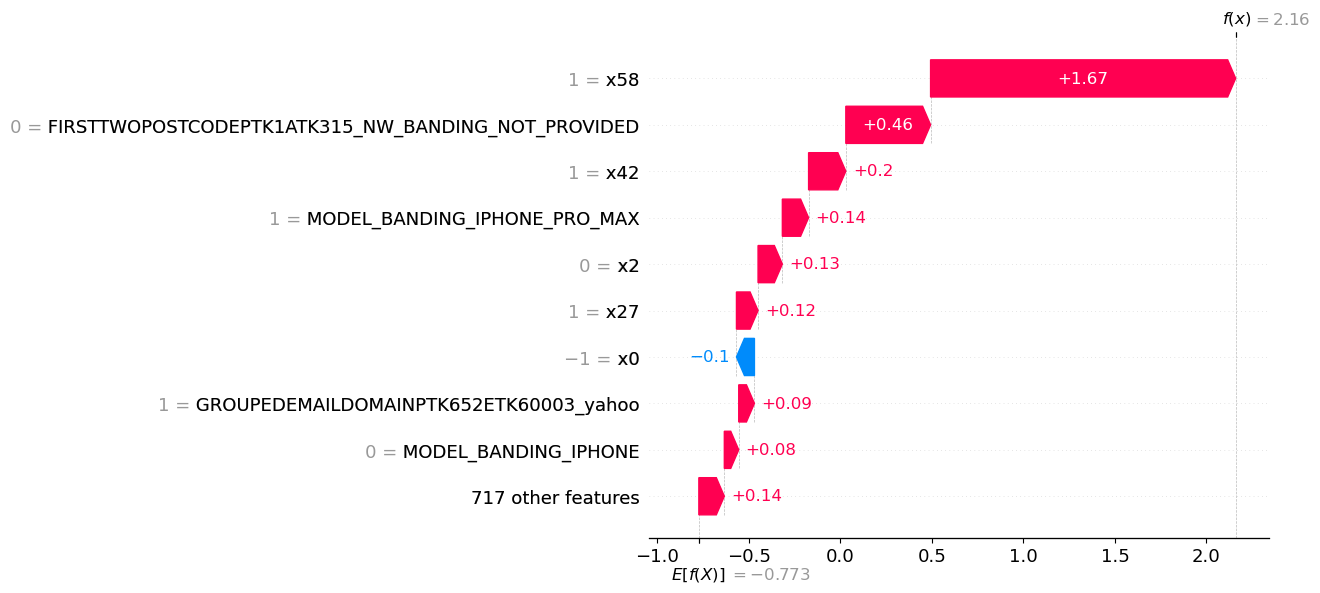

In [68]:
# For one fraud case
fraud_index = y_validation[y_validation == 1].index[0]

# Show feature contributions using a waterfall plot (no JavaScript)
shap.plots.waterfall(shap_values[fraud_index])

### Feature Importance (Working)

In [52]:
def get_transformed_feature_names(column_transformer):
    """
    Extract transformed feature names from a fitted ColumnTransformer.
    Handles pipelines and transformers with get_feature_names_out.

    Args:
        column_transformer (ColumnTransformer): Fitted ColumnTransformer.

    Returns:
        List[str]: List of transformed feature names.
    """
    feature_names = []

    for name, transformer, original_features in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'passthrough':
            feature_names.extend(original_features)
            continue

        # Check if it's a pipeline
        if isinstance(transformer, Pipeline):
            # Iterate steps in reverse to find the first with get_feature_names_out
            for step_name, step_transformer in reversed(transformer.steps):
                if hasattr(step_transformer, 'get_feature_names_out'):
                    if isinstance(step_transformer, OneHotEncoder):
                        names = step_transformer.get_feature_names_out(original_features)
                    else:
                        names = step_transformer.get_feature_names_out()
                    feature_names.extend(names)
                    break
            else:
                # No transformer in pipeline supports get_feature_names_out
                feature_names.extend(original_features)
        elif hasattr(transformer, 'get_feature_names_out'):
            # Transformer supports get_feature_names_out directly
            feature_names.extend(transformer.get_feature_names_out(original_features))
        else:
            # Fallback to original feature names
            feature_names.extend(original_features)

    return feature_names

In [27]:
# Load the trained model
model = xgb.Booster(model_file='/home/sagemaker-user/Precision 3.0/model_xgb_1_2025-04-09 12:43:16.bst')

# Get feature importance
feature_importance = model.get_score(importance_type='gain')  # Can change to 'weight' or 'cover'

# Now, you can safely call your function to get the feature names
# preprocessor MUST be fitted
feature_names = get_transformed_feature_names(preprocessor)

# Match feature names with their importances
importance_dict = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Convert to a sorted list for better visualization or analysis
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

In [28]:
sorted_importance

[('x58', 725.548583984375),
 ('x3', 386.0987243652344),
 ('x18', 120.34430694580078),
 ('x28', 115.22514343261719),
 ('x57', 114.43151092529297),
 ('MODEL_BANDING_IPHONE', 113.56612396240234),
 ('x48', 112.07394409179688),
 ('x19', 92.41104888916016),
 ('x26', 72.68415832519531),
 ('FIRSTTWOPOSTCODEPTK1ATK315_NW_BANDING_NOT_PROVIDED', 70.89071655273438),
 ('x23', 67.59402465820312),
 ('MODEL_BANDING_IPHONE_PRO_MAX', 66.21688842773438),
 ('LASTTWOEMAILPTK652ETK60003_JPMC_BANDING_MEDIUM_RISK', 59.134002685546875),
 ('x63', 51.830543518066406),
 ('x8', 48.662353515625),
 ('x2', 47.357784271240234),
 ('x62', 46.02903747558594),
 ('x34', 45.901790618896484),
 ('x60', 37.11970138549805),
 ('x40', 36.10261154174805),
 ('x0', 28.41967010498047),
 ('LASTTWOEMAIL_PTK652ETK60003_NW_BANDING_NOT_PROVIDED', 27.276884078979492),
 ('GROUPEDEMAILDOMAINPTK652ETK60003_gmail', 26.390913009643555),
 ('x59', 25.928123474121094),
 ('x43', 23.489116668701172),
 ('AFFLUENCE_Struggling', 23.070730209350586),
 (

#### Get enquiry key, prediction, precision score, model target and tvh_partition on test set

In [64]:
# Convert the array into a pandas DataFrame
df = pd.DataFrame(y_pred_test, columns=['Prediction'])

# Predictions file to df
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant_201124.csv'

# Save the DataFrame as a CSV file
df.to_csv(predictions_file_path, index=False)

# Join predictions to enquiry keys
# Enquiry keys, model target and tvh partition contained in test_identifiers_df
test_identifiers_path = '/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant.csv'
test_identifiers_df = pd.read_csv(test_identifiers_path)

predictions_df = pd.read_csv(predictions_file_path)

# Concatenate the identifiers and predictions
results_df = pd.concat([test_identifiers_df, predictions_df], axis=1)

precision_scores = []

for pred in results_df['Prediction']:
    precision_score = pipeline.precision_score(pred, 0.1)
    precision_scores.append(precision_score)
    
# Create the 'Precision_Score' column in the DataFrame
results_df['Precision_Score'] = precision_scores

# Saving the combined DataFrame
results_df.to_csv('Assurant_Output_201124.csv', index=False)

#### Optimise Precision Score

In [ ]:
##########################################
# Optimise raw_probability_average_value
#########################################

# File path to df containing y_pred
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant_060324.csv'
predictions_df = pd.read_csv(predictions_file_path)
y_pred = predictions_df['Prediction']

# Load the test data and extract y_test
test_file_path = '/home/sagemaker-user/Precision 3.0/test_Assurant.csv'
test_data = pd.read_csv(test_file_path)
X_test = test_data.drop('MODEL_TARGET', axis=1)
y_test = test_data['MODEL_TARGET']

# Optimize the precision_score function
results = pipeline.optimise_precision_score(y_test, y_pred, working_threshold=300)

# Print the results
for result in results:
    print(f"raw_probability_average_value: {result['raw_probability_average_value']}")
    print(f"True Positives: {result['true_positives']}")
    print(f"False Positives: {result['false_positives']}")
    print(f"True Negatives: {result['true_negatives']}")
    print(f"False Negatives: {result['false_negatives']}")
    print(f"Precision: {result['precision']}")
    print(f"Recall: {result['recall']}")
    print(f"F1-Score: {result['f1_score']}")
    print("-" * 20)

#### Feature Importance (Not working)

In [29]:
def get_transformed_feature_names(column_transformer):
    """
    Get feature names from ColumnTransformer.
    """
    feature_names = []
    
    for transformer_name, transformer, original_features in column_transformer.transformers_:
        if transformer_name == 'remainder':
            # If remainder is 'passthrough', original_features are returned untransformed
            if transformer == 'passthrough':
                feature_names.extend(original_features)
            continue
        
        # Extract feature names from the transformers
        if hasattr(transformer, 'get_feature_names_out'):
            # Handles transformers with get_feature_names_out method like OneHotEncoder
            if isinstance(transformer, Pipeline):
                transformer = transformer.named_steps['onehot']
            new_features = transformer.get_feature_names_out(original_features)
            feature_names.extend(new_features)
        else:
            # If a transformer doesn't have a get_feature_names_out method, use the original feature names
            feature_names.extend(original_features)
    
    return feature_names

In [30]:
# Load the trained model
model = xgb.Booster(model_file='/home/sagemaker-user/Precision 3.0/models/model.bst')

# Get feature importance
feature_importance = model.get_score(importance_type='gain')  # Can change to 'weight' or 'cover'

# Now, you can safely call your function to get the feature names
# preprocessor MUST be fitted
feature_names = get_transformed_feature_names(preprocessor)

# Match feature names with their importances
importance_dict = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Convert to a sorted list for better visualization or analysis
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

XGBoostError: [13:08:37] /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698387970/work/dmlc-core/src/io/local_filesys.cc:210: Check failed: allow_null:  LocalFileSystem::Open "/home/sagemaker-user/Precision 3.0/models/model.bst": No such file or directory
Stack trace:
  [bt] (0) /opt/conda/lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x6e) [0x7fe04e53dbfe]
  [bt] (1) /opt/conda/lib/libxgboost.so(dmlc::io::LocalFileSystem::Open(dmlc::io::URI const&, char const*, bool)+0x23c) [0x7fe04f14e05c]
  [bt] (2) /opt/conda/lib/libxgboost.so(dmlc::Stream::Create(char const*, char const*, bool)+0x35) [0x7fe04f137d75]
  [bt] (3) /opt/conda/lib/libxgboost.so(XGBoosterLoadModel+0x191) [0x7fe04e4528a1]
  [bt] (4) /opt/conda/lib/python3.11/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7fe0c37e5a4a]
  [bt] (5) /opt/conda/lib/python3.11/lib-dynload/../../libffi.so.8(+0x5fea) [0x7fe0c37e4fea]
  [bt] (6) /opt/conda/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x92c9) [0x7fe0c37f42c9]
  [bt] (7) /opt/conda/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x87ee) [0x7fe0c37f37ee]
  [bt] (8) /opt/conda/bin/python(_PyObject_MakeTpCall+0x29b) [0x5641f9e9675b]



In [54]:
sorted_importance

[('PRECISIONLOCAL02MATCH', 3920.754150390625),
 ('COVERINCIDENTDATEDIFFLESSTHAN30', 1416.4718017578125),
 ('LRT10', 1305.9249267578125),
 ('NEWLY_RELEASED_HANDSETS', 506.01611328125),
 ('PRECISIONLOCAL01MATCH', 281.8096923828125),
 ('FIRSTTWOPOSTCODEPTK652ATK315_CLEAR_50_OCCUR_NOT_PROVIDED',
  261.62127685546875),
 ('HIGH_VALUE_HANDSETS', 214.81427001953125),
 ('FIRSTTWOPOSTCODEPTK652ATK315_BANDING_NOT_PROVIDED', 183.85574340820312),
 ('LRT02', 178.2517547607422),
 ('COUNTY_PTK1ATK315_==Missing==', 176.26461791992188),
 ('CMRT002', 132.78529357910156),
 ('PRECISIONLOCAL03MATCH', 126.46171569824219),
 ('WORKPHONESTANDARDPRESENT', 116.40142059326172),
 ('COVERCLAIMSTARTDATEDIFFUNDER90', 91.65169525146484),
 ('REGIONPTK652ATK315_==Missing==', 89.01483154296875),
 ('EMAILDOMAINSUFFIXPTK652_GROUPED_com', 86.98916625976562),
 ('FIRSTTWOPOSTCODEPTK1ATK315_NW_BANDING_NOT_PROVIDED', 78.71851348876953),
 ('CMRT03', 76.42377471923828),
 ('MODEL_BANDING_IPHONE_PRO_MAX', 75.12394714355469),
 ('LAST

In [55]:
# Remove features below importance threshold, then retrain
# Set the threshold for feature importance
threshold = 5

# Identify features with importance above the threshold
features_to_keep = [fname for fname, score in sorted_importance if score >= threshold]

# Map feature names to indices in the original dataset
feature_indices = [feature_names.index(f) for f in features_to_keep if f in feature_names]

# Select only the columns corresponding to the features above the threshold
X_train_selected = X_train_preprocessed[:, feature_indices]

In [92]:
X_train_selected.shape

(119705, 152)

In [94]:
# Retrain
# Define the hyperparameter distributions
max_depth_dist = randint(9, 15)  # Range: [9, 14]
#min_child_weight_dist = randint(1, 11)  # Range: [1, 10]
#gamma_dist = uniform(0, 1)  # Range: [0, 1]
subsample_dist = uniform(0.4, 8)  # Range: [0.4, 0.8]
#colsample_bytree_dist = uniform(0.4, 0.8)  # Range: [0.5, 1]
learning_rate_dist = uniform(0.005, 0.031)  # Range: [0.005, 0.03]
n_estimators_dist = randint(600, 1201)  # Range: [100, 1000]

num_runs = 20
runs = range(num_runs)

#runs = [6, 7, 8, 9, 10]

for run in runs:
    print(f"Starting run {run + 1}.")
    # Randomly sample hyperparameters from the defined distributions
    max_depth = max_depth_dist.rvs(1)[0]
    #min_child_weight = min_child_weight_dist.rvs(1)[0]
    #gamma = gamma_dist.rvs(1)[0]
    subsample = subsample_dist.rvs(1)[0]
    #colsample_bytree = colsample_bytree_dist.rvs(1)[0]
    learning_rate = learning_rate_dist.rvs(1)[0]
    n_estimators = n_estimators_dist.rvs(1)[0]
    
    # Clip the hyperparameter values to ensure they are within the valid range
    max_depth = min(max_depth, 14)
    #min_child_weight = min(min_child_weight, 10)
    #gamma = min(gamma, 1)
    subsample = min(subsample, 0.8)
    #colsample_bytree = min(colsample_bytree, 1)
    learning_rate = min(learning_rate, 0.03)
    n_estimators = min(n_estimators, 1200)

    # Create the XGBClassifier object with the sampled hyperparameters
    classifier = xgb.XGBClassifier(
        max_depth=max_depth,
        #min_child_weight=min_child_weight,
        #gamma=gamma,
        subsample=subsample,
        #colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        objective='binary:logistic',
        use_label_encoder=False
    )

    print("Training model.")
    classifier.fit(X_train_selected, y_train)

    # Save the model locally
    # Create a date string in UK format for the file name
    date_str = datetime.datetime.now().strftime("%d-%m-%Y")  # Formats the date as DD-MM-YYYY
    
    # Create a subdirectory "models" if it doesn't exist
    #models_dir = "models"
    #os.makedirs(models_dir, exist_ok=True)
    
    
    local_model_path = f"/home/sagemaker-user/Precision 3.0/models/model_{run + 1}_{date_str}.bst"
    classifier.get_booster().save_model(local_model_path)
    print("Model saved locally.")

    print(f"Run {run + 1}:")
    print(f"Max Depth: {max_depth}")
    #print(f"Min Child Weight: {min_child_weight}")
    #print(f"Gamma: {gamma}")
    print(f"Subsample: {subsample}")
    print(f"Column Sample by Tree: {colsample_bytree}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Number of Estimators: {n_estimators}")
    # Print any other relevant performance metrics
    print("-" * 20)

Starting run 1.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 1:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.010020702332030219
Number of Estimators: 606
--------------------
Starting run 2.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 2:
Max Depth: 13
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.026973908987288873
Number of Estimators: 954
--------------------
Starting run 3.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 3:
Max Depth: 13
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.013464538488304461
Number of Estimators: 891
--------------------
Starting run 4.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 4:
Max Depth: 12
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.02106366462877434
Number of Estimators: 1150
--------------------
Starting run 5.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 5:
Max Depth: 12
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.021877084264737928
Number of Estimators: 1185
--------------------
Starting run 6.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 6:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.02263758663561445
Number of Estimators: 931
--------------------
Starting run 7.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 7:
Max Depth: 11
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.0075237551674033724
Number of Estimators: 686
--------------------
Starting run 8.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 8:
Max Depth: 10
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.02334781740274779
Number of Estimators: 745
--------------------
Starting run 9.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:20:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 9:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.03
Number of Estimators: 876
--------------------
Starting run 10.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:20:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 10:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.021885374556780118
Number of Estimators: 1020
--------------------
Starting run 11.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:20:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 11:
Max Depth: 13
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.013933761653848013
Number of Estimators: 1046
--------------------
Starting run 12.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:21:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 12:
Max Depth: 10
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.01756267530840557
Number of Estimators: 772
--------------------
Starting run 13.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:21:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 13:
Max Depth: 9
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.02134400281906836
Number of Estimators: 1026
--------------------
Starting run 14.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:21:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 14:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.022722744120137077
Number of Estimators: 1165
--------------------
Starting run 15.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:21:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 15:
Max Depth: 12
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.012931847862835914
Number of Estimators: 768
--------------------
Starting run 16.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:22:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 16:
Max Depth: 11
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.015226075874808204
Number of Estimators: 1002
--------------------
Starting run 17.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:22:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 17:
Max Depth: 13
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.02747911529769318
Number of Estimators: 1039
--------------------
Starting run 18.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:22:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 18:
Max Depth: 13
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.011886588826872652
Number of Estimators: 789
--------------------
Starting run 19.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:22:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 19:
Max Depth: 11
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.013656051766244136
Number of Estimators: 690
--------------------
Starting run 20.
Training model.


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Model saved locally.
Run 20:
Max Depth: 14
Subsample: 0.8
Column Sample by Tree: 1
Learning Rate: 0.01703421649043296
Number of Estimators: 885
--------------------


#### Test

In [25]:
# Load the test data
test_data = pd.read_csv('test_Assurant.csv')
X_test = test_data.drop('MODEL_TARGET', axis=1)
y_test = test_data['MODEL_TARGET']

In [26]:
numeric_columns = test_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = test_data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist()

In [33]:
pipeline = define_learner_xgboost(numeric_columns, categorical_columns)

Defining XGBoost classifier with hyperparameters and preprocessing steps...
Classifier defined.


In [34]:
# Extract the preprocessor from the pipeline
preprocessor = pipeline.named_steps['preprocessor']

In [35]:
# Transform X_train using the preprocessor
X_test_preprocessed = preprocessor.fit_transform(X_test)

In [48]:
# Make predictions on the test data
y_pred = model.predict(xgb.DMatrix(X_test_preprocessed))

In [49]:
y_pred

array([0.03079743, 0.07180792, 0.12252516, ..., 0.8004633 , 0.0205891 ,
       0.08882676], dtype=float32)

In [50]:
accuracy = accuracy_score(y_test, y_pred.round())
roc_auc = roc_auc_score(y_test, y_pred.round())
precision = precision_score(y_test, y_pred.round())
recall = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8458572530203068
ROC AUC: 0.6621773431166207
Precision: 0.778601204261232
Recall: 0.35013538846073733
F1 Score: 0.48304597701149427


In [51]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred.round())

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[18063   478]
 [ 3120  1681]]


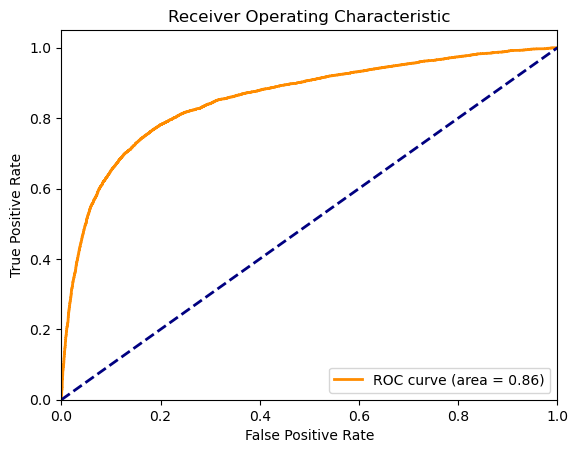

In [52]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Convert the array into a pandas DataFrame
df = pd.DataFrame(y_pred, columns=['Prediction'])

In [31]:
# Predictions file to df
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant_060324.csv'

# Save the DataFrame as a CSV file
df.to_csv(predictions_file_path, index=False)

In [ ]:
df['Prec]

In [14]:
# Join predictions to enquiry keys
# Enquiry keys, model target and tvh partition contained in test_identifiers_df
test_identifiers_path = '/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant.csv'
test_identifiers_df = pd.read_csv(test_identifiers_path)

predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant_060324.csv'
predictions_df = pd.read_csv(predictions_file_path)

# Concatenate the identifiers and predictions
results_df = pd.concat([test_identifiers_df, predictions_df], axis=1)

precision_scores = []

for pred in results_df['Prediction']:
    precision_score = pipeline.precision_score(pred, 0.1)
    precision_scores.append(precision_score)
    
# Create the 'Precision_Score' column in the DataFrame
results_df['Precision_Score'] = precision_scores

# Saving the combined DataFrame
results_df.to_csv('Assurant_Output_070324.csv', index=False)

In [12]:
##########################################
# Optimise raw_probability_average_value
#########################################

# File path to df containing y_pred
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant_060324.csv'
predictions_df = pd.read_csv(predictions_file_path)
y_pred = predictions_df['Prediction']

# Load the test data and extract y_test
test_file_path = '/home/sagemaker-user/Precision 3.0/test_Assurant.csv'
test_data = pd.read_csv(test_file_path)
X_test = test_data.drop('MODEL_TARGET', axis=1)
y_test = test_data['MODEL_TARGET']

# Optimize the precision_score function
results = pipeline.optimise_precision_score(y_test, y_pred, working_threshold=300)

# Print the results
for result in results:
    print(f"raw_probability_average_value: {result['raw_probability_average_value']}")
    print(f"True Positives: {result['true_positives']}")
    print(f"False Positives: {result['false_positives']}")
    print(f"True Negatives: {result['true_negatives']}")
    print(f"False Negatives: {result['false_negatives']}")
    print(f"Precision: {result['precision']}")
    print(f"Recall: {result['recall']}")
    print(f"F1-Score: {result['f1_score']}")
    print("-" * 20)

/root/Cloud_POC/pipeline.py:386: RuntimeWarning: divide by zero encountered in scalar divide
  si_optimal_point = (final_score_maximum_score - final_score_optimal_point) / (raw_probability_maximum_score - raw_probability_optimal_point)
/root/Cloud_POC/pipeline.py:388: RuntimeWarning: divide by zero encountered in scalar divide
  yi_optimal_point = 3 * (hi_average_value + hi_optimal_point) * 1 / ((2 * hi_optimal_point + hi_average_value) / si_average_value + (hi_optimal_point + 2 * hi_average_value) / si_optimal_point)
/root/Cloud_POC/pipeline.py:390: RuntimeWarning: invalid value encountered in scalar divide
  yi_lowest_score = yi_average_value + 500


raw_probability_average_value: 0.0
True Positives: 4801
False Positives: 18541
True Negatives: 0
False Negatives: 0
Precision: 0.2056807471510582
Recall: 1.0
F1-Score: 0.3411860853498206
--------------------
raw_probability_average_value: 0.1
True Positives: 2912
False Positives: 1226
True Negatives: 17315
False Negatives: 1889
Precision: 0.7037216046399226
Recall: 0.6065403041033118
F1-Score: 0.6515270164447924
--------------------
raw_probability_average_value: 0.2
True Positives: 140
False Positives: 11
True Negatives: 18530
False Negatives: 4661
Precision: 0.9271523178807947
Recall: 0.02916059154342845
F1-Score: 0.05654281098546042
--------------------
raw_probability_average_value: 0.30000000000000004
True Positives: 0
False Positives: 0
True Negatives: 18541
False Negatives: 4801
Precision: 0
Recall: 0.0
F1-Score: 0
--------------------
raw_probability_average_value: 0.4
True Positives: 0
False Positives: 0
True Negatives: 18541
False Negatives: 4801
Precision: 0
Recall: 0.0
F1-S

#### Test Several Models

In [43]:
# Path to the 'models' folder
models_folder = '/home/sagemaker-user/Precision 3.0'

# Load the test data
test_data = pd.read_csv(test_path)
X_test = test_data.drop('MODEL_TARGET', axis=1)
y_test = test_data['MODEL_TARGET']

In [44]:
# Create function to return sklearn pipeline
def create_pipeline(data: pd.DataFrame) -> sklearn.pipeline.Pipeline:
    # Identify numeric and categorical columns. 
    # Each type will be processed differently.
    numeric_columns = data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = data.drop('MODEL_TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist()
    
    print("Defining XGBoost classifier with hyperparameters and preprocessing steps...")
    classifier = xgb.XGBClassifier(
        max_depth = 10,
        eta = 0.01,
        subsample = 0.7,
        n_estimators = 100,
        objective = 'binary:logistic',
        min_child_weight = 1,
        colsample_bytree = 0.5,
        use_label_encoder=False
    )

    numeric_transformer = SimpleImputer(strategy='constant', fill_value=-99999)
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='==Missing==')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_columns),
            ('cat', categorical_transformer, categorical_columns)
        ], sparse_threshold=1.0
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    print("Pipeline created.")
    return pipeline

In [45]:
# Create pipeline
model_pipeline = create_pipeline(test_data)

# Extract the preprocessor from the pipeline
#preprocessor = model_pipeline.named_steps['preprocessor']

Defining XGBoost classifier with hyperparameters and preprocessing steps...
Pipeline created.


In [46]:
# Transform X_test using the preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

In [47]:
X_test_preprocessed

<23342x735 sparse matrix of type '<class 'numpy.float64'>'
	with 776141 stored elements in Compressed Sparse Row format>

##### If feature importance used, run cell immediately below

In [62]:
# Remove features below importance threshold, then retrain
# Set the threshold for feature importance
threshold = 5

# Identify features with importance above the threshold
features_to_keep = [fname for fname, score in sorted_importance if score >= threshold]

# Map feature names to indices in the original dataset
feature_indices = [feature_names.index(f) for f in features_to_keep if f in feature_names]

# Select only the columns corresponding to the features above the threshold
X_test_selected = X_test_preprocessed[:, feature_indices]

Model: model_5_3_21-03-2024.bst
Accuracy: 0.8734898466283951
ROC AUC: 0.7701778561967201
Precision: 0.7392542723977213
Recall: 0.5946677775463445
F1 Score: 0.6591250144291816
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18541
           1       0.74      0.59      0.66      4801

    accuracy                           0.87     23342
   macro avg       0.82      0.77      0.79     23342
weighted avg       0.87      0.87      0.87     23342

Confusion Matrix:
[[17534  1007]
 [ 1946  2855]]


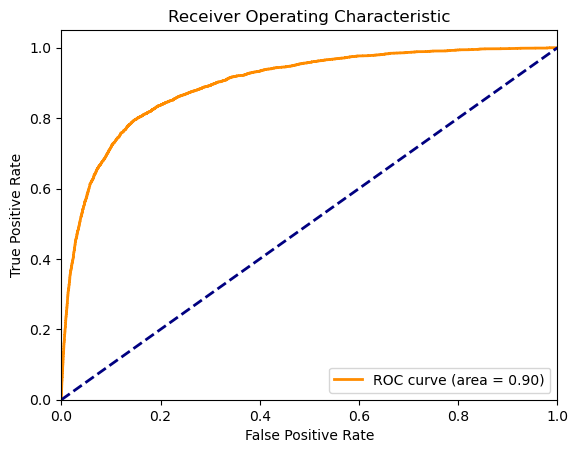

----------------------------------------


In [52]:
# Loop through the model files in the 'models' folder
for model_file in os.listdir(models_folder):
    if model_file.endswith('model_5_3_21-03-2024.bst'):
        model_path = os.path.join(models_folder, model_file)
        
        # Load the model
        bst = xgb.Booster(model_file=model_path)
        
        # Make predictions on the test data
        y_pred = bst.predict(xgb.DMatrix(X_test_preprocessed))
        
        # Convert the predictions to binary values (0 or 1)
        y_pred_rounded = np.round(y_pred)
        
        print(f"Model: {model_file}")
        
        # Compute and display metrics
        accuracy = accuracy_score(y_test, y_pred_rounded)
        roc_auc = roc_auc_score(y_test, y_pred_rounded)
        precision = sk_precision_score(y_test, y_pred_rounded)
        recall = recall_score(y_test, y_pred_rounded)
        f1 = f1_score(y_test, y_pred_rounded)

        print(f"Accuracy: {accuracy}")
        print(f"ROC AUC: {roc_auc}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        
        # Get the classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred_rounded))
        
        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred_rounded)

        # Display the confusion matrix
        print("Confusion Matrix:")
        print(cm)
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        # Convert the predictions array into a DataFrame
        df_preds = pd.DataFrame(y_pred, columns=['Prediction'])
        
        # Join predictions to enquiry keys
        # Enquiry keys, model target and tvh partition contained in test_identifiers_df
        test_identifiers_path = f'/home/sagemaker-user/Precision 3.0/test_identifiers_Assurant_DS_{ds_ratio}.csv'
        test_identifiers_df = pd.read_csv(test_identifiers_path)

        # Concatenate the identifiers and predictions
        results_df = pd.concat([test_identifiers_df, df_preds], axis=1)
        
        # Create precision scores.
        raw_prob_average_value = 0.043000000000000003
        precision_scores = []
        for pred in results_df['Prediction']:
            precision_score = pipeline.precision_score(pred, raw_prob_average_value)
            precision_scores.append(precision_score)
    
        # Create the 'Precision_Score' column in the DataFrame
        results_df['Precision_Score'] = precision_scores

        # Saving the combined DataFrame
        results_df.to_csv(f'/home/sagemaker-user/Precision 3.0/models/Assurant_Output_{model_file}.csv', index=False)
        print("-" * 40)

In [51]:
# Loop through the model files in the 'models' folder
for model_file in os.listdir(models_folder):
    if model_file.endswith('21-03-2024.bst'):
        print(f"Model: {model_file}")
        
        model_path = os.path.join(models_folder, model_file)
        
        # Load the model
        bst = xgb.Booster(model_file=model_path)
        
        # Make predictions on the test data
        y_pred = bst.predict(xgb.DMatrix(X_test_preprocessed))

        # Optimize the precision_score function
        results = pipeline.optimise_precision_score(y_test, y_pred, working_threshold=300, min_value=0.04, max_value=0.05, step_size=0.001)

        # Print the results
        for result in results:
            print(f"raw_probability_average_value: {result['raw_probability_average_value']}")
            print(f"True Positives: {result['true_positives']}")
            print(f"False Positives: {result['false_positives']}")
            print(f"True Negatives: {result['true_negatives']}")
            print(f"False Negatives: {result['false_negatives']}")
            print(f"Precision: {result['precision']}")
            print(f"Recall: {result['recall']}")
            print(f"F1-Score: {result['f1_score']}")
            print("-" * 20)

Model: model_8_3_21-03-2024.bst
raw_probability_average_value: 0.04
True Positives: 4299
False Positives: 5862
True Negatives: 12679
False Negatives: 502
Precision: 0.42308827871272514
Recall: 0.8954384503228494
F1-Score: 0.5746557946798557
--------------------
raw_probability_average_value: 0.041
True Positives: 4283
False Positives: 5747
True Negatives: 12794
False Negatives: 518
Precision: 0.42701894317048855
Recall: 0.8921058112893148
F1-Score: 0.5775740004045581
--------------------
raw_probability_average_value: 0.042
True Positives: 4275
False Positives: 5635
True Negatives: 12906
False Negatives: 526
Precision: 0.4313824419778002
Recall: 0.8904394917725473
F1-Score: 0.5811977431853714
--------------------
raw_probability_average_value: 0.043000000000000003
True Positives: 4257
False Positives: 5511
True Negatives: 13030
False Negatives: 544
Precision: 0.4358108108108108
Recall: 0.8866902728598208
F1-Score: 0.5843915162330976
--------------------
raw_probability_average_value: 0

In [97]:
1 / 21

0.047619047619047616

### Model with most TP = model 1

In [67]:
# Optimise raw_probability_average_value for model 1

# File path to df containing y_pred
predictions_file_path = '/home/sagemaker-user/Precision 3.0/models/Assurant_Output_model_8_13-03-2024 13:42:45.bst.csv'
predictions_df = pd.read_csv(predictions_file_path)
y_pred = predictions_df['Prediction']

# Load the test data and extract y_test
#test_file_path = '/home/sagemaker-user/Precision 3.0/test_Assurant.csv'
#test_data = pd.read_csv(test_file_path)
#X_test = test_data.drop('MODEL_TARGET', axis=1)
#y_test = test_data['MODEL_TARGET']

# Optimize the precision_score function
results = pipeline.optimise_precision_score(y_test, y_pred, working_threshold=300)

# Print the results
for result in results:
    print(f"raw_probability_average_value: {result['raw_probability_average_value']}")
    print(f"True Positives: {result['true_positives']}")
    print(f"False Positives: {result['false_positives']}")
    print(f"True Negatives: {result['true_negatives']}")
    print(f"False Negatives: {result['false_negatives']}")
    print(f"Precision: {result['precision']}")
    print(f"Recall: {result['recall']}")
    print(f"F1-Score: {result['f1_score']}")
    print("-" * 20)

/root/Cloud_POC/pipeline.py:386: RuntimeWarning: divide by zero encountered in scalar divide
  si_lowest_score = (final_score_average_value - final_score_lowest_score) / (raw_probability_average_value - raw_probability_lowest_score)
/root/Cloud_POC/pipeline.py:388: RuntimeWarning: divide by zero encountered in scalar divide
  si_average_value = (final_score_optimal_point - final_score_average_value) / (raw_probability_optimal_point - raw_probability_average_value)
/root/Cloud_POC/pipeline.py:390: RuntimeWarning: invalid value encountered in scalar divide
  yi_average_value = 3 * (hi_lowest_score + hi_average_value) * 1 / ((2 * hi_average_value + hi_lowest_score) / si_lowest_score + (hi_average_value + 2 * hi_lowest_score) / si_average_value)


raw_probability_average_value: 0.0
True Positives: 4801
False Positives: 18541
True Negatives: 0
False Negatives: 0
Precision: 0.2056807471510582
Recall: 1.0
F1-Score: 0.3411860853498206
--------------------
raw_probability_average_value: 0.01
True Positives: 4801
False Positives: 18511
True Negatives: 30
False Negatives: 0
Precision: 0.20594543582704186
Recall: 1.0
F1-Score: 0.34155017251805214
--------------------
raw_probability_average_value: 0.02
True Positives: 4769
False Positives: 15620
True Negatives: 2921
False Negatives: 32
Precision: 0.23390063269409975
Recall: 0.9933347219329306
F1-Score: 0.37864231838030965
--------------------
raw_probability_average_value: 0.03
True Positives: 4594
False Positives: 9914
True Negatives: 8627
False Negatives: 207
Precision: 0.3166528811690102
Recall: 0.956883982503645
F1-Score: 0.47584028173390647
--------------------
raw_probability_average_value: 0.04
True Positives: 4292
False Positives: 5813
True Negatives: 12728
False Negatives: 509


### Batch Transform Testing

In [40]:
test_df_dropped = test_df.drop(['ENQUIRY_KEY', 'TVH_PARTITION'], axis=1)

KeyError: "['ENQUIRY_KEY', 'TVH_PARTITION'] not found in axis"

In [73]:
# Determine the column types for the preprocessor
#numeric_columns, categorical_columns = pipeline.define_column_types(test_df_dropped)

# Use below when test_df loaded directly from local file
numeric_columns, categorical_columns = pipeline.define_column_types(test_df)

In [74]:
# Separate features and target
#X_test = test_df_dropped.drop('MODEL_TARGET', axis=1)
#y_test = test_df_dropped['MODEL_TARGET']

# Use below when test_df loaded directly from local file
X_test = test_df.drop('MODEL_TARGET', axis=1)
y_test = test_df['MODEL_TARGET']

In [99]:
X_test

COVERCLAIMSTARTDATEDIFFUNDER90  COVERCLAIMSTARTDATEDIFFAROUND12MONTHS  \
127014                               0                                      0   
127015                               1                                      0   
127016                               0                                      0   
127017                               0                                      0   
127018                               0                                      1   
...                                ...                                    ...   
156858                               0                                      1   
157158                               0                                      1   
161046                               0                                      0   
161370                               1                                      0   
163777                               1                                      0   

        COVERCLAIMSTARTDATEDIFFAROUND2MONTHS  COVERINCIDENTDATEDIFFLESSTHAN30  \
127014                                     0                                0   
127015                                     1                                0   
127016                                     0                                0   
127017                                     0                                0   
127018                                     0                                0   
...                                      ...                              ...   
156858                                     0                                0   
157158                                     0                                0   
161046                                     1                                0   
161370                                     1                                1   
163777                                     1                                0   

        INCIDENTCREATEDATEDIFF CLAIMTYPECODE  AGEATAPPLICATIONPTK652  \
127014                       1          loss                    24.0   
127015                       0          loss                    35.0   
127016                       5          loss                    56.0   
127017                       1          loss                    57.0   
127018                       1          loss                    32.0   
...                        ...           ...                     ...   
156858                      28         theft                    33.0   
157158                      27          loss                    41.0   
161046                      82         theft                    22.0   
161370                      51         theft                    37.0   
163777                      92         theft                    25.0   

        YOUNGCLAIMANT  HIGH_RISK_FORENAME  E_E_IDENTIFIER  ASIAN_IDENTIFIER  \
127014              0                   0               0                 0   
127015              0                   0               0                 0   
127016              0                   0               1                 0   
127017              0                   0               0                 0   
127018              0                   0               0                 1   
...               ...                 ...             ...               ...   
156858              0                   0               0                 0   
157158              0                   0               0                 0   
161046              0                   0               0                 1   
161370              0                   0               0                 0   
163777              0                   0               0                 0   

        CUR_DEL_ADDRESSLINE7_DIFF REGIONPTK652ATK1 REGIONPTK652ATK315  \
127014                          1       SOUTH WEST                NaN   
127015                          0       NORTH WEST                NaN   
127016                       

In [94]:
numeric_columns

['TVH_PARTITION',
 'COVERCLAIMSTARTDATEDIFFUNDER90',
 'COVERCLAIMSTARTDATEDIFFAROUND12MONTHS',
 'COVERCLAIMSTARTDATEDIFFAROUND2MONTHS',
 'COVERINCIDENTDATEDIFFLESSTHAN30',
 'INCIDENTCREATEDATEDIFF',
 'AGEATAPPLICATIONPTK652',
 'YOUNGCLAIMANT',
 'HIGH_RISK_FORENAME',
 'E_E_IDENTIFIER',
 'ASIAN_IDENTIFIER',
 'CUR_DEL_ADDRESSLINE7_DIFF',
 'FIRSTTWOPOSTCODEPTK652ATK1_GROUPED',
 'FIRSTTWOPOSTCODEPTK652ATK315_GROUPED',
 'ADDRESSDISTANCE_PTK1ATK1PTK1ATK315',
 'SHORTEMAILADDRESS',
 'EMAILADDRESSLENGTH',
 'MAILBOXLENGTH',
 'BADEMAILCLIENTLIST',
 'WORKPHONESTANDARDPRESENT',
 'LANDLINESTANDARDPRESENT',
 'LANDLINENONSTANDARD',
 'CMRT0012',
 'CMRT0013',
 'CMRT002',
 'CMRT014',
 'CMRT015',
 'CMRT03',
 'HIGH_RISK_HANDSETS',
 'HIGH_VALUE_HANDSETS',
 'IMEI03',
 'IR01',
 'IR02',
 'IR04',
 'IR06',
 'IR07',
 'IR08',
 'LRT01',
 'LRT02',
 'LRT03',
 'LRT04',
 'LRT05',
 'LRT06',
 'LRT10',
 'LRT11',
 'LRTS01',
 'LRTS02',
 'LRTS03',
 'LRTS04',
 'NEWLY_RELEASED_HANDSETS',
 'NRTP01',
 'NRTP02',
 'NRTP04',
 'NRTP1

In [75]:
# Apply transformations to test data
X_preprocessed = pipeline.preprocess(X_test, numeric_columns, categorical_columns)

Transformed data shape: (23342, 688)
Number of column names: 688


In [76]:
X_preprocessed

COVERCLAIMSTARTDATEDIFFUNDER90  COVERCLAIMSTARTDATEDIFFAROUND12MONTHS  \
0                                 0.0                                    0.0   
1                                 1.0                                    0.0   
2                                 0.0                                    0.0   
3                                 0.0                                    0.0   
4                                 0.0                                    1.0   
...                               ...                                    ...   
23337                             0.0                                    1.0   
23338                             0.0                                    1.0   
23339                             0.0                                    0.0   
23340                             1.0                                    0.0   
23341                             1.0                                    0.0   

       COVERCLAIMSTARTDATEDIFFAROUND2MONTHS  COVERINCIDENTDATEDIFFLESSTHAN30  \
0                                       0.0                              0.0   
1                                       1.0                              0.0   
2                                       0.0                              0.0   
3                                       0.0                              0.0   
4                                       0.0                              0.0   
...                                     ...                              ...   
23337                                   0.0                              0.0   
23338                                   0.0                              0.0   
23339                                   1.0                              0.0   
23340                                   1.0                              1.0   
23341                                   1.0                              0.0   

       INCIDENTCREATEDATEDIFF  AGEATAPPLICATIONPTK652  YOUNGCLAIMANT  \
0                         1.0                    24.0            0.0   
1                         0.0                    35.0            0.0   
2                         5.0                    56.0            0.0   
3                         1.0                    57.0            0.0   
4                         1.0                    32.0            0.0   
...                       ...                     ...            ...   
23337                    28.0                    33.0            0.0   
23338                    27.0                    41.0            0.0   
23339                    82.0                    22.0            0.0   
23340                    51.0                    37.0            0.0   
23341                    92.0                    25.0            0.0   

       HIGH_RISK_FORENAME  E_E_IDENTIFIER  ASIAN_IDENTIFIER  \
0                     0.0             0.0               0.0   
1                     0.0             0.0               0.0   
2                     0.0             1.0               0.0   
3                     0.0             0.0               0.0   
4                     0.0             0.0               1.0   
...                   ...             ...               ...   
23337                 0.0             0.0               0.0   
23338                 0.0             0.0               0.0   
23339                 0.0             0.0               1.0   
23340                 0.0             0.0               0.0   
23341                 0.0             0.0               0.0   

       CUR_DEL_ADDRESSLINE7_DIFF  FIRSTTWOPOSTCODEPTK652ATK1_GROUPED  \
0                            1.0                                 3.0   
1                            0.0                                 1.0   
2                            1.0                                 3.0   
3                            0.0                                 3.0   
4                            0.0                                 2.0   
...                          ..

In [112]:
# Define local file path
X_test_path = '/home/sagemaker-user/Precision 3.0/X_test.csv'

In [113]:
# Define file name
X_test_file = f'{client_name}/X_test.csv'

In [114]:
# Save DataFrames as csv files in local directory
X_preprocessed.to_csv(X_test_path, index=False, header=False) # Batch transform jobs expect CSV files without a header

In [115]:
# Upload X_test to S3
pipeline.upload_to_s3(X_test_path, bucket, X_test_file)

Upload Successful: /root/Cloud_POC/X_test.csv to sagemaker-eu-north-1-548667879511/Assurant/X_test.csv


In [77]:
# Initialise the SageMaker session and get the role
sagemaker_session = None  # Removed for public version
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [78]:
# Specify the framework name, version, and your AWS region
framework, version, region = 'xgboost', framework_version, sagemaker_session.boto_region_name

# Retrieve the image URI
image_uri = image_uris.retrieve(framework=framework, region=region, version=version)
print(image_uri)

662702820516.dkr.ecr.eu-north-1.amazonaws.com/sagemaker-xgboost:1.3-1


In [79]:
# Create a SageMaker model from the hyperparameter tuning job
model_data = 's3://sagemaker-eu-north-1-548667879511/Assurant/model_output/sagemaker-xgboost-240125-1443-002-a582d117/output/model.tar.gz'  # Replace with your model artifacts path
model = Model(
    model_data=model_data,
    image_uri=image_uri,  
    role=role,
    sagemaker_session=sagemaker_session
)

In [80]:
# Create a transformer object for batch transform
transformer = model.transformer(
    instance_count=1,
    instance_type='ml.m5.large',  # Choose an appropriate instance type
    output_path='s3://sagemaker-eu-north-1-548667879511/Assurant/Batch_Transform_Output_2/'  # Replace with your desired output path
)

In [81]:
# Start a batch transform job to test the model on the test set
transformer.transform(
    's3://sagemaker-eu-north-1-548667879511/Assurant/X_test.csv',  # Replace with your test data path
    content_type='text/csv',  # Replace with the appropriate content type for your data
    split_type='Line'  # 'Line' or 'Record' based on your data format
)

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-01-25-14-57-43-370


..............................[2024-01-25:15:02:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-01-25:15:02:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-01-25:15:02:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-01-25 15:02:44 +0000] [16] [INFO] Starting gunic

In [82]:
# Wait for the transform job to finish
transformer.wait()

[2024-01-25:15:02:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-01-25:15:02:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-01-25:15:02:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-01-25 15:02:44 +0000] [16] [INFO] Starting gunicorn 19.10.0
[2024-01-25 15:02:

In [83]:
# Download batch transform output
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket and object key
bucket_name = 'sagemaker-eu-north-1-548667879511'
object_key = 'Assurant/Batch_Transform_Output_2/X_test.csv.out'
local_filename = '/home/sagemaker-user/Precision 3.0/X_test_Assurant.csv.out'

# Download the file
s3.download_file(bucket_name, object_key, local_filename)

In [84]:
# Load the predictions
predictions = pd.read_csv('/home/sagemaker-user/Precision 3.0/X_test_Assurant.csv.out', header=None)

In [85]:
predictions

0
0      0.918571
1      0.887864
2      0.927565
3      0.923959
4      0.887550
...         ...
23337  0.856479
23338  0.859146
23339  0.851222
23340  0.873124
23341  0.849291

[23342 rows x 1 columns]

In [86]:
# Save predictions
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant.csv'
predictions.to_csv(predictions_file_path, index=False)

In [87]:
# Use to load predictions when predictions saved locally
predictions = pd.read_csv(predictions_file_path)

In [88]:
y_test

0        0
1        0
2        0
3        0
4        1
        ..
23337    0
23338    0
23339    0
23340    1
23341    1
Name: MODEL_TARGET, Length: 23342, dtype: int64

In [89]:
accuracy = accuracy_score(y_test, predictions.round())
roc_auc = roc_auc_score(y_test, predictions)
precision = precision_score(y_test, predictions.round())
recall = recall_score(y_test, predictions.round())
f1 = f1_score(y_test, predictions.round())

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.2056807471510582
ROC AUC: 0.45000161264337574
Precision: 0.2056807471510582
Recall: 1.0
F1 Score: 0.3411860853498206


In [90]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions.round())

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[    0 18541]
 [    0  4801]]


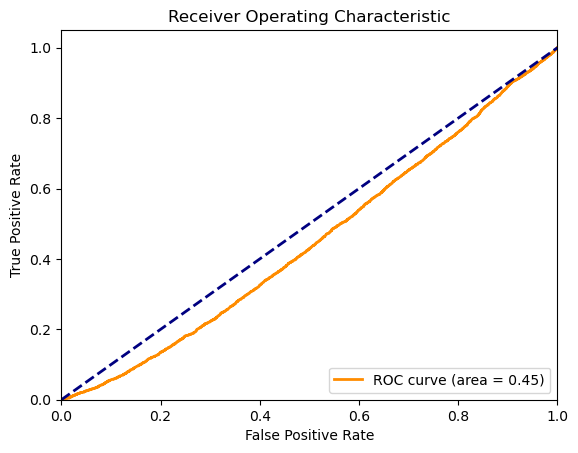

In [91]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [92]:
# Join predictions to enquiry keys
# Enquiry keys, model target and tvh partition contained in test_identifiers_df
test_identifiers_df = pd.read_csv(test_identifiers_path)

# Predictions file to df
predictions_file_path = '/home/sagemaker-user/Precision 3.0/predictions_Assurant.csv'
predictions_df = pd.read_csv(predictions_file_path)

# Concatenate the identifiers and predictions
result_df = pd.concat([test_identifiers_df, predictions_df], axis=1)

# Saving the combined DataFrame
result_df.to_csv('predictions_with_identifiers.csv', index=False)

### Feature Importance

In [20]:
# Initialise S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and object key
bucket_name = 'sagemaker-eu-north-1-548667879511'
model_key = 'Assurant/model_output/sagemaker-xgboost-240124-1631-001-b184af9a/output/model.tar.gz'

# Local path to save the model
local_model_path = '/home/sagemaker-user/Precision 3.0/model.tar.gz'

# Download the model from S3
s3.download_file(bucket_name, model_key, local_model_path)

In [21]:
# Local path to save the extracted model
local_extracted_model_path = '/home/sagemaker-user/Precision 3.0/model'

In [57]:
# Extract the model file
with tarfile.open(local_model_path, 'r:gz') as tar:
    tar.extractall(path=local_extracted_model_path)

In [58]:
# Load the model
xgb_model = xgb.Booster()
xgb_model.load_model(local_extracted_model_path + '/model.bst')

In [20]:
# Get feature importance
feature_importance = model.get_score(importance_type='gain')  # Can change to 'weight' or 'cover'

# Sort the feature importance in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

In [50]:
def get_transformed_feature_names(column_transformer):
    """
    Get feature names from ColumnTransformer.
    """
    feature_names = []
    
    for transformer_name, transformer, original_features in column_transformer.transformers_:
        if transformer_name == 'remainder':
            # If remainder is 'passthrough', original_features are returned untransformed
            if transformer == 'passthrough':
                feature_names.extend(original_features)
            continue
        
        # Extract feature names from the transformers
        if hasattr(transformer, 'get_feature_names_out'):
            # Handles transformers with get_feature_names_out method like OneHotEncoder
            if isinstance(transformer, Pipeline):
                transformer = transformer.named_steps['onehot']
            new_features = transformer.get_feature_names_out(original_features)
            feature_names.extend(new_features)
        else:
            # If a transformer doesn't have a get_feature_names_out method, use the original feature names
            feature_names.extend(original_features)
    
    return feature_names

# Call this function after fitting the preprocessor
feature_names = get_transformed_feature_names(preprocessor)

In [54]:
# Load the trained model
model = xgb.Booster(model_file='/home/sagemaker-user/Precision 3.0/models/model.bst')

# Get feature importance
feature_importance = model.get_score(importance_type='gain')  # Can change to 'weight' or 'cover'

# Now, you can safely call your function to get the feature names
feature_names = get_transformed_feature_names(preprocessor)

# Match feature names with their importances
importance_dict = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Convert to a sorted list for better visualization or analysis
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

In [55]:
sorted_importance

[('PRECISIONLOCAL02MATCH', 3920.754150390625),
 ('COVERINCIDENTDATEDIFFLESSTHAN30', 1416.4718017578125),
 ('LRT10', 1305.9249267578125),
 ('NEWLY_RELEASED_HANDSETS', 506.01611328125),
 ('PRECISIONLOCAL01MATCH', 281.8096923828125),
 ('FIRSTTWOPOSTCODEPTK652ATK315_CLEAR_50_OCCUR_NOT_PROVIDED',
  261.62127685546875),
 ('HIGH_VALUE_HANDSETS', 214.81427001953125),
 ('FIRSTTWOPOSTCODEPTK652ATK315_BANDING_NOT_PROVIDED', 183.85574340820312),
 ('LRT02', 178.2517547607422),
 ('COUNTY_PTK1ATK315_==Missing==', 176.26461791992188),
 ('CMRT002', 132.78529357910156),
 ('PRECISIONLOCAL03MATCH', 126.46171569824219),
 ('WORKPHONESTANDARDPRESENT', 116.40142059326172),
 ('COVERCLAIMSTARTDATEDIFFUNDER90', 91.65169525146484),
 ('REGIONPTK652ATK315_==Missing==', 89.01483154296875),
 ('EMAILDOMAINSUFFIXPTK652_GROUPED_com', 86.98916625976562),
 ('FIRSTTWOPOSTCODEPTK1ATK315_NW_BANDING_NOT_PROVIDED', 78.71851348876953),
 ('CMRT03', 76.42377471923828),
 ('MODEL_BANDING_IPHONE_PRO_MAX', 75.12394714355469),
 ('LAST

In [60]:
sorted_importance

[('f58', 492.7379150390625),
 ('f3', 205.2503662109375),
 ('f42', 194.52285766601562),
 ('f57', 83.05622863769531),
 ('f48', 82.52493286132812),
 ('f28', 72.73696899414062),
 ('f194', 69.06597900390625),
 ('f18', 60.85725784301758),
 ('f19', 60.695770263671875),
 ('f23', 55.77874755859375),
 ('f418', 44.02204132080078),
 ('f86', 41.410072326660156),
 ('f26', 41.151763916015625),
 ('f59', 40.39414596557617),
 ('f34', 37.524879455566406),
 ('f8', 33.521854400634766),
 ('f365', 32.41049575805664),
 ('f63', 32.17108154296875),
 ('f300', 31.479265213012695),
 ('f277', 31.236913681030273),
 ('f62', 27.43449592590332),
 ('f421', 25.61844253540039),
 ('f17', 24.86835479736328),
 ('f2', 24.499942779541016),
 ('f113', 24.496652603149414),
 ('f40', 22.50750732421875),
 ('f0', 22.504037857055664),
 ('f39', 21.831363677978516),
 ('f37', 21.70818328857422),
 ('f504', 21.01641845703125),
 ('f36', 19.31687355041504),
 ('f357', 17.79896354675293),
 ('f65', 17.61026382446289),
 ('f43', 17.14533996582031

In [24]:
# Specify your bucket name and file path in the bucket
# Initialize a session
s3 = boto3.client('s3')
object_name = 'X_train_preprocessed.npz'
local_file_path = '/home/sagemaker-user/Precision 3.0/models/X_train_preprocessed.npz'  # The path where you want to save the file

# Download the file
s3.download_file(bucket, object_name, local_file_path)

In [64]:
# Download training input data
s3_file_key = 'X_train_preprocessed.npz'

s3.download_file(bucket_name, s3_file_key, '/home/sagemaker-user/Precision 3.0/X_train_preprocessed.csv')

In [25]:
# Load the CSR matrix from the NPZ file
loaded_matrix = sparse.load_npz(local_file_path)

In [27]:
# Assuming 'loaded_matrix' is your CSR matrix loaded from the .npz file
dense_matrix = loaded_matrix.toarray()

# Now, convert the dense matrix to a DataFrame
df = pd.DataFrame(dense_matrix)

In [65]:
X_train = pd.read_csv('/home/sagemaker-user/Precision 3.0/X_train_preprocessed.csv')

In [28]:
df.head()

0    1    2    3     4     5    6    7    8    9    10   11   12       13   \
0  1.0  0.0  1.0  0.0   4.0  46.0  0.0  0.0  0.0  0.0  0.0  3.0  3.0      0.0   
1  1.0  0.0  1.0  0.0  17.0  41.0  0.0  0.0  0.0  0.0  0.0  3.0  1.0 -99999.0   
2  1.0  0.0  1.0  0.0   0.0  51.0  0.0  0.0  0.0  0.0  1.0  3.0  1.0 -99999.0   
3  0.0  0.0  1.0  0.0   1.0  32.0  0.0  0.0  0.0  0.0  0.0  2.0  2.0 -99999.0   
4  1.0  0.0  1.0  0.0   1.0  52.0  0.0  0.0  0.0  0.0  0.0  2.0  1.0 -99999.0   

       14       15       16       17   18   19   20   21   22   23   24   25   \
0 -99999.0 -99999.0 -99999.0 -99999.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1 -99999.0 -99999.0 -99999.0 -99999.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      1.0     24.0     10.0      0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      1.0     23.0     13.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      1.0     22.0     10.0      0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

   86   87   88   89   90   91   92   93   94   95   96   97   98   99   100  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  \
0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

   116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [29]:
# Get map of feature names from DMatrix name format (XGBoost's internal data structure) to original names
feature_map = {f'f{i}': col for i, col in enumerate(df.columns)}

In [30]:
feature_map

{'f0': 0,
 'f1': 1,
 'f2': 2,
 'f3': 3,
 'f4': 4,
 'f5': 5,
 'f6': 6,
 'f7': 7,
 'f8': 8,
 'f9': 9,
 'f10': 10,
 'f11': 11,
 'f12': 12,
 'f13': 13,
 'f14': 14,
 'f15': 15,
 'f16': 16,
 'f17': 17,
 'f18': 18,
 'f19': 19,
 'f20': 20,
 'f21': 21,
 'f22': 22,
 'f23': 23,
 'f24': 24,
 'f25': 25,
 'f26': 26,
 'f27': 27,
 'f28': 28,
 'f29': 29,
 'f30': 30,
 'f31': 31,
 'f32': 32,
 'f33': 33,
 'f34': 34,
 'f35': 35,
 'f36': 36,
 'f37': 37,
 'f38': 38,
 'f39': 39,
 'f40': 40,
 'f41': 41,
 'f42': 42,
 'f43': 43,
 'f44': 44,
 'f45': 45,
 'f46': 46,
 'f47': 47,
 'f48': 48,
 'f49': 49,
 'f50': 50,
 'f51': 51,
 'f52': 52,
 'f53': 53,
 'f54': 54,
 'f55': 55,
 'f56': 56,
 'f57': 57,
 'f58': 58,
 'f59': 59,
 'f60': 60,
 'f61': 61,
 'f62': 62,
 'f63': 63,
 'f64': 64,
 'f65': 65,
 'f66': 66,
 'f67': 67,
 'f68': 68,
 'f69': 69,
 'f70': 70,
 'f71': 71,
 'f72': 72,
 'f73': 73,
 'f74': 74,
 'f75': 75,
 'f76': 76,
 'f77': 77,
 'f78': 78,
 'f79': 79,
 'f80': 80,
 'f81': 81,
 'f82': 82,
 'f83': 83,
 'f84': 84,


In [70]:
# Replace generic names with actual names
sorted_importance_named = [(feature_map[f_name], importance) for f_name, importance in sorted_importance]

In [71]:
sorted_importance_named

[('PRECISIONLOCAL02MATCH', 492.7379150390625),
 ('COVERINCIDENTDATEDIFFLESSTHAN30', 205.2503662109375),
 ('LRT10', 194.52285766601562),
 ('PRECISIONLOCAL01MATCH', 83.05622863769531),
 ('NEWLY_RELEASED_HANDSETS', 82.52493286132812),
 ('HIGH_VALUE_HANDSETS', 72.73696899414062),
 ('COUNTY_PTK1ATK315_==Missing==', 69.06597900390625),
 ('WORKPHONESTANDARDPRESENT', 60.85725784301758),
 ('LANDLINESTANDARDPRESENT', 60.695770263671875),
 ('CMRT002', 55.77874755859375),
 ('MODEL_BANDING_IPHONE', 44.02204132080078),
 ('REGIONPTK652ATK315_==Missing==', 41.410072326660156),
 ('CMRT03', 41.151763916015625),
 ('PRECISIONLOCAL03MATCH', 40.39414596557617),
 ('IR07', 37.524879455566406),
 ('E_E_IDENTIFIER', 33.521854400634766),
 ('EMAILDOMAINSUFFIXPTK652_GROUPED_com', 32.41049575805664),
 ('PRECISIONNATIONAL02MATCH', 32.17108154296875),
 ('EMAILDOMAINPREFIXPTK652_GROUPED_==Missing==', 31.479265213012695),
 ('LASTTWOEMAILPTK652ETK60003_JPMC_BANDING_MEDIUM_RISK', 31.236913681030273),
 ('PRECISIONNATIONAL0

### Feature Reduction

In [10]:
# Define local file paths
train_path = '/home/sagemaker-user/Precision 3.0/train_Assurant_reduction.csv'
validation_path = '/home/sagemaker-user/Precision 3.0/validation_Assurant_reduction.csv'
test_path = '/home/sagemaker-user/Precision 3.0/test_Assurant_reduction.csv'

In [9]:
# Define the features to be removed
features_to_remove = [
    'IR04',
    'NRTP04',
    'LRTS02',
    'FIRSTTWOPOSTCODEPTK652ATK315_CLEAR_50_OCCUR',
    'FIRSTTWOPOSTCODEPTK652ATK1_TOP_50_OCCUR'
]

# Remove the features from the train set
train_undersampled = pd.read_csv(train_path)
train_undersampled = train_undersampled.drop(features_to_remove, axis=1)

# Remove the features from the validation set
validation_df = pd.read_csv(validation_path)
validation_df = validation_df.drop(features_to_remove, axis=1)

# Remove the features from the test set
test_df = pd.read_csv(test_path)
test_df = test_df.drop(features_to_remove, axis=1)

In [11]:
# Define file names
train_file = f'{client_name}/train.csv'
validation_file = f'{client_name}/validation.csv'
test_file = f'{client_name}/test.csv'

In [12]:
train_undersampled.to_csv(train_path, index=False)
validation_df.to_csv(validation_path, index=False)
test_df.to_csv(test_path, index=False)

In [13]:
# Upload files
pipeline.upload_to_s3(train_path, bucket, train_file)
pipeline.upload_to_s3(validation_path, bucket, validation_file)
pipeline.upload_to_s3(test_path, bucket, test_file)

Upload Successful: /root/Cloud_POC/train_Assurant_reduction.csv to sagemaker-eu-north-1-548667879511/Assurant/train.csv
Upload Successful: /root/Cloud_POC/validation_Assurant_reduction.csv to sagemaker-eu-north-1-548667879511/Assurant/validation.csv
Upload Successful: /root/Cloud_POC/test_Assurant_reduction.csv to sagemaker-eu-north-1-548667879511/Assurant/test.csv


### Testing

In [23]:
# Install version of XGBoost on which the model was trained.
!pip install xgboost==1.3.1


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [24]:
# Define the S3 paths
model_path = 's3://sagemaker-eu-north-1-548667879511/Assurant/model_output/sagemaker-xgboost-2024-01-16-14-23-31-740/output/model.tar.gz'
test_data_path = 's3://sagemaker-eu-north-1-548667879511/Assurant/test.csv'

In [25]:
# Initialise S3 client and model identifiers
s3 = boto3.client('s3')
bucket_name = 'sagemaker-eu-north-1-548667879511'
object_key = 'Assurant/model_output/sagemaker-xgboost-2024-01-16-14-23-31-740/output/model.tar.gz'
local_file_name = 'model.tar.gz'

In [52]:
# Download model to local directory
s3.download_file(bucket_name, object_key, local_file_name)

In [54]:
# Extract the model file
with tarfile.open(local_file_name, 'r:gz') as tar:
    tar.extractall(path='.')

In [ ]:
# Extracted model file
model_file = 'model.joblib'

# Load the model
model = xgb.Booster(model_file=model_file)  # Assuming 'model_file' is the correct model file path

In [7]:
# Specify the path to the model artifacts in S3
model_s3_path = 's3://sagemaker-eu-north-1-548667879511/Assurant/model_output/sagemaker-xgboost-2024-01-16-14-23-31-740/output/model.tar.gz'

# Create a SageMaker Model
xgb_model = sagemaker.model.Model(model_data=model_s3_path,
                                  image_uri='662702820516.dkr.ecr.eu-north-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3',
                                  role=role,
                                  sagemaker_session=sagemaker_session)

In [ ]:
predictor = xgb_model.deploy(instance_type='ml.c5.large', endpoint_name='assurant-xgboost', initial_instance_count=1)

-------------------------------------